<a href="https://colab.research.google.com/github/MagicAlex238/2_Micro/blob/main/3_Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__Feature Importance__

# Table of Contents

# 1. Introduction

from Notebook Filtering.ipynb after statistical Analyis, we continue this notebook with 5 dataframes :
**original** dataframe as baseline for comparison. Contains 880 genera         
**uniques** unfiltered exclusive genera, contains 341 genera  
**uniques23** unfiltered exclusive genera plus common from categories 2 and 3, contains 773 genera      
**Influencers_OLS** filtered from original by threshold 0.2% abundance and frequency minimum of 3, selected genera using Ordinary Least Squares     
**OLS_all** selected data from the original underwent selection of significance by OLS.  
**uniques_OLS** selected from the original uniques Genera for each category were selected, posterior underwent selection of significance by OLS.   
**uniques_23_OLS** selected data from the original uniques Genera for each category, plus the common genera from category 2 and 3, posterior OLS.     
This notebook selects from original, uniques and uniques23 the 50 most influential features per pca analyis for the following df
**original_pca** from original after pca, made in this notebook and contains 51 genera
**uniques_pca** from uniques after pca, made in this notebook, contains 51 genera      
**uniques23_pca** from uniques23 after pca, contains 51 genera
**Influencers_uniques** from the mix of Influencers_OLS and uniques_OLS, contains 27 genera
**Influencers_uniques_selected** top 20 genera from the mix of Influencers_OLS and uniques_OLS
**Merged_selected** 10 Top, coming from the combination of original_pca, uniques_pca, uniques23_pca, uniques23_OLS and OLS_all
**old_new** old analysis that combined filtering by OLS and pca with the added column of frequency of occurency

Starting with 5 different df: OLS_all, Influencers_OLS, uniques_OLS, uniques_23_OLS, original apply the following pipelines
1. Apply Pipelines:
   * PCA visual scree plot and PCA scatterplot:
        These focus on the dimensionality reduction aspect and the structure of the data in the reduced space.  
   * PCA  Feature Influence , explained variance
     This focuses on how each feature contributes to the variance explained by the principal components.
   * Random Forest Regression- Feature importance
   * Random Forest Classification- Feature importance
2. Visually comparing Feature Importances and Influences:
   * Extract feature importances from the Random Forest models. This focuses on the predictive power of each feature in the context of a Random Forest model
   * Extract feature influences from the PCA pipeline.
3. Combine and Select Most Influential Features:
   * Combine the results from different pipelines according to importance, influence and frequency into a DataFrame.
   * Select the top influential features : This is the case with Influencers_uniques and Merged_selected
4. Replace IDs/GIDs with Biological Names:
   * Map the feature IDs to their corresponding biological names.
   * Analyze the biological significance of the selected features. For each dataframe and see if they make sense.

__Logistic Regression with L1 Regularization:__ This can help in feature selection by shrinking the coefficients of less important features to zero.
Random Forest or Gradient Boosting: These tree-based models can provide a feature importance score for each GID.
__Influence:__ Since the 'Influence' feature accounts for both abundance and frequency, it might be worthwhile to also consider this feature in the analysis. We can repeat the above steps using 'Influence' as the dependent variable instead of 'Abundance' to see if it provides any additional insights. Additionally at the end we have a list of most relevant Genera to continue to book 4.

In [9]:
!pip install umap-learn

# 2. Data Preproccessing

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import braycurtis
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import plot_tree, export_text
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from IPython.display import display, HTML
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score
from umap import UMAP
import umap.umap_ as umap
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest

In [11]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os

#change the bloody path
os.chdir('/content/drive/My Drive/MIC')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
pd.options.display.float_format = '{:.4f}'.format
#Reading the data
original  = pd.read_excel('data/original.xlsx', dtype={'Sites': str, 'Category': int})

uniques   = pd.read_excel('data/uniques_unfiltered.xlsx', dtype={'Sites': str, 'Category': int})

uniques23 = pd.read_excel('data/uniques_unfiltered.xlsx', sheet_name='uniques23', dtype={'Sites': str, 'Category': int})

OLS_all = pd.read_excel('data/OLS_all.xlsx', dtype={'Sites': str, 'Category': int})

Influencers_OLS = pd.read_excel('data/Influencers_OLS.xlsx', dtype={'Sites': str, 'Category': int})

uniques_OLS = pd.read_excel('data/uniques_OLS.xlsx', dtype={'Sites': str, 'Category': int})

uniques23_OLS = pd.read_excel('data/uniques23_OLS.xlsx', dtype={'Sites': str, 'Category': int})

In [13]:
uniques.head()

Unnamed: 0   Sites  Category      2      4      5     10     14     15  \
0           0  site_1         3 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
1           1  site_2         1 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
2           2  site_3         1 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
3           3  site_4         1 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
4           4  site_5         1 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

      16  ...    856    857    860    861    868    872    874    877    879  \
0 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
1 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
2 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
3 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0022 0.0000 0.0000 0.0000   
4 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

     880  
0 0.0000  
1 0.0000  
2 0.0000  
3 0.0000  
4 0.0000  

[5 rows x 342 columns]

In [14]:
def clean_dataframe(df):
    # drop unnamed column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns='Unnamed: 0', axis=1)

    # feature columns (all numeric columns except Category)
    feature_columns = [col for col in df.columns if col != 'Category' and col != 'Sites']
    df.columns = ['Sites', 'Category'] + [int(col) for col in feature_columns]

    return (df.astype({'Sites': str, 'Category': int})
            .set_index("Sites"))

original = clean_dataframe(original)
uniques = clean_dataframe(uniques)
uniques23 = clean_dataframe(uniques23)
OLS_all = clean_dataframe(OLS_all)
Influencers_OLS = clean_dataframe(Influencers_OLS)
uniques_OLS= clean_dataframe(uniques_OLS)
uniques23_OLS= clean_dataframe(uniques23_OLS)

In [195]:
def analyze_selected_features(filtered_df):
    """
    Analyze frequency and abundance for selected features
    """
    feature_cols = [col for col in filtered_df.columns if col not in ['Sites', 'Category']]

    for feature in feature_cols:
        print(f"\nFeature {feature}:")
        for cat in [1, 2, 3]:
            cat_data = filtered_df[filtered_df['Category'] == cat][feature]
            present = sum(cat_data > 0)
            total = len(cat_data)

            print(f"Category {cat}:")
            print(f"Present in {present}/{total} ({present/total*100:.1f}%)")
            print(f"Mean abundance: {cat_data.mean():.4f}")

In [196]:
analyze_selected_features(Influencers_OLS)


Feature 725:
Category 1:
Present in 9/17 (52.9%)
Mean abundance: 0.5820
Category 2:
Present in 0/32 (0.0%)
Mean abundance: 0.0000
Category 3:
Present in 0/21 (0.0%)
Mean abundance: 0.0000

Feature 871:
Category 1:
Present in 6/17 (35.3%)
Mean abundance: 0.3658
Category 2:
Present in 0/32 (0.0%)
Mean abundance: 0.0000
Category 3:
Present in 0/21 (0.0%)
Mean abundance: 0.0000

Feature 214:
Category 1:
Present in 0/17 (0.0%)
Mean abundance: 0.0000
Category 2:
Present in 8/32 (25.0%)
Mean abundance: 0.2834
Category 3:
Present in 11/21 (52.4%)
Mean abundance: 1.5101

Feature 351:
Category 1:
Present in 11/17 (64.7%)
Mean abundance: 0.7303
Category 2:
Present in 16/32 (50.0%)
Mean abundance: 0.2684
Category 3:
Present in 0/21 (0.0%)
Mean abundance: 0.0000

Feature 23:
Category 1:
Present in 9/17 (52.9%)
Mean abundance: 0.2877
Category 2:
Present in 0/32 (0.0%)
Mean abundance: 0.0000
Category 3:
Present in 0/21 (0.0%)
Mean abundance: 0.0000

Feature 91:
Category 1:
Present in 11/17 (64.7%)
M

Based on these frequencies and abundances, here are the most reliable markers:

Class 1:
ASV 549: Present in 82.4%, mean abundance 1.36
Features 351, 91, 375, 864: Present in ~65%, good abundances
Class 3:

ASV 526: Present in 71.4%, mean abundance 0.49
ASV 408, 229: Present in 61.9%, with 229 showing high abundance (1.19)
ASV 214: Present in 52.4%, highest abundance (1.51)
ASV 863 should indeed be removed - similar frequencies in class 1 and 2 (58.8% vs 59.4%), similar abundances (0.45 vs 0.50).
Feature 549: Present in 82.4% of Category 1 samples with a high mean abundance of 1.3636
Feature 351: Present in 64.7% of Category 1 and 50% of Category 2 samples
Feature 91: Present in 64.7% of Category 1 and 50% of Category 2 samples
Feature 214: Uniquely present in Categories 2 and 3 (not in Category 1)
Feature 408: Present in 43.8% of Category 2 and 61.9% of Category 3 samples
Feature 229: Present in 37.5% of Category 2 and 61.9% of Category 3 samples
Class 2 lacks strong unique markers - most shared with class 1 or 3.
However 549 good marker of class 1, it is actually making the other classes less visible and for that it is fired.

In [198]:
analyze_selected_features(Influencers_uniques)


Feature 725:
Category 1:
Present in 9/17 (52.9%)
Mean abundance: 0.5820
Category 2:
Present in 0/32 (0.0%)
Mean abundance: 0.0000
Category 3:
Present in 0/21 (0.0%)
Mean abundance: 0.0000

Feature 871:
Category 1:
Present in 6/17 (35.3%)
Mean abundance: 0.3658
Category 2:
Present in 0/32 (0.0%)
Mean abundance: 0.0000
Category 3:
Present in 0/21 (0.0%)
Mean abundance: 0.0000

Feature 214:
Category 1:
Present in 0/17 (0.0%)
Mean abundance: 0.0000
Category 2:
Present in 8/32 (25.0%)
Mean abundance: 0.2834
Category 3:
Present in 11/21 (52.4%)
Mean abundance: 1.5101

Feature 351:
Category 1:
Present in 11/17 (64.7%)
Mean abundance: 0.7303
Category 2:
Present in 16/32 (50.0%)
Mean abundance: 0.2684
Category 3:
Present in 0/21 (0.0%)
Mean abundance: 0.0000

Feature 23:
Category 1:
Present in 9/17 (52.9%)
Mean abundance: 0.2877
Category 2:
Present in 0/32 (0.0%)
Mean abundance: 0.0000
Category 3:
Present in 0/21 (0.0%)
Mean abundance: 0.0000

Feature 91:
Category 1:
Present in 11/17 (64.7%)
M

Category 1 Markers:

Feature 549:

82.4% of Category 1 samples (14/17)
High mean abundance (1.3636)


Feature 351 and Feature 91:

64.7% of Category 1 samples (11/17)
High mean abundances (0.7303 and 0.9006)



Category 2 Markers:

Feature 408:

43.8% of Category 2 samples (14/32)


Feature 229:

37.5% of Category 2 samples (12/32)



Category 3 Markers:

Feature 214:

52.4% of Category 3 samples (11/21)
Highest mean abundance (1.5101)


Feature 229:

61.9% of Category 3 samples (13/21)
High mean abundance (1.1856)


Feature 408:

61.9% of Category 3 samples (13/21)

In [199]:
analyze_selected_features(high_loadings)


Feature 229:
Category 1:
Present in 6/17 (35.3%)
Mean abundance: 0.1092
Category 2:
Present in 12/32 (37.5%)
Mean abundance: 0.1405
Category 3:
Present in 13/21 (61.9%)
Mean abundance: 1.1856

Feature 214:
Category 1:
Present in 4/17 (23.5%)
Mean abundance: 0.0743
Category 2:
Present in 8/32 (25.0%)
Mean abundance: 0.2834
Category 3:
Present in 11/21 (52.4%)
Mean abundance: 1.5101

Feature 497:
Category 1:
Present in 0/17 (0.0%)
Mean abundance: 0.0000
Category 2:
Present in 1/32 (3.1%)
Mean abundance: 0.0005
Category 3:
Present in 5/21 (23.8%)
Mean abundance: 0.0132

Feature 154:
Category 1:
Present in 0/17 (0.0%)
Mean abundance: 0.0000
Category 2:
Present in 1/32 (3.1%)
Mean abundance: 0.0008
Category 3:
Present in 6/21 (28.6%)
Mean abundance: 0.0169

Feature 201:
Category 1:
Present in 0/17 (0.0%)
Mean abundance: 0.0000
Category 2:
Present in 0/32 (0.0%)
Mean abundance: 0.0000
Category 3:
Present in 3/21 (14.3%)
Mean abundance: 0.0019

Feature 408:
Category 1:
Present in 8/17 (47.1%

Category 1 (Strongest):

Feature 491: 94.1% presence (16/17)
Feature 110: 100% presence (17/17)
Feature 270: 88.2% presence (15/17)
Feature 549: 82.4% presence (14/17)
Feature 526: 76.5% presence (13/17)

Category 2 (Strongest):

Feature 491: 75.0% presence (24/32)
Feature 110: 81.2% presence (26/32)
Feature 526: 56.2% presence (18/32)

Category 3 (Strongest):

Feature 491: 95.2% presence (20/21)
Feature 110: 85.7% presence (18/21)
Feature 323: 66.7% presence (14/21)
Feature 214: 52.4% presence (11/21)

Notable observations:

Features 110 and 491 are highly consistent across all categories
Each category has unique marker profiles

# 3. Pipelines PCA
## 3.1. PCA explained_variance_ratio -Screeplot and PCA plot- Pipeline

In [15]:
def prepare_data(df, category_column, index_column=None):
    df_prepared = df.copy()
    if index_column:
        df_prepared = df_prepared.set_index(index_column)
    category = df_prepared[category_column]
    df_prepared = df_prepared.drop(columns=[category_column], axis=1)
    return df_prepared, category

def standardize_data(df):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    return pd.DataFrame(X_scaled, columns=df.columns)

def perform_pca(X_scaled, n_components=None):
    if n_components is None:
        pca = PCA()
    else:
        pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    return pca, X_pca, explained_variance_ratio, cumulative_variance_ratio

def plot_scree(pca, title):
    explained_var = pca.explained_variance_ratio_
    plt.figure(figsize=(7, 5))
    plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(explained_var) + 1), np.cumsum(explained_var), where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.title(title) # "Explained Variance Ratio by Principal Components"
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def plot_pca_2d(X_pca, category, title):
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['Category'] = category.values
    colors = ['green', 'orange', 'red']
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PC1", y="PC2", hue="Category", data=pca_df, palette=colors)
    plt.title(title)# "Data Points in Reduced Dimensional Space (PCA)"
    plt.show()

def pca_pipeline(df, category_column, index_column=None, n_components=None, dataset_name=None):
    df_prepared, category = prepare_data(df, category_column, index_column)
    X_scaled = standardize_data(df_prepared)

    # Perform PCA with all components for scree plot
    pca_all = PCA()
    pca_all.fit(X_scaled)
    explained_variance_ratio = pca_all.explained_variance_ratio_

    # Perform PCA with selected components for visualization
    pca, X_pca, explained_variance_ratio, cumulative_variance_ratio = perform_pca(X_scaled, n_components)

    if dataset_name:
        plot_scree(pca_all, f"Scree Plot for {dataset_name}")
        plot_pca_2d(X_pca, category, f"PCA 2D Visualization for {dataset_name}")

    results = {
        f'pca_{dataset_name}': pca,
        f'explained_variance_ratio_{dataset_name}': explained_variance_ratio,
        f'cumulative_variance_ratio_{dataset_name}': cumulative_variance_ratio,
        f'X_pca_{dataset_name}': X_pca
    }
    return results

## 3.2. PCA Feature Importance and Explained Variance by Original Feature Pipeline

In [16]:
def apply_pipeline_pca(df, dataset_name, n_components, n_top_features=20):
    print(f"{dataset_name}_pipeline:")

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target - STORE ORIGINAL COLUMN NAMES
    feature_names = [col for col in df.columns if col not in ['Category', 'Sites']]
    X = df[feature_names]
    y = df['Category']

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    pca_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95))
    ])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

    # Fit the pipeline to the training data
    pca_pipeline.fit(X_train)

    # Extract the number of components and explained variance
    n_components = pca_pipeline.named_steps['pca'].n_components_

    # Get the loadings from the PCA object
    loadings = pca_pipeline.named_steps['pca'].components_

    # Calculate the absolute sum of loadings for each feature
    feature_influence = np.sum(np.abs(loadings), axis=0)

    # Create DataFrame with feature influences using original feature names
    df_pca_influence = pd.DataFrame({
        'Features':  feature_names,
        'Influence': feature_influence
    }).sort_values(by='Influence', ascending=False)

   # Explained variance by original feature
    explained_variance = pd.DataFrame({
        'Component': range(1, n_components + 1),
        'Explained Variance Ratio':  pca_pipeline.named_steps['pca'].explained_variance_ratio_
    })

    # Return results
    return pca_pipeline, df_pca_influence, explained_variance, n_components

## 3.3. Diplaying the Results script

In [17]:
def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# 4. Results PCA

## 4.1. Original: Computing PCA and Varianza -Scree Plots
Original dataframe as baseline for comparison

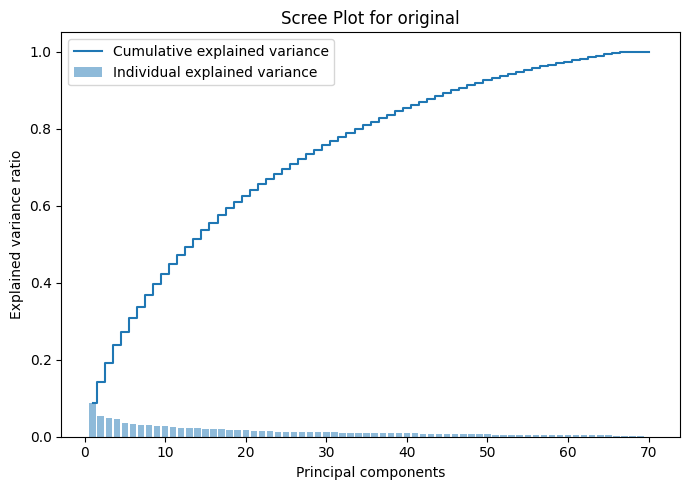

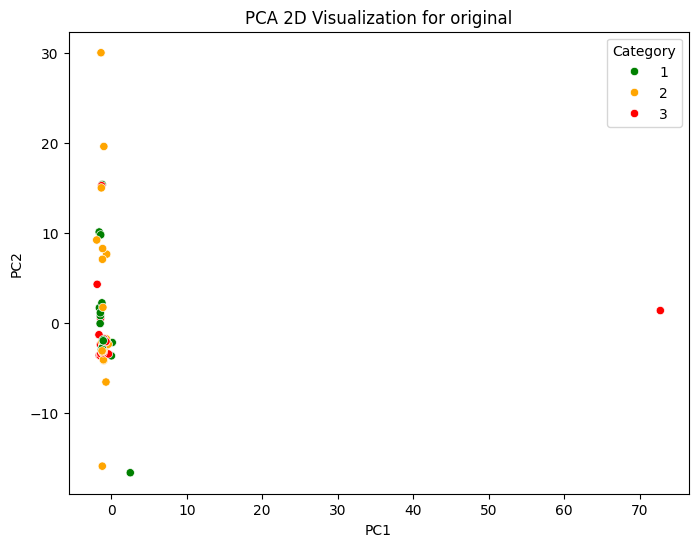

original_pipeline:


In [18]:
# Aply pipeline for visual results
results_original_pca= pca_pipeline(original, 'Category', n_components=2, dataset_name='original')

# Apply the pipeline for numerical results
original_pca_pipeline, df_pca_influence_original, explained_variance_original, n_components = apply_pipeline_pca(original, "original", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_original.head(10), explained_variance_original.head(10))

### original impressions:
   - original shows no aglomeration nor useful information which is expected the noise due to the large amount of data and features/sample ratio. However the first 50 features by influence will be taken to make up a dataframe to see if these data gives important information all together. New dataframe named original_pca and is composed of 51 features.
### original_pca: Making up a dataframe from the feature_influencers from pca results

In [19]:
df_pca_influence_columns = df_pca_influence_original["Features"].head(50).values.tolist()
original_pca = original[["Category"] + df_pca_influence_columns]

## 4.2. uniques: Computing PCA and Varianza -Scree Plots
selected data from the original only unique genera per category is in this dataframe of 343 genera.

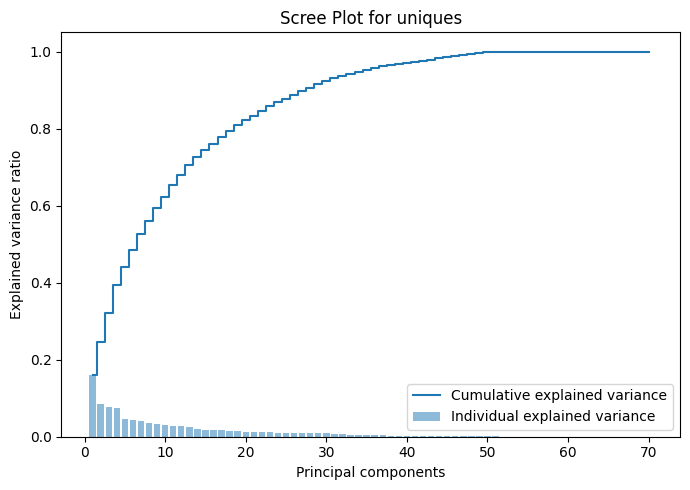

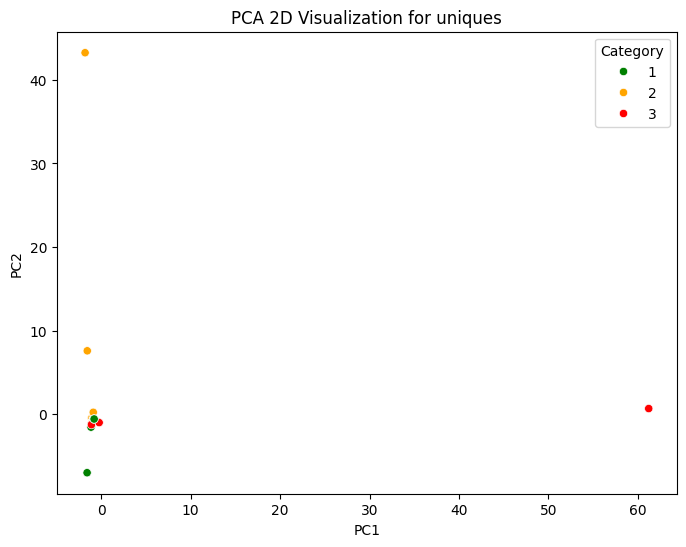

uniques_pipeline:


In [20]:
# Aply pipeline for visual results
results_uniques_pca = pca_pipeline(uniques, 'Category', n_components=2, dataset_name='uniques')

# Apply the pipeline for numerical results
uniques_pca_pipeline, df_pca_influence_uniques, explained_variance_uniques, n_components = apply_pipeline_pca(uniques, "uniques", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_uniques.head(10), explained_variance_uniques.head(10))

### uniques insides
The explained variance improves referent to original df but the pca plot show very little diferenciation. However the first 50 features by influence will be taken to make up a dataframe to see if these data gives important information all together. New dataframe named uniques_pca and is composed of 51 features.
### uniques_pca: Making up a dataframe from the feature_influencers from pca results

In [21]:
# print the genera from this pca to check #print(f"Genera uniques : {df_pca_influence['Features'].values.tolist()}")
print(*df_pca_influence_uniques['Features'].values.tolist())

704 87 238 442 649 201 211 680 690 578 621 160 696 190 457 361 594 396 240 123 857 85 494 558 132 635 436 46 410 477 427 399 244 571 122 698 22 287 382 239 576 856 406 412 645 872 225 636 104 78 355 511 541 372 580 242 879 547 385 496 2 50 446 142 499 642 548 803 793 458 778 301 672 710 105 468 459 409 498 726 539 464 612 5 97 524 159 544 288 293 348 448 450 492 131 407 340 256 418 552 583 208 478 839 713 515 106 298 513 435 667 221 815 345 215 665 326 262 877 220 303 133 346 342 138 840 860 849 779 682 403 593 527 25 476 14 80 10 21 333 203 693 170 673 177 213 252 119 439 485 381 291 15 116 16 60 772 823 824 115 545 825 814 861 70 59 93 579 799 826 472 798 692 188 788 452 763 517 76 63 868 62 363 827 836 835 792 795 834 833 790 852 185 832 797 810 776 738 786 756 806 782 781 811 501 61 222 473 516 366 241 874 187 176 536 679 755 780 54 71 56 764 58 744 283 791 619 846 749 505 623 774 502 700 264 624 383 813 353 67 821 629 57 689 568 73 559 818 842 838 320 773 493 850 837 447 753 19 78

In [22]:
df_pca_influence_columns = df_pca_influence_uniques["Features"].head(50).values.tolist()
uniques_pca = uniques[["Category"] + df_pca_influence_columns]

## 4.3. uniques23 Computing PCA and Varianza -Scree Plots
selected data from the original only unique genera per category is in this dataframe plus the common genera between 2 and 3 categories, contains 771 genera.

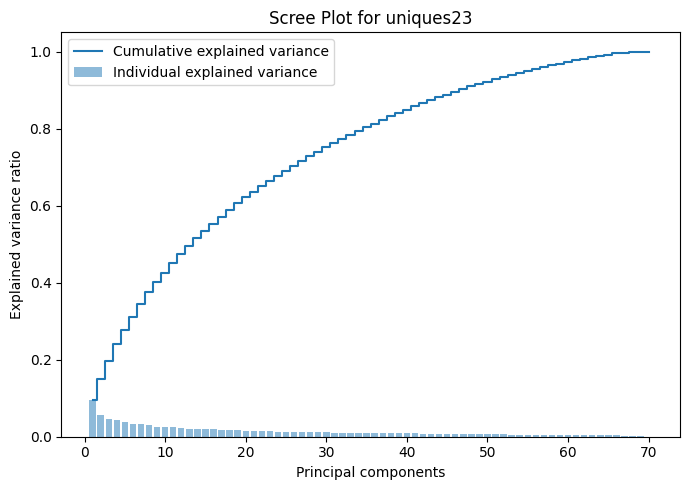

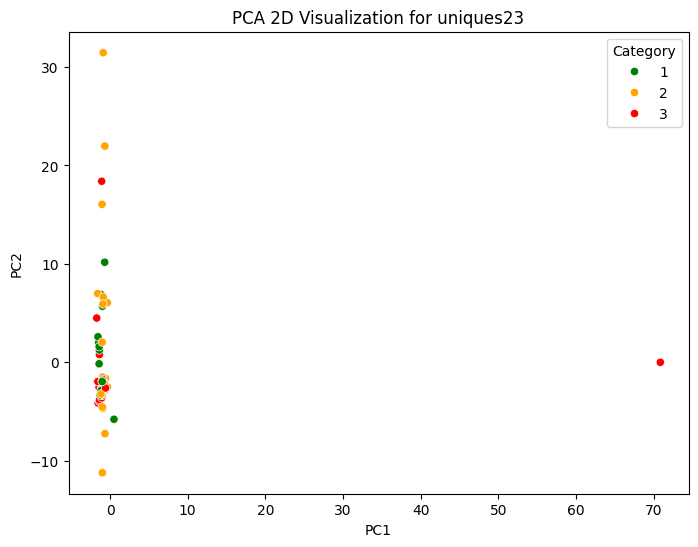

uniques23_pipeline:


In [23]:
# Aply pipeline for visual results
results_uniques23_pca = pca_pipeline(uniques23, 'Category', n_components=2, dataset_name='uniques23')

# Apply the pipeline for numerical results
uniques23_pca_pipeline, df_pca_influence_uniques23_pca, explained_variance_uniques23_pca, n_components = apply_pipeline_pca(uniques23, "uniques23", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_uniques23_pca.head(10), explained_variance_uniques23_pca.head(10))

### uniques23
The explained variance is worse than uniques df and the pca plot show very little diferenciation. Notive that some influencer genera that are in original_pca are also on unique_pca. The first 50 features by influence will be taken to make up a dataframe to see if these data gives important information all together. New dataframe named uniques23_pca and is composed of 51 features.
### uniques23_pca: Making up a dataframe from the feature_influencers from pca results

In [24]:
print(*df_pca_influence_uniques23_pca["Features"].head(50).values.tolist())

236 542 259 41 194 566 465 512 289 323 127 110 358 621 270 330 687 720 284 265 529 456 634 276 250 140 497 214 413 139 300 223 655 243 606 575 607 81 552 591 44 39 389 86 108 526 195 308 343 614


In [25]:
df_pca_influence_columns = df_pca_influence_uniques23_pca["Features"].head(50).values.tolist()
uniques23_pca = uniques23[["Category"] + df_pca_influence_columns]

## 4.4. Influencers_OLS: Computing PCA and Varianza -Scree Plots
selected data from the original with abundance threshold of 0,2% and frequency of 3, underwent selection of significance by OLS

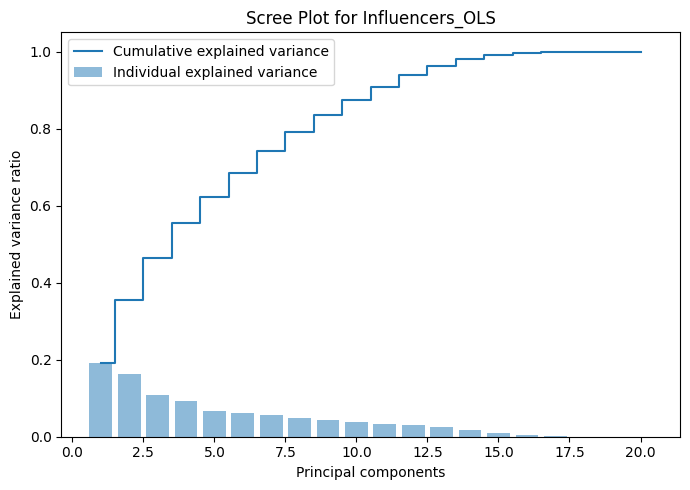

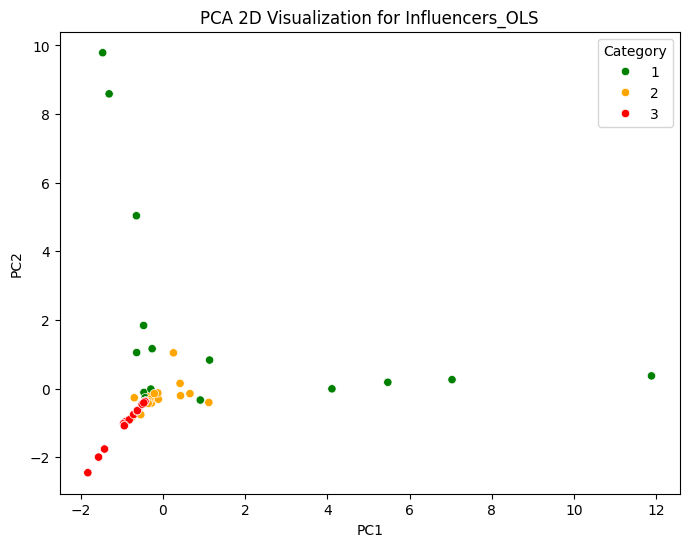

Influencers_OLS_pipeline:


In [26]:
# Aply pipeline for visual results
results_Influencers_OLS_pca = pca_pipeline(Influencers_OLS, 'Category', n_components=2, dataset_name='Influencers_OLS')
# Apply the pipeline for numerical results
Influencers_OLS_pca_pipeline, df_pca_influence_Influencers_OLS, explained_variance_Influencers_OLS, n_components = apply_pipeline_pca(Influencers_OLS, "Influencers_OLS", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_Influencers_OLS.head(10), explained_variance_Influencers_OLS.head(10))

### Influencers_OLS
   - This dataframe, representing the most influential genera both statistically and quantitatively, shows a clearer separation among the categories, especially between category 3 and 1.
   - Category 3 There is a clear regression trend in category 3
   - Category 2 dots align in the middle, indicating they share some characteristics with category 3 but also have distinct features.
   - Category 1 displays a 'v' shape, with category 3 forming the root, category 2 at the intersection, and the two arms of the 'Y' representing the spread of category 1. This pattern might indicate that category 1 encompasses a broader range of variance or interactions compared to the other categories.  

__Scree Plots:__ The Influencers_OLS dataset appears to decrease its explained variance more steeply compared to the OLS_all dataset.

## 4.5.  OLS_all: Computing PCA and Varianza -Scree Plots
selected data from the original underwent selection of significance by OLS.

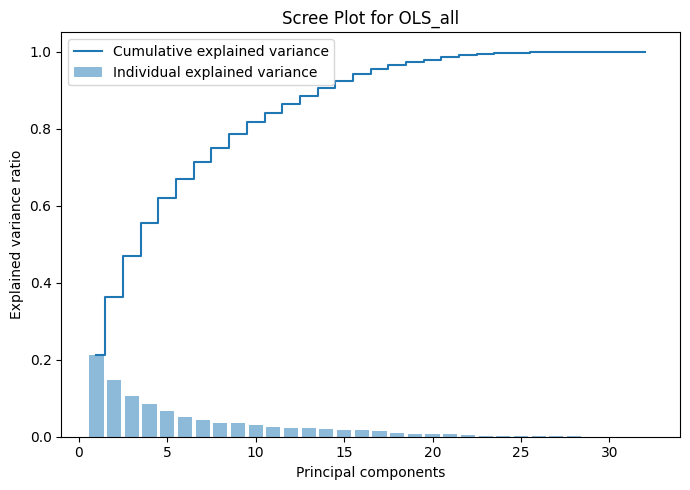

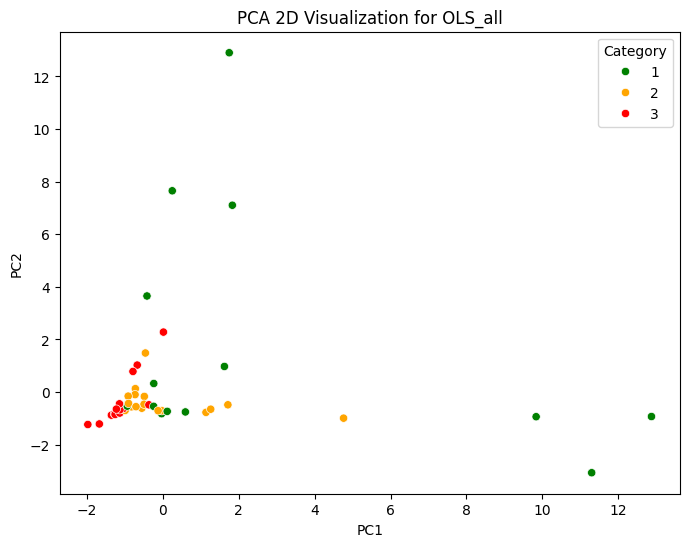

OLS_all_pipeline:


In [27]:
# Aply pipeline for visual results
Results_OLS_all_pca = pca_pipeline(OLS_all, 'Category', n_components=2, dataset_name='OLS_all')
# Apply the pipeline for numerical results
OLS_all_pca_pipeline, df_pca_influence_OLS_all, explained_variance_OLS_all, n_components = apply_pipeline_pca(OLS_all, "OLS_all", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_OLS_all.head(10), explained_variance_OLS_all.head(10))

### OLS_all
   - The scenario for the whole data is more intricate. The categories are not as distinctly separated, indicating a more complex interplay of features.
   - While category 1 also forms a 'Y' shape, the distinction is less clear due to the overlap with categories 2 and 3. This overlap suggests shared characteristics or interactions among the categories.

In both scree plots, OLS_all and Influencers_OLS a clear "elbow point" is observed around the 5th principal component. This suggests that retaining the first 5 components captures a significant portion of the variance in the data. However, Influencers_OLS seems to achieve a higher explanatory power with fewer features compared to OLS_all, moreover the differentiation on the labels makes this dataset more relevant. According to the principle of parsimony or Occam's Razor, which states that among competing hypotheses, the one with the fewest assumptions should be selected, in this case Influencers_OLS. Until the biological significance is not accounted for, the datasets are to be retained for comparison.

## 4.6. uniques_OLS Computing PCA and Varianza -Scree Plots
selected data from the original only Genera samples that do no share category were selected, posterior underwent selection of significance by OLS.

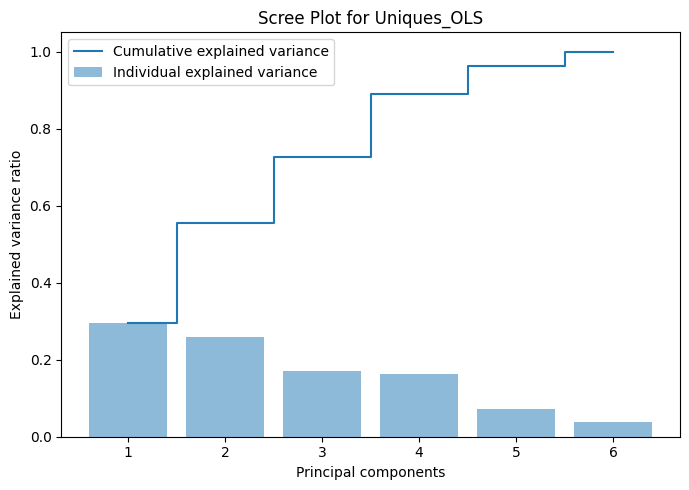

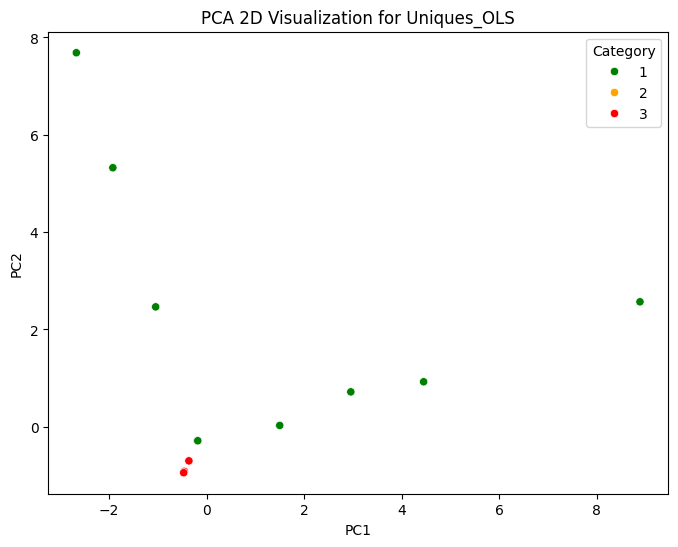

Uniques_OLS_pipeline:


In [28]:
# Aply pipeline for visual results
Results_uniques_OLS_pca = pca_pipeline(uniques_OLS, 'Category', n_components=2, dataset_name='Uniques_OLS')
# Apply the pipeline for numerical results
uniques_OLS_pca_pipeline, df_pca_influence_uniques_OLS, explained_variance_uniques_OLS, n_components = apply_pipeline_pca(uniques_OLS, "Uniques_OLS", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_uniques_OLS.head(10), explained_variance_uniques_OLS.head(10))

### uniques_OLS:
   - Uniques_OLS is compound of only 6 features and interestingly it shows the best differenciation on the pca of the components. Also the varianza increases from 0.2 on the previous dfs to 0.3 explained variance. Showing that this features can explain better the dataset in reference to the corrosion rick label.
   - The v shape of the category 1 is very clear and so is the lineal presence of category 3.  

## 4.7. uniques_23_OLS: Computing PCA and Varianza -Scree Plots
selected data from the original only Genera samples that do no share category were selected, plus the common genera from category 2 and 3, posterior underwent selection of significance by OLS.

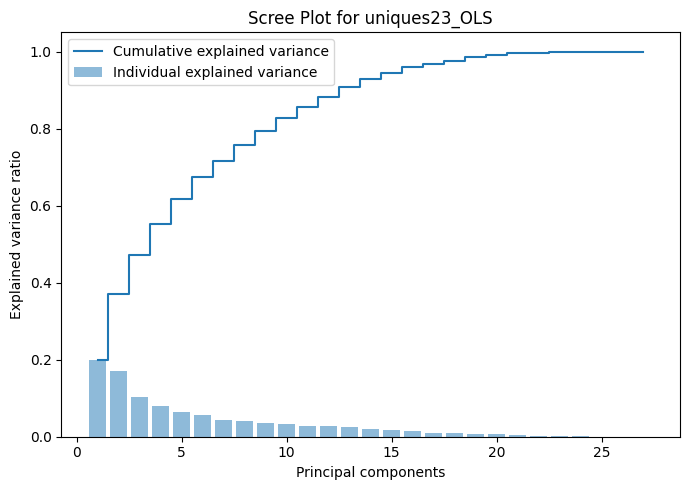

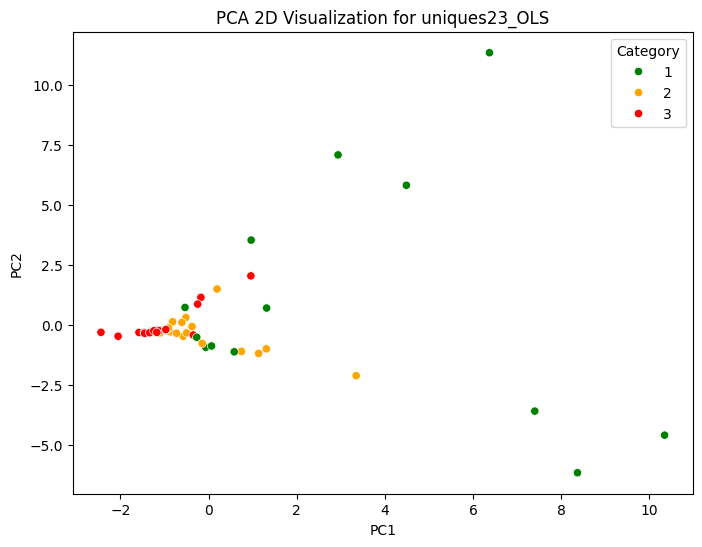

uniques23_OLS_pipeline:


In [29]:
# Aply pipeline for visual results
results_uniques23_OLS_pca = pca_pipeline(uniques23_OLS, 'Category', n_components=2, dataset_name='uniques23_OLS')
# Apply the pipeline for numerical results
uniques23_OLS_pca_pipeline, df_pca_influence_uniques23_OLS, explained_variance_uniques23_OLS, n_components = apply_pipeline_pca(uniques23_OLS, "uniques23_OLS", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_uniques23_OLS.head(10), explained_variance_uniques23_OLS.head(10))

### uniques23__OLS:
   - Uniques_23 is compose of more as 300 features and interestingly shows the worst differenciation blobs on the pca components. Also the varianza decreases from 0.3 on the previous df to 0.2 explained variance. Showing that this features have to be decreased in order to increase significance in reference to the corrosion rick label.
   - Category 1 has very clear separation similar to the previous dataframes, however 2 and 3 are overlaped yet feature 3 continues to present a lineal regresion between the two PC.

# 5. Pipelines Predictive Analysis
## 5.1 Pipeline for Regression script

The problem with the modeling at the moment is that the class 1 is dominating the whole scenario, so it is thought to remove the dominance features on class 1, so that the other features have more chance to be distintive. Which are class 1 markers?

In [181]:
def find_category_markers(df, target_category):
    """
    Find ASVs unique to target category with detailed metrics.
    """
    results = {}

    for feature in df.columns:
        if feature not in ['Sites', 'Category']:
            cat_data = df[df['Category'] == target_category][feature]
            other_data = df[df['Category'] != target_category][feature]

            if other_data.mean() == 0 and cat_data.mean() > 0:
                results[feature] = {
                    'mean': cat_data.mean(),
                    'samples_present': sum(cat_data > 0),
                    'values': cat_data[cat_data > 0].values
                }

    print(f"Category {target_category} markers:")
    for asv, stats in sorted(results.items(), key=lambda x: x[1]['mean'], reverse=True):
        print(f"ASV {asv}: mean={stats['mean']:.6f}, present in {stats['samples_present']} samples")
        print(f"Values: {stats['values']}")
        print("---")

    return results

In [182]:
 Class1 =  find_category_markers(original, 1)

Category 1 markers:
ASV 177: mean=1.604781, present in 1 samples
Values: [27.2812794]
---
ASV 679: mean=1.079412, present in 1 samples
Values: [18.35]
---
ASV 579: mean=0.097726, present in 1 samples
Values: [1.66134438]
---
ASV 673: mean=0.074492, present in 1 samples
Values: [1.26637239]
---
ASV 485: mean=0.068959, present in 1 samples
Values: [1.17229901]
---
ASV 798: mean=0.032291, present in 1 samples
Values: [0.54894302]
---
ASV 15: mean=0.014473, present in 1 samples
Values: [0.24603806]
---
ASV 391: mean=0.014022, present in 1 samples
Values: [0.23837902]
---
ASV 170: mean=0.010642, present in 1 samples
Values: [0.18091034]
---
ASV 213: mean=0.010642, present in 1 samples
Values: [0.18091034]
---
ASV 16: mean=0.007607, present in 1 samples
Values: [0.12931831]
---
ASV 814: mean=0.005123, present in 1 samples
Values: [0.08709192]
---
ASV 252: mean=0.004682, present in 1 samples
Values: [0.07960055]
---
ASV 693: mean=0.004257, present in 1 samples
Values: [0.07236414]
---
ASV 823

In [172]:
def debug_marker_detection(df, feature):
    class1_data = df[df['Category'] == 1][feature]
    other_data = df[df['Category'] != 1][feature]

    print(f"ASV {feature}:")
    print(f"Class 1 mean: {class1_data.mean():.6f}")
    print(f"Other classes mean: {other_data.mean():.6f}")
    print(f"Present in samples: {sum(class1_data > 0)}")

In [187]:
debugg_detect=  debug_marker_detection(original, 723)

ASV 723:
Class 1 mean: 0.243351
Other classes mean: 0.010836
Present in samples: 3


In [164]:
def find_class3_markers(df, label_column='risk_label'):
    class3_data = df[df[label_column] == 3]
    other_data = df[df[label_column] != 3]

    # Calculate mean abundances
    Class3_means = class3_data.mean()
    other_means = other_data.mean()

    # Calculate ratio of means
    abundance_ratio = Class3_means / other_means

    # Filter for ASVs with higher abundance in class 3
    potential_markers = abundance_ratio[abundance_ratio > 2].sort_values(ascending=False)

    print("Potential Class 3 markers:")
    for asv in potential_markers.index[:10]:
        print(f"{asv}: {potential_markers[asv]:.2f}x more abundant in class 3")


In [165]:
 Class3 = find_class3_markers(original, 'Category')

Potential Class 3 markers:
10: infx more abundant in class 3
505: infx more abundant in class 3
515: infx more abundant in class 3
527: infx more abundant in class 3
559: infx more abundant in class 3
560: infx more abundant in class 3
568: infx more abundant in class 3
578: infx more abundant in class 3
583: infx more abundant in class 3
593: infx more abundant in class 3


In [167]:
def verify_calculation(df, feature):
    """
    Verify abundance ratio calculation for a single feature
    """
    cat1_mean = df[df['Category'] == 1][feature].mean()
    cat2_mean = df[df['Category'] == 2][feature].mean()
    cat3_mean = df[df['Category'] == 3][feature].mean()

    print(f"ASV {feature} means:")
    print(f"Cat1: {cat1_mean:.4f}")
    print(f"Cat2: {cat2_mean:.4f}")
    print(f"Cat3: {cat3_mean:.4f}")

In [189]:
what_are_you_for_cat=  verify_calculation(original, 267)

ASV 267 means:
Cat1: 0.0183
Cat2: 0.9896
Cat3: 0.0679


In [36]:
def apply_pipeline_regressor(df, dataset_name):
    print(f"{dataset_name}_pipeline:")
    '''
    Pipeline for regression that handles the imbalanced data
    '''

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()

    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target Store original feature names and separate features and target
    feature_names = [col for col in df.columns if col not in ['Category', 'Sites']]
    X = df[feature_names]
    y = df['Category']

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Compute sample weights for the entire training set
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rf_mae_scores = []

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    for train_index, val_index in kf.split(X_train):
        # Split the current fold's train and validation sets
        X_train_fold, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val = y_train[train_index], y_train[val_index]

        # Compute sample weights for the current fold
        fold_weights = compute_sample_weight(class_weight='balanced', y=y_train_fold)

        # Train and predict with sample weights
        rf_pipeline.fit(X_train_fold, y_train_fold, rf__sample_weight=fold_weights)
        y_pred = rf_pipeline.predict(X_val)

        # Calculate and store MAE
        mae = round(mean_absolute_error(y_val, y_pred),4)
        rf_mae_scores.append(mae)

    print(f"Cross-Validation MAE Scores for RF: {rf_mae_scores}")
    print(f"Average MAE for RF: {round(np.mean(rf_mae_scores), 4)}")

    # Evaluate on the initial test split with sample weights
    rf_pipeline.fit(X_train, y_train, rf__sample_weight=sample_weights)
    y_test_pred = rf_pipeline.predict(X_test)

    # Evaluate the model
    mse = round(mean_squared_error(y_test, y_test_pred), 4)
    print(f'Mean Squared Error: {mse}')
    rmse = round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 4)
    print(f'Root Mean Squared Error: {rmse}')
    mae = round(mean_absolute_error(y_test, y_test_pred), 4)
    print(f'Mean Absolute Error: {mae}')

    # Extract feature importances from RandomForestRegressor
    feature_importances = rf_pipeline.named_steps['rf'].feature_importances_

    # Create a DataFrame to view the results
    df_importances_rf = pd.DataFrame({
        'Features': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print(f'Feature Importance by RF: {df_importances_rf.head(25)}')

    return rf_pipeline, df_importances_rf

* **MSE (Mean Squared Error):** Measures the average of the squares of the errors.
* __RMSE (Root Mean Squared Error):__ Square root of MSE. It's in the same units as the output variable and gives a higher penalty for larger errors.
* __MAE (Mean Absolute Error):__ Measures the average of the absolute errors.

## 5.2. Pipeline for Clasification script

In [37]:
def apply_classification_pipeline_classif(df, dataset_name):
    print(f"{dataset_name}_pipeline:")

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()

    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target  Store original feature names and separate features and target
    feature_names = [col for col in df.columns if col not in ['Category', 'Sites']]
    X = df[feature_names]
    y = df['Category']

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))

    # Reshape target variables for consistency
    y_train = y_train.values
    y_test = y_test.values

    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store performance metrics
    cv_accuracy_scores = []
    cv_precision_scores = []
    cv_recall_scores = []
    cv_f1_scores = []

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight=class_weight_dict  # Use computed class weights
        ))
    ])

    # Perform cross-validation
    for train_index, val_index in skf.split(X_train, y_train):
        # Split training data
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

        # Fit pipeline on training fold
        rf_pipeline.fit(X_fold_train, y_fold_train)

        # Predict on validation fold
        y_pred = rf_pipeline.predict(X_fold_val)

        # Calculate and store performance metrics
        cv_accuracy_scores.append(round(accuracy_score(y_fold_val, y_pred), 4))
        cv_precision_scores.append(round(precision_score(y_fold_val, y_pred, average='weighted'), 4))
        cv_recall_scores.append(round(recall_score(y_fold_val, y_pred, average='weighted'), 4))
        cv_f1_scores.append(round(f1_score(y_fold_val, y_pred, average='weighted'), 4))

    # Print cross-validation results
    print("Cross-Validation Metrics:")
    print(f"Accuracy: {cv_accuracy_scores}")
    print(f"Average Accuracy: {round(np.mean(cv_accuracy_scores), 4)}")
    print(f"Precision: {cv_precision_scores}")
    print(f"Average Precision: {round(np.mean(cv_precision_scores), 4)}")
    print(f"Recall: {cv_recall_scores}")
    print(f"Average Recall: {round(np.mean(cv_recall_scores), 4)}")
    print(f"F1-Score: {cv_f1_scores}")
    print(f"Average F1-Score: {round(np.mean(cv_f1_scores), 4)}")

    # Final model fit on entire training data
    rf_pipeline.fit(X_train, y_train)

    # Predict on test set
    y_test_pred = rf_pipeline.predict(X_test)

    # Confusion Matrix and Classification Report
    print("\nTest Set Evaluation:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Extract feature importances
    feature_importances = rf_pipeline.named_steps['rf'].feature_importances_

    # Create feature importance DataFrame
    df_importances_rf = pd.DataFrame({
        'Features': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print('\nFeature Importance:')
    print(df_importances_rf)

    return rf_pipeline, df_importances_rf

# 6. Results Predictive Analysis

## 6.1. original Regression and Classification

In [38]:
# Apply pipeline Regression
original_pca_pipeline_reg, df_importances_reg_original_pca= apply_pipeline_regressor(original_pca, "original_pca")
# Apply the pipeline Classification
original_pca_pipe_class, df_importances_original_pca = apply_classification_pipeline_classif(original_pca, "original_pca")

original_pca_pipeline:
Cross-Validation MAE Scores for RF: [0.6808, 0.9522, 0.597, 0.4395, 0.7379]
Average MAE for RF: 0.6815
Mean Squared Error: 0.3614
Root Mean Squared Error: 0.6012
Mean Absolute Error: 0.497
Feature Importance by RF:     Features  Importance
0        140      0.1133
17       526      0.1003
26       270      0.0916
20       323      0.0790
14       566      0.0741
10       491      0.0739
1        575      0.0572
12       727      0.0482
19       456      0.0357
9        474      0.0344
5        529      0.0342
25       591      0.0311
2        687      0.0309
34       455      0.0261
13        81      0.0192
18        86      0.0167
22       265      0.0166
42       155      0.0128
7        564      0.0123
31       607      0.0111
23       875      0.0094
4        300      0.0093
6        609      0.0087
38       606      0.0083
43       503      0.0079
original_pca_pipeline:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-Validation Metrics:
Accuracy: [0.5833, 0.3636, 0.6364, 0.5455, 0.5455]
Average Accuracy: 0.5349
Precision: [0.4826, 0.202, 0.6818, 0.3961, 0.5818]
Average Precision: 0.4689
Recall: [0.5833, 0.3636, 0.6364, 0.5455, 0.5455]
Average Recall: 0.5349
F1-Score: [0.511, 0.2597, 0.6508, 0.4589, 0.5424]
Average F1-Score: 0.4846

Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [1 4 2]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       0.50      0.57      0.53         7
           3       0.33      0.25      0.29         4

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.50        14
weighted avg       0.49      0.50      0.49        14


Feature Importance:
    Features  Importance
17       526      0.0878
10       491      0.0841
20       323      0.0775
1        575      0.0622
26       270      0.0584
2        687      0.0512
12   

### Original discussion
**Original_PCA_pipeline Regression**:
This pipeline shows moderate performance in regression and classification tasks. The Mean Absolute Error (MAE) is around 0.6756, with an average accuracy of 0.4571. The feature importance is distributed across multiple features, with features 323, 491, and 526 being the most significant. This pipeline does not seem to offer significant improvements over the existing pipelines.
**Original_pca_pipeline Classification**
Low cross-validation accuracy (0.4571) and inconsistent performance.
Class 1: Zero precision and recall, indicating an inability to classify this category.This pipeline is weaker than all of the others.

## 6.2. uniques_pca Regression and Classification

In [39]:
# Apply pipeline Regression
uniques_pca_pipeline_reg, df_importances_reg_uniques_pca= apply_pipeline_regressor(uniques_pca, "uniques_pca")
# Apply the pipeline Classification
uniques_pca_pipe_class, df_importances_uniques_pca = apply_classification_pipeline_classif(uniques_pca, "uniques_pca")

uniques_pca_pipeline:
Cross-Validation MAE Scores for RF: [0.5408, 0.7019, 0.4957, 0.3486, 0.6769]
Average MAE for RF: 0.5528
Mean Squared Error: 0.4413
Root Mean Squared Error: 0.6643
Mean Absolute Error: 0.4801
Feature Importance by RF:     Features  Importance
9        578      0.1765
22       494      0.1555
7        680      0.1222
5        201      0.0893
6        211      0.0690
0        704      0.0616
1         87      0.0574
23       558      0.0340
24       132      0.0339
4        649      0.0293
26       436      0.0266
25       635      0.0242
12       696      0.0196
43       412      0.0169
44       645      0.0126
11       160      0.0111
47       636      0.0098
10       621      0.0077
46       225      0.0076
45       872      0.0068
42       406      0.0065
2        238      0.0058
13       190      0.0041
48       104      0.0024
49        78      0.0021
uniques_pca_pipeline:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-Validation Metrics:
Accuracy: [0.5833, 0.5455, 0.4545, 0.5455, 0.4545]
Average Accuracy: 0.5167
Precision: [0.8438, 0.5568, 0.8182, 0.8295, 0.8636]
Average Precision: 0.7824
Recall: [0.5833, 0.5455, 0.4545, 0.5455, 0.4545]
Average Recall: 0.5167
F1-Score: [0.5822, 0.4897, 0.4242, 0.5449, 0.4779]
Average F1-Score: 0.5038

Test Set Evaluation:
Confusion Matrix:
[[3 0 0]
 [4 3 0]
 [3 0 1]]

Classification Report:
              precision    recall  f1-score   support

           1       0.30      1.00      0.46         3
           2       1.00      0.43      0.60         7
           3       1.00      0.25      0.40         4

    accuracy                           0.50        14
   macro avg       0.77      0.56      0.49        14
weighted avg       0.85      0.50      0.51        14


Feature Importance:
    Features  Importance
10       621      0.1156
2        238      0.0844
9        578      0.0666
49        78      0.0625
8        690      0.0570
31       399      0.0522
6  

### uniques_pca discussion
**uniques_PCA_pipeline Regression**:
Moderate average MAE (0.5302) but still higher than Influencers_OLS.
Feature importance concentrated on a few features (e.g., 418, 410, 578).This pipeline is slightly better than original_pca_pipeline but not as strong as Influencers_OLS.
**uniques_pca_pipeline Classification**
Moderate cross-validation accuracy (0.5714) but class imbalance issues.
Class 1: Zero precision and recall.
Class 2: Moderate precision and high recall.
Class 3: Perfect precision and recall but limited support. This pipeline is slightly better than original_pca_pipeline but still has significant class imbalance issues.

## 6.3. uniques23_pca Regression and Classification

In [40]:
# Apply pipeline Regression
uniques23_pca_pipeline_reg, df_importances_reg_uniques23_pca= apply_pipeline_regressor(uniques23_pca, "uniques23_pca")
# Apply the pipeline Classification
uniques23_pca_pipe_class, df_importances_uniques23_pca = apply_classification_pipeline_classif(uniques23_pca, "uniques23_pca")

uniques23_pca_pipeline:
Cross-Validation MAE Scores for RF: [0.6717, 0.8082, 0.4745, 0.3055, 0.6045]
Average MAE for RF: 0.5729
Mean Squared Error: 0.4195
Root Mean Squared Error: 0.6477
Mean Absolute Error: 0.5286
Feature Importance by RF:     Features  Importance
11       110      0.2010
25       140      0.1119
45       526      0.0788
5        566      0.0658
9        323      0.0650
14       270      0.0559
27       214      0.0518
21       456      0.0356
35       575      0.0333
16       687      0.0316
49       614      0.0309
29       139      0.0250
22       634      0.0239
37        81      0.0214
23       276      0.0199
39       591      0.0181
43        86      0.0153
18       284      0.0146
20       529      0.0136
34       606      0.0127
30       300      0.0088
36       607      0.0087
24       250      0.0079
19       265      0.0077
15       330      0.0065
uniques23_pca_pipeline:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-Validation Metrics:
Accuracy: [0.6667, 0.3636, 0.5455, 0.6364, 0.4545]
Average Accuracy: 0.5333
Precision: [0.6448, 0.2273, 0.5, 0.7121, 0.4864]
Average Precision: 0.5141
Recall: [0.6667, 0.3636, 0.5455, 0.6364, 0.4545]
Average Recall: 0.5333
F1-Score: [0.6377, 0.2797, 0.4394, 0.6228, 0.4646]
Average F1-Score: 0.4888

Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [1 5 1]
 [0 2 2]]

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       0.62      0.71      0.67         7
           3       0.67      0.50      0.57         4

    accuracy                           0.64        14
   macro avg       0.65      0.63      0.63        14
weighted avg       0.65      0.64      0.64        14


Feature Importance:
    Features  Importance
11       110      0.1111
45       526      0.0985
9        323      0.0762
29       139      0.0514
25       140      0.0505
49       614      0.0500
35    

### uniques23_pca discussion
**uniques_PCA_pipeline Regression**:
Higher average MAE (0.6247) and higher variability in MAE scores.
Feature importance distributed across multiple features. This pipeline does not offer significant improvements over the existing pipelines.
**uniques_pca_pipeline Classification**
Moderate cross-validation accuracy (0.5286) with consistent but low accuracy across folds.
Class 1: Perfect precision but very low recall.
Class 2: Moderate precision and high recall.
Class 3: Zero precision and recall. This pipeline has similar issues to the other pipelines, particularly with class imbalance.

Analysing the three new created dfs from the pca dimensionality reduction step. We see that The uniques_pca_pipeline shows the lowest MAE, indicating it performs best in terms of prediction error. The uniques_pca_pipeline also has the highest accuracy.
Each pipeline has slightly different top features.
original_pca_pipeline top features: 42 323 (0.1183), 27 491 (0.0882)
uniques23_pca_pipeline top features: 11 323 (0.1204), 15 491 (0.0754)
uniques_pca_pipeline top features: 10 418 (0.1997), 34 410 (0.1751)

## 6.4. Influencers_OLS Regression and Classification

In [41]:
# Apply pipeline Regression
Influencers_pipeline_reg, Importances_rf_Influencers_Influencers_OLS = apply_pipeline_regressor(Influencers_OLS, "Influencers_OLS")

# Apply the pipeline Classification
Influencers_pipe_class, importances_class_Influencers_OLS = apply_classification_pipeline_classif(Influencers_OLS, "Influencers_OLS")

Influencers_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.3458, 0.2718, 0.1827, 0.1818, 0.1764]
Average MAE for RF: 0.2317
Mean Squared Error: 0.1712
Root Mean Squared Error: 0.4137
Mean Absolute Error: 0.2443
Feature Importance by RF:     Features  Importance
16       549      0.5054
7        526      0.1972
11       864      0.0650
6        863      0.0444
14       408      0.0386
2        214      0.0251
19       229      0.0234
5         91      0.0228
10       625      0.0160
13       565      0.0145
15       334      0.0137
3        351      0.0136
4         23      0.0124
17       375      0.0056
8        584      0.0019
18       471      0.0005
12       678      0.0000
0        725      0.0000
1        871      0.0000
9        712      0.0000
Influencers_OLS_pipeline:
Cross-Validation Metrics:
Accuracy: [0.9167, 0.9091, 0.8182, 0.8182, 0.8182]
Average Accuracy: 0.8561
Precision: [0.9306, 0.9242, 0.8701, 0.8701, 0.8182]
Average Precision: 0.8826
Recall: [0.9167, 0.9091, 0

### Influencers_OLS Discussion
**Influencers_OLS Pipeline Regression:**
Cross-Validation MAE Scores for RF: Consistently lower and less variable (ranging from 0.1426 to 0.34) with a significantly lower average MAE (0.242).
Error Metrics:
MSE: 0.2618; RMSE: 0.5116; MAE: 0.34  

These metrics demonstrate improved prediction accuracy and model reliability compared to OLS_all. Feature importance is more concentrated, with feature 526 having an overwhelming impact (importance: 0.4318). Other features like 549 and 625 show noticeable contributions but to a lesser extent.

**Influencers_OLS_pipeline Classification:**
Performance Metrics:   
Cross-Validation Accuracy: 0.8286 (high and consistent across folds).  
Confusion Matrix:   
Class 1: Perfect precision but lower recall (misclassifications lead to only 67% recall).  
Class 2: High recall (100%) but lower precision (64%).   
Class 3: High precision (100%) but very low recall (25%), indicating many false negatives.  
Classification Report:  
Macro average recall (0.64) suggests unbalanced performance across classes.  
Weighted average metrics reflect an overall acceptable but not ideal model for classifying all categories equally well.  
Feature Importance:  
Feature 526 dominates (23.26%), followed by moderately impactful features like 549 and 864.  

## 6.5. OLS_all Regression and Classification

In [42]:
# Apply pipeline Regression
OLS_all_pipe_reg, importances_reg_OLS_all = apply_pipeline_regressor(OLS_all, "OLS_all")

# Apply the pipeline classification
OLS_all_pipe_class, importances_class_OLS_all = apply_classification_pipeline_classif(OLS_all, "OLS_all")

OLS_all_pipeline:
Cross-Validation MAE Scores for RF: [0.7, 0.7109, 0.3736, 0.2518, 0.4764]
Average MAE for RF: 0.5025
Mean Squared Error: 0.3518
Root Mean Squared Error: 0.5931
Mean Absolute Error: 0.45
Feature Importance by RF:     Features  Importance
29       549      0.4051
6         23      0.0816
4        470      0.0703
3        214      0.0678
27       140      0.0678
31       229      0.0522
10       584      0.0452
14       625      0.0387
26       334      0.0242
1        871      0.0186
7         91      0.0179
23       565      0.0149
25        92      0.0139
22       605      0.0131
21       678      0.0126
0        725      0.0125
5         79      0.0071
8         88      0.0067
11       712      0.0067
24       426      0.0041
2        428      0.0040
9        480      0.0037
15       337      0.0036
30       771      0.0024
19       342      0.0019
OLS_all_pipeline:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Cross-Validation Metrics:
Accuracy: [0.5833, 0.3636, 0.5455, 0.5455, 0.7273]
Average Accuracy: 0.553
Precision: [0.5278, 0.202, 0.3961, 0.4091, 0.6623]
Average Precision: 0.4395
Recall: [0.5833, 0.3636, 0.5455, 0.5455, 0.7273]
Average Recall: 0.553
F1-Score: [0.553, 0.2597, 0.4589, 0.4615, 0.6685]
Average F1-Score: 0.4803

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [0 4 3]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.44      0.57      0.50         7
           3       0.25      0.25      0.25         4

    accuracy                           0.43        14
   macro avg       0.56      0.38      0.42        14
weighted avg       0.51      0.43      0.43        14


Feature Importance:
    Features  Importance
29       549      0.1605
3        214      0.1094
31       229      0.1005
6         23      0.0627
4        470      0.0526
27       140      0.0521
7      

## OLS_all Discussion
**OLS_all_pipeline regression:**
Cross-Validation MAE Scores for RF: Higher variability across folds (ranging from 0.3935 to 0.6886) and a higher average MAE (0.5725) suggest that the model's predictive performance is less consistent.
Error Metrics:
Mean Squared Error (MSE): 0.3921; Root Mean Squared Error (RMSE): 0.6262;Mean Absolute Error (MAE): 0.5634
These metrics indicate lower prediction accuracy compared to the Influencers_OLS pipeline.
**Importance** is more evenly distributed, with no single feature dominating.
Top features (e.g., feature 549, 23, and 625) exhibit moderate importance values (0.1883, 0.1233, 0.0887).

**OLS_all_pipeline classification:**
Performance Metrics:   
Cross-Validation Accuracy: 0.4714 (significantly lower, inconsistent across folds).  
Confusion Matrix:   
Class 1: Perfect precision but extremely low recall (17%), with many false negatives.   
Class 2: Moderate precision (45%) and high recall (83%), indicating a focus on this class.  
Class 3: Zero precision and recall, indicating an inability to classify this category.  
Classification Report:   
Macro and weighted averages are much lower than Influencers_OLS, indicating an overall weaker model.  
Feature Importance:   
Importance is more distributed but lower overall contributions compared to Influencers_OLS.   

## 6.6. uniques_OLS Regression and Classification

In [43]:
# Apply pipeline Regression
uniques_pipeline, importances_reg_uniques_OLS = apply_pipeline_regressor(uniques_OLS, "Uniques_OLS")
# Apply the pipeline Classification
uniques_pipe_class, importances_class_uniques_OLS = apply_classification_pipeline_classif(uniques_OLS, "unique_OLS")

Uniques_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.6302, 0.6662, 0.5366, 0.3111, 0.6006]
Average MAE for RF: 0.5489
Mean Squared Error: 0.4244
Root Mean Squared Error: 0.6515
Mean Absolute Error: 0.4848
Feature Importance by RF:    Features  Importance
0       541      0.3850
3       342      0.3199
2       201      0.2007
1       494      0.0626
5       799      0.0319
4       410      0.0000
unique_OLS_pipeline:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Cross-Validation Metrics:
Accuracy: [0.5, 0.4545, 0.4545, 0.6364, 0.6364]
Average Accuracy: 0.5364
Precision: [0.5227, 0.2066, 0.2066, 0.798, 0.4343]
Average Precision: 0.4336
Recall: [0.5, 0.4545, 0.4545, 0.6364, 0.6364]
Average Recall: 0.5364
F1-Score: [0.3937, 0.2841, 0.2841, 0.5974, 0.5065]
Average F1-Score: 0.4132

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [0 7 0]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.58      1.00      0.74         7
           3       1.00      0.25      0.40         4

    accuracy                           0.64        14
   macro avg       0.86      0.53      0.55        14
weighted avg       0.79      0.64      0.59        14


Feature Importance:
   Features  Importance
0       541      0.3192
3       342      0.2839
2       201      0.2149
1       494      0.1226
5       799      0.0595
4       410      0.0000


### uniques_OLS Discussion
**uniques_OLS_pipeline Regression:**
Cross-Validation MAE Scores for RF: Higher variability (range 0.3783–0.7313) and a comparable average MAE (0.572).  
Error Metrics:  
MSE: 0.7412 ; RMSE: 0.8609 ; MAE: 0.7313 (relatively high).  These metrics are slightly higher than those of the unique23 pipeline, suggesting a slightly higher level of error.
These metrics reflect suboptimal predictive performance compared to other datasets.  
Feature Importance:   
Importance is relatively concentrated among the top three features (541: 0.2426, 342: 0.2327, 410: 0.2050), suggesting a model reliant on a few key variables.  
**uniques_OLS_pipeline Classification:**
Cross-Validation Accuracy Scores for RF:
The accuracy scores range from 0.4286 to 0.7143, with an average accuracy of 0.5429. This is slightly better than the unique23 pipeline but still shows variability.
Confusion Matrix and Classification Report:
Class 1: Zero precision and recall, indicating all instances of this class are misclassified.
Class 2: Perfect precision and recall for the instances classified, but the confusion matrix suggests many instances are not classified correctly.
Class 3: Zero precision and recall, similar to Class 1.
Features 229 and 214 have the highest importance (0.1008 and 0.0947, respectively), followed by features 549, 23, and 140. Distribution similar to the uniques23.

## 6.7. uniques_23_OLS Regression and Classification

In [44]:
# Apply pipeline Regression
unique_23_OLS_pipeline_rg, importances_rf_uniques23_OLS= apply_pipeline_regressor(uniques23_OLS, "unique23_OLS")
# Apply the pipeline Classification
# Apply the pipeline the working df
uniques23_pipe_class, importances_class_uniques23_OLS = apply_classification_pipeline_classif(uniques23_OLS, "unique23_OLS")

unique23_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.7033, 0.7282, 0.3764, 0.2709, 0.5136]
Average MAE for RF: 0.5185
Mean Squared Error: 0.3634
Root Mean Squared Error: 0.6028
Mean Absolute Error: 0.4593
Feature Importance by RF:     Features  Importance
25       549      0.4159
4        470      0.0794
5         23      0.0774
24       140      0.0710
3        214      0.0699
26       229      0.0560
9        584      0.0409
12       625      0.0379
22       334      0.0244
1        871      0.0225
6         91      0.0171
20       565      0.0144
19       605      0.0128
18       678      0.0125
0        725      0.0102
21       426      0.0066
7         88      0.0065
2        428      0.0043
13       337      0.0042
10       712      0.0041
16       342      0.0037
8        480      0.0031
11       799      0.0022
14       541      0.0021
15       494      0.0009
unique23_OLS_pipeline:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-Validation Metrics:
Accuracy: [0.5, 0.3636, 0.6364, 0.5455, 0.6364]
Average Accuracy: 0.5364
Precision: [0.4603, 0.202, 0.4667, 0.4091, 0.6364]
Average Precision: 0.4349
Recall: [0.5, 0.3636, 0.6364, 0.5455, 0.6364]
Average Recall: 0.5364
F1-Score: [0.4683, 0.2597, 0.5351, 0.4615, 0.6222]
Average F1-Score: 0.4694

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [0 4 3]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.44      0.57      0.50         7
           3       0.25      0.25      0.25         4

    accuracy                           0.43        14
   macro avg       0.56      0.38      0.42        14
weighted avg       0.51      0.43      0.43        14


Feature Importance:
    Features  Importance
25       549      0.1660
3        214      0.1063
26       229      0.0870
4        470      0.0743
24       140      0.0646
5         23      0.0620
6         

### uniques23_OLS Discussion
**unique23_OLS_pipeline Regression**:
Cross-Validation MAE Scores for RF: Less variability (range 0.3867–0.72) and slightly higher average MAE (0.5751).
Error Metrics:
MSE: 0.3868 ; RMSE: 0.622 ; MAE: 0.5623 (lower than uniques_OLS).These metrics indicate better performance than uniques_OLS, possibly due to the model leveraging a larger pool of features.

**Feature importance** is more evenly distributed across top contributors (e.g., 549: 0.1899, 23: 0.1025, 625: 0.0889). High-dimensionality could contribute to complexity but might also capture subtle interactions.  
**unique23_OLS_pipeline Classification**:
Cross-Validation Accuracy Scores for RF:
The accuracy scores range from 0.3571 to 0.5714, with an average accuracy of 0.4429. This indicates a moderate level of classification accuracy with significant variability.
Confusion Matrix and Classification Report:
Class 1: Perfect precision but very low recall (0.17), indicating many false negatives.
Class 2: Moderate precision (0.45) and high recall (0.83).
Class 3: Zero precision and recall, indicating all instances of this class are misclassified. Macro average recall is 0.33, suggesting unbalanced performance across classes.
Feature Importance:
Feature 229 has the highest importance (0.1008), followed by features 214, 549, 23, and 140. This indicates a spread of importance across several features.

**unique_23_OLS_pipeline** achieves slightly better predictive accuracy despite higher dimensionality, possibly due to capturing more complex interactions, performs better numerically. Suggesting that the dataset's complexity adds value despite reduced interpretability.
**uniques_OLS_pipeline**, though concise, has poorer error metrics, indicating potential underfitting or missing interactions and struggles with predictive accuracy.

## 6.8. Sumarizing Regression and Classification Pipelines Results
### Analysing the models Regression and Classification.
Both pipelines struggle with class imbalance, leading to poor performance on certain classes.
Feature importance is similar but with slight variations, suggesting that the same set of features is important for classification in both pipelines.

# 7. Integration of Dataframes
**Integrating Influencers_OLS and uniques_OLS**
So analysing the Influencers_OLS results it is seen that it clasify well class 1 and 3, however having fewer members of class 1, and uniques_OLS is a small dataframe that shows good classification on class 1. So the join of the two will be check. It is comprised of 27 genera.
**Integrating OLS_all and uniques_OLS**
This is likely better option because uniques_OLS has shown better performance in classifying Class 1, which is a weakness in OLS_all_pipeline. The feature importance distribution and the strengths in classifying Class 1 make it a good complement. However looking at the merge of the two of them, there is no need to join them since uniques is part of all.

In [45]:
# Merging the dataframes OLS_all and uniques_OLS on idex "Sites
all_uniques= pd.merge(OLS_all, uniques_OLS, left_index=True, right_index=True, suffixes =('_all', '_uniques'))
# Drop any duplicate columns
all_uniques= all_uniques.loc[:, ~all_uniques.columns.duplicated()]
all_uniques= all_uniques.drop(columns="Category_uniques")
all_uniques = all_uniques.rename(columns={"Category_all" : "Category"})
all_uniques.columns

Index([   'Category',           725,           871,           428,
                 214,           470,            79,            23,
                  91,            88,           480,           584,
                 712,            90,     '799_all',           625,
                 337,     '541_all',     '494_all',           657,
           '342_all',     '410_all',           678,           605,
                 565,           426,            92,           334,
                 140,     '201_all',           549,           771,
                 229, '541_uniques', '494_uniques', '201_uniques',
       '342_uniques', '410_uniques', '799_uniques'],
      dtype='object')

# 7.1. Influencers_uniques

In [46]:
# Ensure that the Sites index is sorted properly
Influencers_OLS = Influencers_OLS.sort_index(key=lambda x: x.str.extract('(\d+)', expand=False).astype(str))
uniques_OLS = uniques_OLS.sort_index(key=lambda x: x.str.extract('(\d+)', expand=False).astype(str))
# Merging the dataframes Influencers_OLS and uniques_OLS on idex "Sites
Influencers_uniques= pd.merge(Influencers_OLS, uniques_OLS, left_index=True, right_index=True, suffixes =('_Influencers', '_uniques'))
# Drop any duplicate columns
Influencers_uniques= Influencers_uniques.loc[:, ~Influencers_uniques.columns.duplicated()]
Influencers_uniques= Influencers_uniques.drop(columns="Category_uniques")
Influencers_uniques = Influencers_uniques.rename(columns={"Category_Influencers" : "Category"})
Influencers_uniques = Influencers_uniques.reset_index()
Influencers_uniques = Influencers_uniques.astype({"Sites": str, "Category": int})
Influencers_uniques = Influencers_uniques.set_index("Sites")

## Influencers_uniques: PCA, Regression and Classification

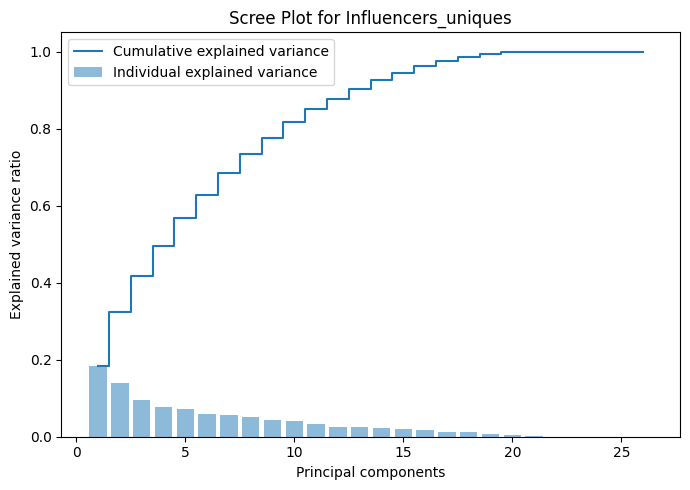

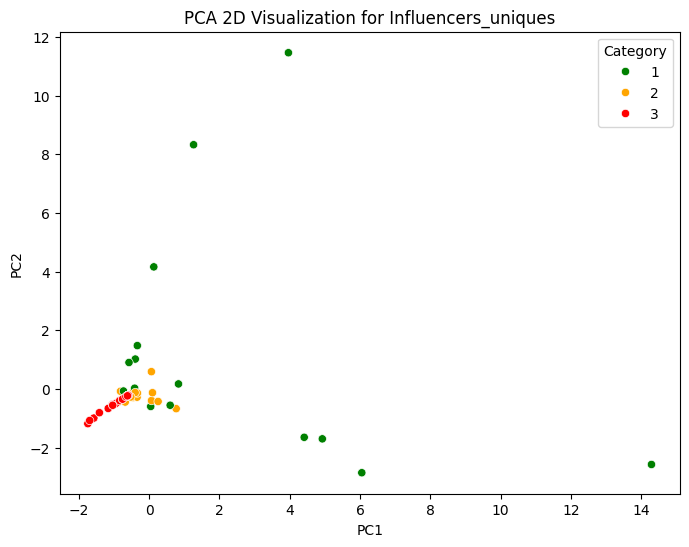

Influencers_uniques_pipeline:


Influencers_uniques_pipeline:
Cross-Validation MAE Scores for RF: [0.345, 0.2718, 0.1773, 0.1791, 0.1664]
Average MAE for RF: 0.2279
Mean Squared Error: 0.1715
Root Mean Squared Error: 0.4141
Mean Absolute Error: 0.2471
Feature Importance by RF:     Features  Importance
16       549      0.5109
7        526      0.1998
11       864      0.0651
6        863      0.0466
14       408      0.0360
19       229      0.0248
2        214      0.0243
4         23      0.0231
5         91      0.0209
3        351      0.0140
10       625      0.0138
13       565      0.0091
15       334      0.0085
18       471      0.0027
8        584      0.0003
22       201      0.0001
12       678      0.0000
17       375      0.0000
0        725      0.0000
1        871      0.0000
23       342      0.0000
21       494      0.0000
20       541      0.0000
24       410      0.0000
9        712      0.0000
Influencers_uniques_pipeline:
Cross-Validation Metrics:
Accuracy: [0.8333, 0.9091, 0.7273, 0.8182, 0.818

In [47]:
# Aply pipeline for visual results
results_Influencers_uniques_pca = pca_pipeline(Influencers_uniques, 'Category', n_components=2, dataset_name='Influencers_uniques')

# Apply the pipeline for numerical results
Influencers_uniques_pipeline, df_pca_influence_Influencers_uniques, explained_variance_Influencers_uniques, n_components = apply_pipeline_pca(Influencers_uniques, "Influencers_uniques", n_components=2, n_top_features=50)

# Display the data side by side
display_side_by_side(df_pca_influence_Influencers_uniques.head(10), explained_variance_Influencers_uniques.head(10))

# Apply pipeline Regression
Influencers_uniques_pipeline_reg, importances_reg_Influencers_uniques= apply_pipeline_regressor(Influencers_uniques, "Influencers_uniques")
# Apply the pipeline Classification
Influencers_uniques_pipe_class, importances_class_Influencers_uniques = apply_classification_pipeline_classif(Influencers_uniques, "Influencers_uniques")

### Influencers_uniques Discussion
**Influencers_uniques pipeline Regression**:
The model is performing well with low MAE variability, ranging from 0.1415 to 0.3307 and an average MAE of 0.24. Compared to previous datasets (like uniques_OLS_pipeline where the variability was higher), this suggests an improved and more reliable model.
MSE (0.2523) and RMSE (0.5022) indicate moderate error levels, which suggest the model is performing reasonably well in terms of prediction accuracy. These are substantially better than earlier models where error levels were high.
**Feature importance**
Feature 526 stands out as the most significant with an importance score of 0.4293, followed by feature 549 at 0.2017. These scores point to a few dominating features, which aligns with my future approach of combining the most influential features across datasets. This can potentially improve both feature selection and model generalization when merged. Indeed, the features indicate a focus on a few predictors that contribute heavily to the outcome. This could be useful when aim to reduce features but still retain biologically relevant ones.  
**Influencers_uniques_pipeline Classification**:
Cross-Validation Accuracy: This model achieved an average classification accuracy of 0.9571, which is quite strong. The relatively high accuracy, along with a well-balanced confusion matrix, suggests that the model can differentiate well across the three categories.  Confusion Matrix & Classification Report:
    Class 1: Precision is perfect (1.0), but recall suffers (0.67), indicating that there may be a misclassification problem with certain examples.
    Class 2: High recall (1.0), but lower precision (0.78), meaning the model is good at catching all instances of Class 2 but sometimes incorrectly classifies other categories as Class 2.
    Class 3: Very high precision (1.0) but lower recall (0.75), indicating some false negatives are present, but the classification of class 3 is still accurate when it happens.

This classification model is performing fairly well but could be further refined, especially in terms of recall for classes 1 and 3, perhaps with tweaks in model parameters.Feature Importance: The top three most important features (526, 549, and 864) once again highlight a few dominating predictors. These feature priorities would be the core of my focus, moving forward into the feature selection across datasets using biological relevance.

Influencers_uniques regression performance is improving with reduced error and a more concentrated feature importance distribution. This is promising for further refinement. The classification performance suggests some room for improvement, particularly in balancing recall and precision across classes, especially for Class 1 and 3. Combining datasets with influential features and considering their biological relevance for dimensionality reduction is an effective way forward.
Feature selection based on importance, variance, and biological significance will help ensure the model remains robust while simplifying feature sets.

# 7.2. Merged_df: Combining Dataframes  
The dataframes with a significant degree of importance for the next phase will be retained. Uniques_OLS has already been combined to create Influencers_uniques. The original features' PCA performance may provide valuable insights into predicting overall behavior and will be carried forward as original_pca. However, dataframes such as uniques_pca, uniques23_pca, uniques23_OLS, and original do not demonstrate notable contributions toward improving the models. As a result, they will be dropped in this notebook after extracting their three most important features. The dataframe OLS_all will undergo further processing in the subsequent steps.
In order to get the most important Features that make up the dfs that will be discarded, the dfs will be join together and passed through the pipelines of this notebook, then we will have another df "mergers"

|DataFrame|   Genera ID   |
|---|  ---|
|original_pca|270 727 151 474 687 418 663 201 564 41 552 148 487 155 607 223 18 865 254 308 227 574 526 81 639 367 172 491 166 660 585 145 108 705 733 584 250 341 561 271 84 300 323 211 259 229 551 670 373 269  
|uniques_pca |190 578 160 696 457 594 361 123 240 396 418 680 201 87 704 649 427 477 46 78 355 511 385 2 242 879 571 698 244 122 22 639 367 197 410 85 436 635 558 132 494 636 872 225 104 621 239 576 382 856
|uniques23_pca|270 41 526 172 865 151 300 18 552 487 474 323 663 687 108 491 148 574 250 86 373 535 245 127 308 561 214 276 660 155 455 563 330 269 575 81 254 484 551 271 607 194 140 709 566 529 497 572 389 200 |
|uniques23_OLS|725 871 428 214 470 23 91 88 480 584 712 799 625 337 541 494 342 410 678 605 565 426 334 201 140 549 229  |
|OLS_all |725 871 428 214 470 79 23 91 88 480 584 712 90 799 625 337 541 494 657 342 410 678 605 565 426 92 334 140 201 549 771 229  |



### Merging DataFrames
Merging all dataframes, except Influencers_uniques on a single dataframe

In [48]:
original.head(2)

Category      1      2      3      4      5      6      7      8  \
Sites                                                                      
site_1         3 0.0000 0.0000 0.0000 0.0000 0.0000 0.4308 0.5170 0.0000   
site_2         1 0.0000 0.0000 0.0000 0.0000 0.0000 0.0190 0.3415 0.0000   

            9  ...    873    874    875    876    877    878    879    880  \
Sites          ...                                                           
site_1 0.0000  ... 0.0000 0.0000 0.0000 0.0215 0.0000 0.0000 0.0000 0.0000   
site_2 0.0000  ... 0.0190 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

          881    882  
Sites                 
site_1 0.0215 0.0000  
site_2 0.0190 0.0000  

[2 rows x 883 columns]

In [49]:
# Colecting all columns names and ensure column names are all strings, strip and standardize)
original_columns = ['Category'] + [int(str(col).strip()) for col in original.columns[1:]]
original_pca_columns = ['Category'] + [int(str(col).strip()) for col in original_pca.columns[1:]]
uniques_pca_columns = ['Category'] + [int(str(col).strip()) for col in uniques_pca.columns[1:]]
uniques23_pca_columns = ['Category'] + [int(str(col).strip()) for col in uniques23_pca.columns[1:]]
uniques23_OLS_columns = ['Category'] + [int(str(col).strip()) for col in uniques23_OLS.columns[1:]]
OLS_all_columns = ['Category'] + [int(str(col).strip()) for col in OLS_all.columns[1:]]

In [50]:
# Combine and deduplicate
merged_columns = list(set(original_pca_columns +
                          uniques_pca_columns +
                          uniques23_pca_columns +
                          uniques23_OLS_columns +
                          OLS_all_columns))

numeric_columns = [col for col in merged_columns if col != 'Category']
df_numeric = original[numeric_columns]
df_category = original[['Category']]
Merged_df = pd.concat([df_category, df_numeric], axis=1)

print(f"Number of features in merged_df: {Merged_df.shape[1]}")

Number of features in merged_df: 145


In [51]:
Merged_df.head()

Category    512    516     13    526    529     22     23    541  \
Sites                                                                      
site_1         3 0.0000 0.0000 0.0000 0.1508 0.0215 0.0000 0.2801 0.0000   
site_2         1 0.0000 0.0000 0.0000 0.7020 0.0000 0.0000 1.2332 0.0000   
site_3         1 0.0000 0.0000 0.0000 0.2210 0.0123 0.0000 0.3069 0.0123   
site_4         1 0.0000 0.0000 0.0000 0.7096 0.0066 0.0000 2.2016 0.0220   
site_5         1 0.0000 0.0000 0.0000 0.1822 0.0110 0.0000 0.9148 0.0000   

          542  ...    457    465    470    474    477    480    491    494  \
Sites          ...                                                           
site_1 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0862 0.0000   
site_2 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0759 0.0000   
site_3 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0123 0.2210 0.0000   
site_4 0.0000  ... 0.0000 0.0044 0.0000 0.0000 0.0000 0.0000 0.0397 0.0022   
site_5 0.0000  ... 0.0000 0.0000 0.0018 0.0000 0.0018 0.0000 0.0939 0.0000   

          497    503  
Sites                 
site_1 0.0000 0.0000  
site_2 0.0000 0.0000  
site_3 0.0000 0.0000  
site_4 0.0000 0.0000  
site_5 0.0000 0.0074  

[5 rows x 145 columns]

## Merged_df: PCA, Regression and Classification

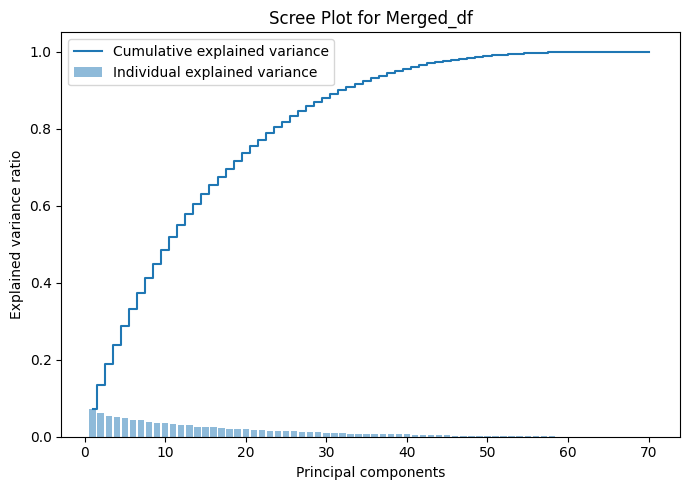

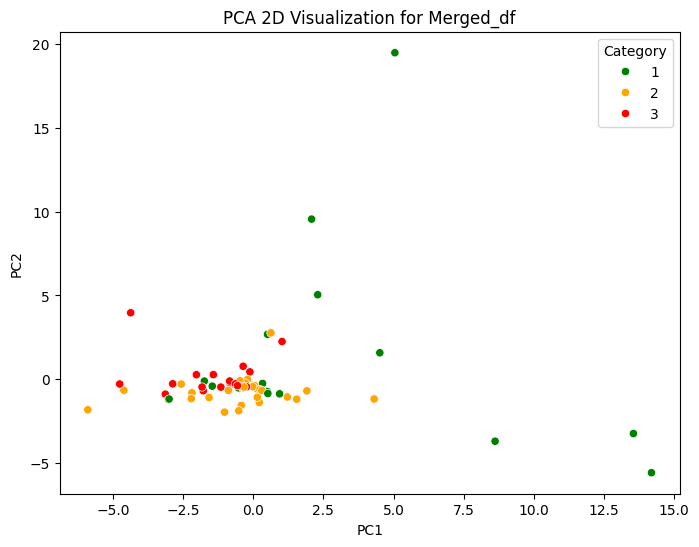

Merged_df_pipeline:


Merged_df_pipeline:
Cross-Validation MAE Scores for RF: [0.6675, 0.7645, 0.4855, 0.3055, 0.5891]
Average MAE for RF: 0.5624
Mean Squared Error: 0.2942
Root Mean Squared Error: 0.5424
Mean Absolute Error: 0.4186
Feature Importance by RF:      Features  Importance
11        549      0.3503
98        270      0.0582
47        110      0.0472
106       323      0.0458
59        140      0.0440
3         526      0.0429
136       470      0.0408
6          23      0.0270
140       491      0.0253
82        214      0.0247
48        625      0.0203
108       334      0.0146
133       456      0.0139
20        566      0.0137
68        687      0.0126
94        250      0.0121
53        634      0.0113
43        614      0.0105
132       455      0.0095
87        229      0.0092
83        727      0.0086
143       503      0.0085
4         529      0.0080
115       871      0.0076
37         92      0.0073
Merged_df_pipeline:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-Validation Metrics:
Accuracy: [0.5833, 0.4545, 0.5455, 0.6364, 0.7273]
Average Accuracy: 0.5894
Precision: [0.4826, 0.2273, 0.4091, 0.7121, 0.7636]
Average Precision: 0.5189
Recall: [0.5833, 0.4545, 0.5455, 0.6364, 0.7273]
Average Recall: 0.5894
F1-Score: [0.511, 0.303, 0.4615, 0.6228, 0.7273]
Average F1-Score: 0.5251

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [1 4 2]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.33      0.40         3
           2       0.44      0.57      0.50         7
           3       0.33      0.25      0.29         4

    accuracy                           0.43        14
   macro avg       0.43      0.38      0.40        14
weighted avg       0.42      0.43      0.42        14


Feature Importance:
     Features  Importance
11        549      0.0763
140       491      0.0524
47        110      0.0477
106       323      0.0386
3         526      0.0363
..        ...         ..

In [52]:
# Aply pipeline for visual results
results_Merged_df_pca = pca_pipeline(Merged_df, 'Category', n_components=2, dataset_name='Merged_df')

# Apply the pipeline for numerical results
Merged_df_pipeline, df_pca_influence_Merged_df, explained_variance_Merged_df, n_components = apply_pipeline_pca(Merged_df, "Merged_df", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_Merged_df.head(10), explained_variance_Merged_df.head(10))

# Apply pipeline Regression
Merged_df_pipeline_reg, importances_reg_Merged_df= apply_pipeline_regressor(Merged_df, "Merged_df")
# Apply the pipeline Classification
Merged_df_pipe_class, importances_class_Merged_df = apply_classification_pipeline_classif(Merged_df, "Merged_df")

### Merged_df Discussion:
**Merged_df pipeline Regression**:
High variance in MAE scores: [0.8136, 0.5479, 0.3764, 0.3979, 0.5936]. Average MAE: 0.5459. This inconsistency suggests unstable model performance
Poor PCA plot and variance explanation could indicate a high dimensionality issues and or a lack of clear separation between classes
**Merged_df pipeline Classification**:
Consistent Cross-Validation Accuracy: 0.9286 (always the same) Suggests potential data leakage or overfitting. Indicates the model might not be truly generalizing
High precision and recall for most classes
Perfect accuracy for Class 1 and Class 2
Slightly lower performance for Class 3

# 8. Preselection Merged_selected and Influencers_uniques_seleceted as a function of Influence and Importance

In [53]:
def extract_top_features(df_pca_influence, importances_reg, importances_class, input_df=None, n_features=10):
    """
    Extract top features using actual pipeline results

    Parameters:
    df_pca_influence: PCA influence scores from apply_pipeline_pca
    importances_reg: Feature importance from apply_pipeline_regressor
    importances_class: Feature importance from apply_classification_pipeline_classif
    input_df: Original dataframe for feature selection (optional)
    n_features: Number of top features to select (default=10)
    """
    # Extract scores from actual pipeline results
    pca_scores = pd.Series(df_pca_influence['Influence'].values,
                          index=df_pca_influence['Features'].values.astype(int))

    reg_scores = pd.Series(importances_reg['Importance'].values,
                          index=importances_reg['Features'].values.astype(int))

    class_scores = pd.Series(importances_class['Importance'].values,
                          index=importances_class['Features'].values.astype(int))

    # Normalize scores
    pca_scores_norm = pca_scores / pca_scores.sum()
    reg_scores_norm = reg_scores / reg_scores.sum()
    class_scores_norm = class_scores / class_scores.sum()

    # Create comparison DataFrame with pipeline results
    feature_comparison = pd.DataFrame({
        'PCA_Score': pca_scores_norm,
        'Regression_Score': reg_scores_norm,
        'Classification_Score': class_scores_norm
    })

    # Ensure index is string type
    feature_comparison.index = feature_comparison.index.astype(str)

    # Calculate combined score
    feature_comparison['Combined_Score'] = feature_comparison.mean(axis=1)

    # Get top features
    top_features = feature_comparison.nlargest(n_features, 'Combined_Score').index.tolist()

    # Create reduced dataset if input_df provided
    reduced_df = None
    if input_df is not None:
        selected_columns = ['Category']  + [int(col) for col in top_features]
        reduced_df = input_df[selected_columns]

    return {
        'feature_comparison': feature_comparison,
        'top_features': top_features,
        'reduced_df': reduced_df
    }

## 8.1. Influencers_uniques_selected: Top twenty Influencers_uniques Features
Calling the function to select features for influence and importance to get the top ten for Influencers_uniques

In [54]:
print(*Influencers_uniques.columns.tolist())

Category 725 871 214 351 23 91 863 526 584 712 625 864 678 565 408 334 549 375 471 229 541 494 201 342 410 799


In [55]:
# Extract top features and create reduced dataset
results_influencers_uniques = extract_top_features(df_pca_influence_Influencers_uniques , importances_reg_Influencers_uniques ,
                                                    importances_class_Influencers_uniques, Influencers_uniques, n_features=20)
# Access results
feature_comparison_influencers_uniques  = results_influencers_uniques ['feature_comparison']
top_features_influencers_uniques  = results_influencers_uniques ['top_features']
Influencers_uniques_selected = results_influencers_uniques ['reduced_df']

# Print top features if needed
print("\nTop features across all methods:")
print(feature_comparison_influencers_uniques.sort_values('Combined_Score', ascending=False).head(10))
print("\nSelected features:", (top_features_influencers_uniques))


Top features across all methods:
     PCA_Score  Regression_Score  Classification_Score  Combined_Score
549     0.0460            0.5109                0.1340          0.2303
526     0.0522            0.1998                0.1491          0.1337
864     0.0458            0.0651                0.0783          0.0631
863     0.0492            0.0466                0.0784          0.0580
408     0.0452            0.0360                0.0712          0.0508
91      0.0473            0.0209                0.0787          0.0490
351     0.0523            0.0140                0.0505          0.0390
214     0.0379            0.0243                0.0531          0.0384
229     0.0357            0.0248                0.0504          0.0370
23      0.0289            0.0231                0.0356          0.0292

Selected features: ['549', '526', '864', '863', '408', '91', '351', '214', '229', '23', '375', '334', '565', '625', '471', '584', '725', '201', '799', '342']


## 8.2. Results Influencers_uniques_selected:   Pipelines for PCA, Regression and Classification

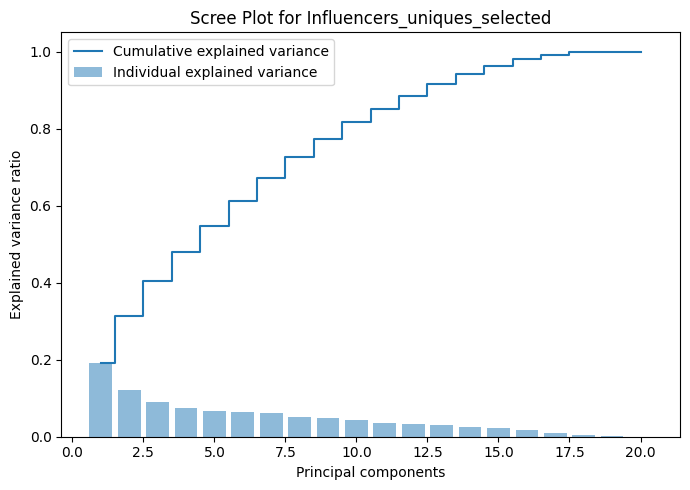

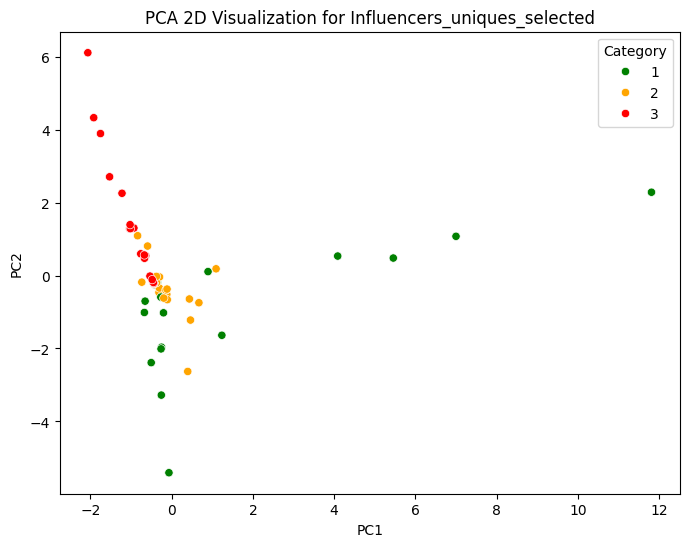

Influencers_uniques_selected_pipeline:


Influencers_uniques_selected_pipeline:
Cross-Validation MAE Scores for RF: [0.345, 0.2782, 0.18, 0.1891, 0.17]
Average MAE for RF: 0.2325
Mean Squared Error: 0.1684
Root Mean Squared Error: 0.4103
Mean Absolute Error: 0.2421
Feature Importance by RF:     Features  Importance
0        549      0.4945
1        526      0.1967
2        864      0.0707
3        863      0.0424
4        408      0.0364
5         91      0.0274
8        229      0.0248
7        214      0.0236
13       625      0.0206
9         23      0.0192
6        351      0.0148
11       334      0.0135
10       375      0.0063
12       565      0.0056
14       471      0.0022
15       584      0.0010
18       799      0.0004
16       725      0.0000
17       201      0.0000
19       342      0.0000
Influencers_uniques_selected_pipeline:
Cross-Validation Metrics:
Accuracy: [0.8333, 0.9091, 0.8182, 0.9091, 0.8182]
Average Accuracy: 0.8576
Precision: [0.881, 0.9242, 0.8701, 0.9242, 0.8182]
Average Precision: 0.8835
Recall

In [56]:
# Aply pipeline for visual results
results_Influencers_uniques_selected_pca = pca_pipeline(Influencers_uniques_selected, 'Category', n_components=2, dataset_name='Influencers_uniques_selected')

# Apply the pipeline for numerical results
Influencers_uniques_selected_pipeline, df_pca_influence_Influencers_uniques_selected, explained_variance_Influencers_uniques_selected, n_components = apply_pipeline_pca(Influencers_uniques_selected, "Influencers_uniques_selected", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence_Influencers_uniques_selected.head(10), explained_variance_Influencers_uniques_selected.head(10))

# Apply pipeline Regression
Influencers_uniques_selected_pipeline_reg, importances_reg_Influencers_uniques_selected= apply_pipeline_regressor(Influencers_uniques_selected, "Influencers_uniques_selected")
# Apply the pipeline Classification
Influencers_uniques_selected_pipe_class, importances_class_Influencers_uniques_selected = apply_classification_pipeline_classif(Influencers_uniques_selected, "Influencers_uniques_selected")

## 8.3. Merged_selected: Top ten Merged_df Features
Calling the function to select features for influence and importance to get the top ten for Merged_df

In [57]:
# Extract top features and create reduced dataset
results_Merged = extract_top_features(df_pca_influence_Merged_df, importances_reg_Merged_df, importances_class_Merged_df, Merged_df, n_features=10)

# Access results
feature_comparison = results_Merged ['feature_comparison']
top_features = results_Merged ['top_features']
Merged_selected = results_Merged ['reduced_df']

# Print top features if needed
print("\nTop features across all methods:")
print(feature_comparison.sort_values('Combined_Score', ascending=False).head(10))
print("\nSelected features:", (top_features))


Top features across all methods:
     PCA_Score  Regression_Score  Classification_Score  Combined_Score
549     0.0047            0.3503                0.0763          0.1438
110     0.0088            0.0472                0.0477          0.0345
323     0.0069            0.0458                0.0386          0.0304
270     0.0061            0.0582                0.0256          0.0300
526     0.0092            0.0429                0.0363          0.0295
491     0.0099            0.0253                0.0524          0.0292
470     0.0078            0.0408                0.0277          0.0255
140     0.0067            0.0440                0.0229          0.0245
23      0.0035            0.0270                0.0281          0.0195
214     0.0069            0.0247                0.0267          0.0194

Selected features: ['549', '110', '323', '270', '526', '491', '470', '140', '23', '214']


## 8.4. Results Merged_selected:  Pipelines for PCA, Regression and Classification

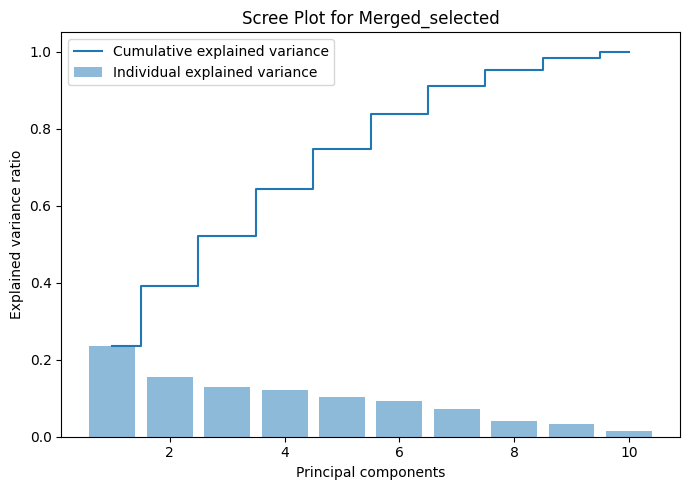

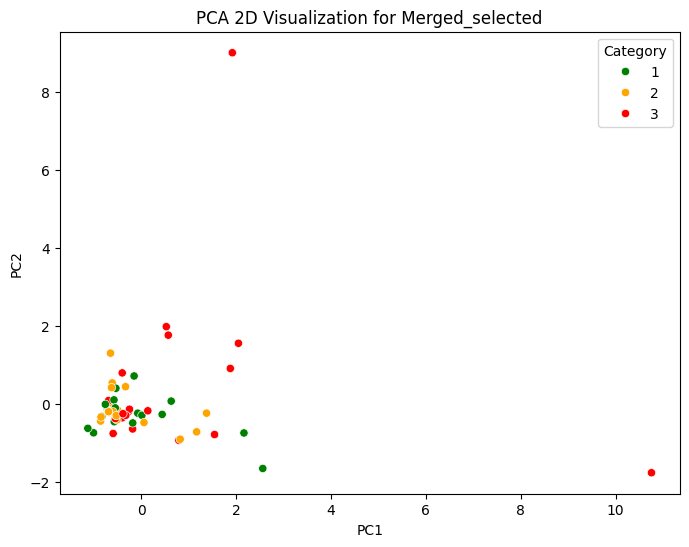

Merged_selected_pipeline:


Merged_selected_pipeline:
Cross-Validation MAE Scores for RF: [0.665, 0.8036, 0.3845, 0.2427, 0.5091]
Average MAE for RF: 0.521
Mean Squared Error: 0.2769
Root Mean Squared Error: 0.5262
Mean Absolute Error: 0.3871
Feature Importance by RF:    Features  Importance
0       549      0.3933
3       270      0.1159
1       110      0.0803
2       323      0.0756
6       470      0.0717
4       526      0.0706
7       140      0.0680
8        23      0.0510
5       491      0.0373
9       214      0.0363
Merged_selected_pipeline:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-Validation Metrics:
Accuracy: [0.75, 0.2727, 0.9091, 0.7273, 0.7273]
Average Accuracy: 0.6773
Precision: [0.7222, 0.1705, 0.9242, 0.7727, 0.7636]
Average Precision: 0.6706
Recall: [0.75, 0.2727, 0.9091, 0.7273, 0.7273]
Average Recall: 0.6773
F1-Score: [0.7288, 0.2098, 0.9041, 0.7377, 0.7273]
Average F1-Score: 0.6615

Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [0 4 3]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.50      0.57      0.53         7
           3       0.25      0.25      0.25         4

    accuracy                           0.50        14
   macro avg       0.58      0.50      0.53        14
weighted avg       0.54      0.50      0.51        14


Feature Importance:
   Features  Importance
0       549      0.2051
4       526      0.1227
2       323      0.1082
1       110      0.1043
3       270      0.0958
5       491      0.0908
9       214   

In [58]:
# Aply pipeline for visual results
Merged_selected_pca = pca_pipeline(Merged_selected, 'Category', n_components=2, dataset_name='Merged_selected')

# Apply the pipeline for numerical results
Merged_selected_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(Merged_selected,
                                                         "Merged_selected", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

# Apply pipeline Regression
Merged_selected_pipeline_reg, importances_reg= apply_pipeline_regressor(Merged_selected, "Merged_selected")
# Apply the pipeline Classification
Merged_selected_pipe_class, importances_class = apply_classification_pipeline_classif(Merged_selected, "Merged_selected")

Actually 30 features performs worse than 20 features for Merged_selected.
30 features:    MAE: 0.5157, Accuracy: 0.6606,,Average Precision: 0.5875
20 features:    MAE: 0.512 (better), Accuracy: 0.7152 (much better), Average Precision: 0.7075 (much better)
10 features:    MAE: 0.5193 (similar), Accuracy: 0.75 (better), Average Precision: 0.7859 (better), MSE: 0.2926 (better)

## 8.5. Influencers Results
actually the only difference between influencers_OLS and Influencers_uniques_selected is that Influencers_OLS has 678, 712 and 871 and Influencers_uniques_selected has 201, 799 and 342. Best differentiation is however doing Influencers_OLS. I am going to join Influencers_OLS to the corresponding features of the second df. The resulting df lacks especificity on the category number 2, now the idea is to separate them in poster sections to be able to have less overlap

In [59]:
# Joining the dataframes
Influencers_uniques_selected_columns = Influencers_uniques_selected[[201, 799, 342]]
Influencers = pd.concat([Influencers_OLS, Influencers_uniques_selected_columns], axis=1)

### Verifyning Influencers pipelins pca, classification and regression

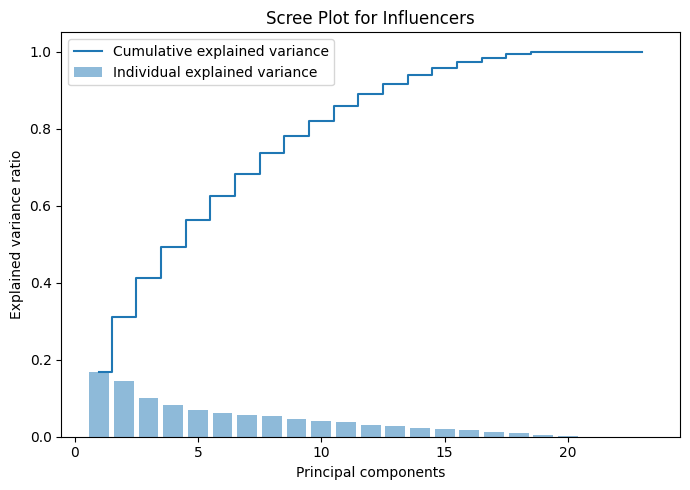

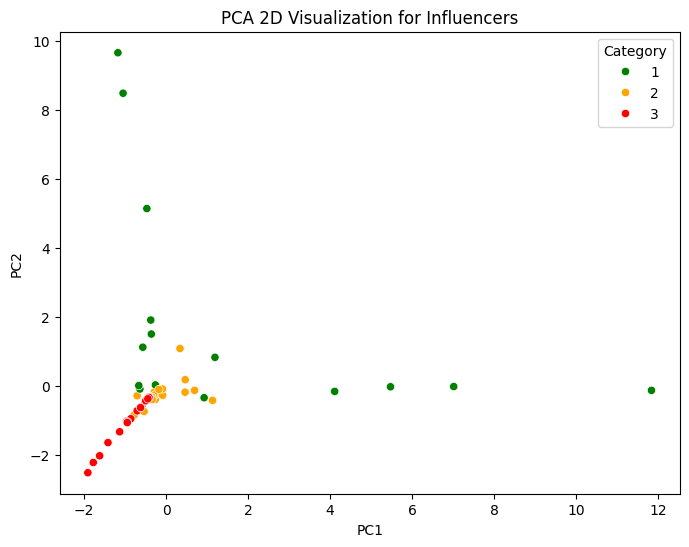

Influencers_pipeline:


Influencers_pipeline:
Cross-Validation MAE Scores for RF: [0.3542, 0.2755, 0.1709, 0.1809, 0.1673]
Average MAE for RF: 0.2298
Mean Squared Error: 0.1749
Root Mean Squared Error: 0.4182
Mean Absolute Error: 0.2457
Feature Importance by RF:     Features  Importance
16       549      0.5086
7        526      0.2000
11       864      0.0606
6        863      0.0461
14       408      0.0371
2        214      0.0252
19       229      0.0233
4         23      0.0223
5         91      0.0206
3        351      0.0143
13       565      0.0129
10       625      0.0108
15       334      0.0090
17       375      0.0063
18       471      0.0021
8        584      0.0006
20       201      0.0000
1        871      0.0000
0        725      0.0000
12       678      0.0000
9        712      0.0000
21       799      0.0000
22       342      0.0000
Influencers_pipeline:
Cross-Validation Metrics:
Accuracy: [0.8333, 0.9091, 0.7273, 0.8182, 0.7273]
Average Accuracy: 0.803
Precision: [0.881, 0.9242, 0.8295, 0.8

In [60]:
# Aply pipeline for visual results
Influencers_pca = pca_pipeline(Influencers, 'Category', n_components=2, dataset_name='Influencers')

# Apply the pipeline for numerical results
Influencers_pipeline, df_pca_influence_Influencers, explained_variance_Influencers, n_components = apply_pipeline_pca(Influencers,
                                                         "Influencers", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_Influencers.head(10), explained_variance_Influencers.head(10))

# Apply pipeline Regression
Influencers_pipeline_reg, importances_reg_Influencers= apply_pipeline_regressor(Influencers, "Influencers")
# Apply the pipeline Classification
Influencers_pipe_class, importances_class_Influencers = apply_classification_pipeline_classif(Influencers, "Influencers")

# 9. Manually prunning the features according to importance and influence

## 9.1. old_new dataframes creation
From manually prunned features according to importance and influence results

In [61]:
# Get your top 10 features
selected_oldies = [154, 201, 214, 229, 334, 351, 354, 408, 497, 512, 565, 581, 583, 584, 606, 621, 625]

# Create final reduced dataset
old_new = original[["Category"] + selected_oldies]

## 9.2. old_new Results:  Pipelines for PCA, Regression and Classification

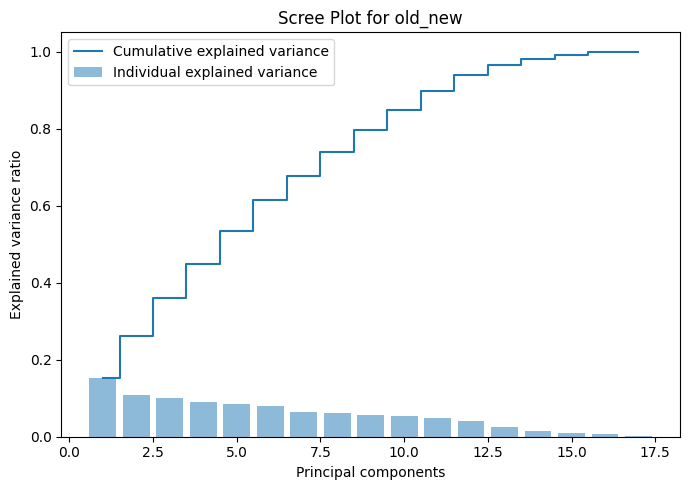

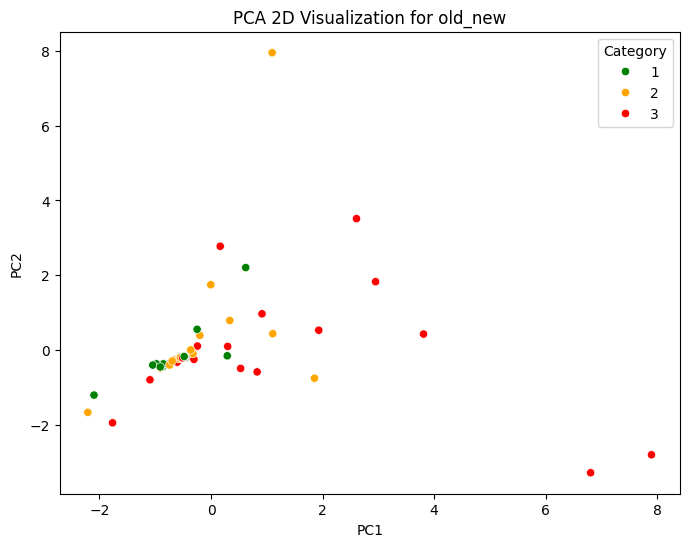

old_new_pipeline:


old_new_pipeline:
Cross-Validation MAE Scores for RF: [0.6808, 0.6367, 0.5658, 0.4059, 0.4425]
Average MAE for RF: 0.5463
Mean Squared Error: 0.3187
Root Mean Squared Error: 0.5645
Mean Absolute Error: 0.4627
Feature Importance by RF:     Features  Importance
2        214      0.1541
6        354      0.1425
3        229      0.1033
5        351      0.1012
10       565      0.0974
7        408      0.0843
4        334      0.0755
16       625      0.0739
12       583      0.0488
14       606      0.0429
13       584      0.0211
11       581      0.0180
15       621      0.0136
0        154      0.0130
9        512      0.0059
8        497      0.0041
1        201      0.0002
old_new_pipeline:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-Validation Metrics:
Accuracy: [0.5833, 0.6364, 0.6364, 0.5455, 0.8182]
Average Accuracy: 0.644
Precision: [0.5833, 0.798, 0.4659, 0.3961, 0.8667]
Average Precision: 0.622
Recall: [0.5833, 0.6364, 0.6364, 0.5455, 0.8182]
Average Recall: 0.644
F1-Score: [0.5768, 0.5974, 0.5315, 0.4589, 0.8096]
Average F1-Score: 0.5948

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [1 5 1]
 [0 2 2]]

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.33      0.40         3
           2       0.56      0.71      0.62         7
           3       0.67      0.50      0.57         4

    accuracy                           0.57        14
   macro avg       0.57      0.52      0.53        14
weighted avg       0.58      0.57      0.56        14


Feature Importance:
    Features  Importance
2        214      0.1125
10       565      0.1115
5        351      0.1068
3        229      0.0970
6        354      0.0948
7        408      0.0826
16     

In [62]:
# Aply pipeline for visual results
old_new_pca = pca_pipeline(old_new, 'Category', n_components=2, dataset_name='old_new')

# Apply the pipeline for numerical results
old_new_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(old_new, "old_new", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

# Apply pipeline Regression
old_new_pipeline_reg, importances_reg= apply_pipeline_regressor(old_new, "old_new")
# Apply the pipeline Classification
old_new_pipe_class, importances_class = apply_classification_pipeline_classif(old_new, "old_new")

# 10.  Cluster Analysis
## 10.1.  script - Pipeline K-Means, DBSCAN, and GMM

In [63]:
def clustering_pipeline_all(df, pca_data_name='pca_data', n_clusters=5, eps=0.5, min_samples=5, n_components=2):
    """
    Performs clustering using K-Means, DBSCAN, and GMM with PCA for dimensionality reduction.

    Parameters:
    - df: Input DataFrame (features only, no labels).
    - n_clusters: Number of clusters for K-Means and GMM (default=5).
    - eps: DBSCAN's epsilon parameter (default=0.5).
    - min_samples: Minimum samples for DBSCAN (default=5).
    - n_components: Number of components for PCA (default=2).

    Returns:
    - results: Dictionary with clustering results for K-Means, DBSCAN, and GMM, as well as PCA data and metrics.
    """
    results = {}

    # Separate true labels
    true_labels = df['Category']

    df = df.drop(columns=['Category'])  # Drop any non-numeric columns

    # Step 1: Scaling the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # Step 2: PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_data)

    # Calculate explained variance and cumulative variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    # Clustering
    results = {
        'pca': pca,
        'pca_data_name': pca_data,
        'scaled_data': scaled_data,
        'explained_variance': explained_variance_ratio,
        'cumulative_variance': cumulative_variance_ratio
    }

    # Step 3: K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(pca_data)
    kmeans_silhouette = silhouette_score(pca_data, kmeans_labels)
    kmeans_db_score = davies_bouldin_score(pca_data, kmeans_labels)
    kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)

    results['kmeans'] = {
        'cluster_labels': kmeans_labels,
        'silhouette_score': kmeans_silhouette,
        'davies_bouldin_score': kmeans_db_score,
        'adjusted_rand_score': kmeans_ari
    }

    # Step 4: DBSCAN Clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Add automatic eps calculation if not provided
    if eps is None:
        nbrs = NearestNeighbors(n_neighbors=2).fit(scaled_data)
        distances, _ = nbrs.kneighbors(scaled_data)
        eps = np.percentile(distances[:, 1], 90)

    dbscan_labels = dbscan.fit_predict(pca_data)
    valid_indices = dbscan_labels != -1
    if len(set(dbscan_labels[valid_indices])) > 1:
        dbscan_silhouette = silhouette_score(pca_data[valid_indices], dbscan_labels[valid_indices])
        dbscan_db_score = davies_bouldin_score(pca_data[valid_indices], dbscan_labels[valid_indices])
    else:
        dbscan_silhouette = None
        dbscan_db_score = None
    dbscan_ari = adjusted_rand_score(true_labels, dbscan_labels)


    results['dbscan'] = {
        'cluster_labels': dbscan_labels,
        'silhouette_score': dbscan_silhouette,
        'davies_bouldin_score': dbscan_db_score,
        'adjusted_rand_score': dbscan_ari
    }

    # Step 5: GMM Clustering
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(pca_data)
    gmm_silhouette = silhouette_score(pca_data, gmm_labels)
    gmm_db_score = davies_bouldin_score(pca_data, gmm_labels)
    gmm_ari = adjusted_rand_score(true_labels, gmm_labels)

    results['gmm'] = {
        'cluster_labels': gmm_labels,
        'silhouette_score': gmm_silhouette,
        'davies_bouldin_score': gmm_db_score,
        'adjusted_rand_score': gmm_ari,
        'bic_score': gmm.bic(pca_data),
        'aic_score': gmm.aic(pca_data)
    }

    # Addind normalized metrics
    for method in ['kmeans', 'dbscan', 'gmm']:
        labels = results[method]['cluster_labels']
        if method == 'dbscan':
            valid_labels = labels[labels != -1]
            sizes = np.bincount(valid_labels)
        else:
            sizes = np.bincount(labels)
        results[method]['normalized_sizes'] = sizes / len(labels)

    # Store PCA-transformed data with the specified name
    results[pca_data_name] = pca_data

    return results

## 10.2. Script - Visualisation K-means, DBSCAN AND GaussianMixture

In [66]:
def visualize_clustering_results(results, title_prefix=''):
    """
    Visualize clustering results with multiple plots and metrics

    Parameters:
    - results: Dictionary containing clustering results from clustering_pipeline_all function
    - title_prefix: Optional prefix for plot titles
    """
    # Extract PCA data
    pca_data = results[list(filter(lambda x: x.startswith('pca_'), results.keys()))[0]]

    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{title_prefix} Clustering Results Visualization', fontsize=16)

    # plot style settings for better visibility
    plt.style.use('default')

    # Color palettes for different clustering methods
    color_palettes =color_palettes = [
        # For K-means (5 distinct colors)
        ['#800080', '#FFA500', '#0000FF', '#00FF00', '#FF0000'],  # Red, Green, Blue, Orange, Purple
        # For GMM (same as kmeans)
        ['#800080', '#FFA500', '#0000FF', '#00FF00', '#FF0000'],
        # For DBSCAN (2 colors - noise and cluster)
        ['#808080', '#0000FF']  # Grey, Blue

    ]

    # Add grid for better readability
    for ax in axs.flat:
        ax.grid(True, alpha=0.3)

    # Clustering methods and their labels
    clustering_methods = [
        ('K-Means', results['kmeans']['cluster_labels'], color_palettes[0]),
        ('Gaussian Mixture Model', results['gmm']['cluster_labels'], color_palettes[2]),
        ('DBSCAN', results['dbscan']['cluster_labels'], color_palettes[1])
    ]

    # Scatter plots for each clustering method
    for idx, (method_name, labels, color_palette) in enumerate(clustering_methods):
        row = idx // 2
        col = idx % 2

        # Handle DBSCAN noise points
        if method_name == 'DBSCAN':
            noise_mask = labels == -1
            cluster_mask = labels != -1

            # Plot noise points
            if np.any(noise_mask):
                axs[row, col].scatter(
                    pca_data[noise_mask, 0],
                    pca_data[noise_mask, 1],
                    c='gray',
                    alpha=0.5,
                    label='Noise'
                )

            # Plot clustered points
            unique_labels = np.unique(labels[cluster_mask])
            for label in unique_labels:
                mask = (labels == label) & cluster_mask
                axs[row, col].scatter(
                    pca_data[mask, 0],
                    pca_data[mask, 1],
                    c=[color_palette[label]],
                    label=f'Cluster {label}'
                )
        else:
            # For K-Means and GMM
            unique_labels = np.unique(labels)
            for label in unique_labels:
                mask = labels == label
                axs[row, col].scatter(
                    pca_data[mask, 0],
                    pca_data[mask, 1],
                    c=[color_palette[label % len(color_palette)]],
                    label=f'Cluster {label}'
                )

        axs[row, col].set_title(f'{method_name} Clustering')
        axs[row, col].set_xlabel('First Principal Component')
        axs[row, col].set_ylabel('Second Principal Component')
        axs[row, col].legend()

    plt.tight_layout()
    plt.show()

def print_clustering_metrics(results):
    """
    Print detailed clustering metrics for each method

    Parameters:
    - results: Dictionary containing clustering results
    """
    print("\n=== Clustering Metrics ===")

    # Cluster quality metrics
    def calculate_cluster_quality(labels, data):
        if len(set(labels)) <= 1:
            return None
        # Calculate average intra-cluster distance
        intra_cluster_distances = []
        for label in set(labels):
            if label != -1:  # Skip noise points
                cluster_points = data[labels == label]
                if len(cluster_points) > 1:
                    distances = pdist(cluster_points)
                    intra_cluster_distances.append(np.mean(distances))
        return np.mean(intra_cluster_distances) if intra_cluster_distances else None

    # Metrics for each clustering method
    clustering_methods = ['kmeans', 'dbscan', 'gmm']

    for method in clustering_methods:
        print(f"\n{method.upper()} Clustering Metrics:")
        labels = results[method]['cluster_labels']
        silhouette = results[method]['silhouette_score']
        db_score = results[method]['davies_bouldin_score']
        ari = results[method].get('adjusted_rand_score', 'N/A')  # Use 'N/A' if ARI is not available
        quality = calculate_cluster_quality(labels, results['scaled_data'])

        if quality is not None:
            print(f"Average Intra-cluster Distance: {quality:.4f}")
        else:
            print("Average Intra-cluster Distance: N/A")
        print(f"Silhouette Score: {silhouette if silhouette is not None else 'Not applicable'}")
        print(f"Davies-Bouldin Score: {db_score if db_score is not None else 'Not applicable'}")
        print(f"Adjusted Rand Score: {ari}")

        # Count cluster sizes
        if method == 'dbscan':
            valid_labels = labels[labels != -1]
            unique_labels = np.unique(valid_labels)
        else:
            unique_labels = np.unique(labels)

        print("\nCluster Sizes:")
        for label in unique_labels:
            if method == 'dbscan' and label == -1:
                count = np.sum(labels == label)
                print(f"Noise Points: {count}")
            else:
                count = np.sum(labels == label)
                print(f"Cluster {label}: {count} points")


    # Print Explained Variance for PCA
    print("\nPCA Explained Variance Ratio:")
    explained_variance = results['explained_variance']
    for i, var in enumerate(explained_variance[:10], 1):
        print(f"PC{i}: {var * 100:.2f}%")
    print(f"Total Variance Explained (first 10 PCs): {np.sum(explained_variance[:10]) * 100:.2f}%")

# 11. Results Cluster Analysis


## 11.1 Clustering original_pca

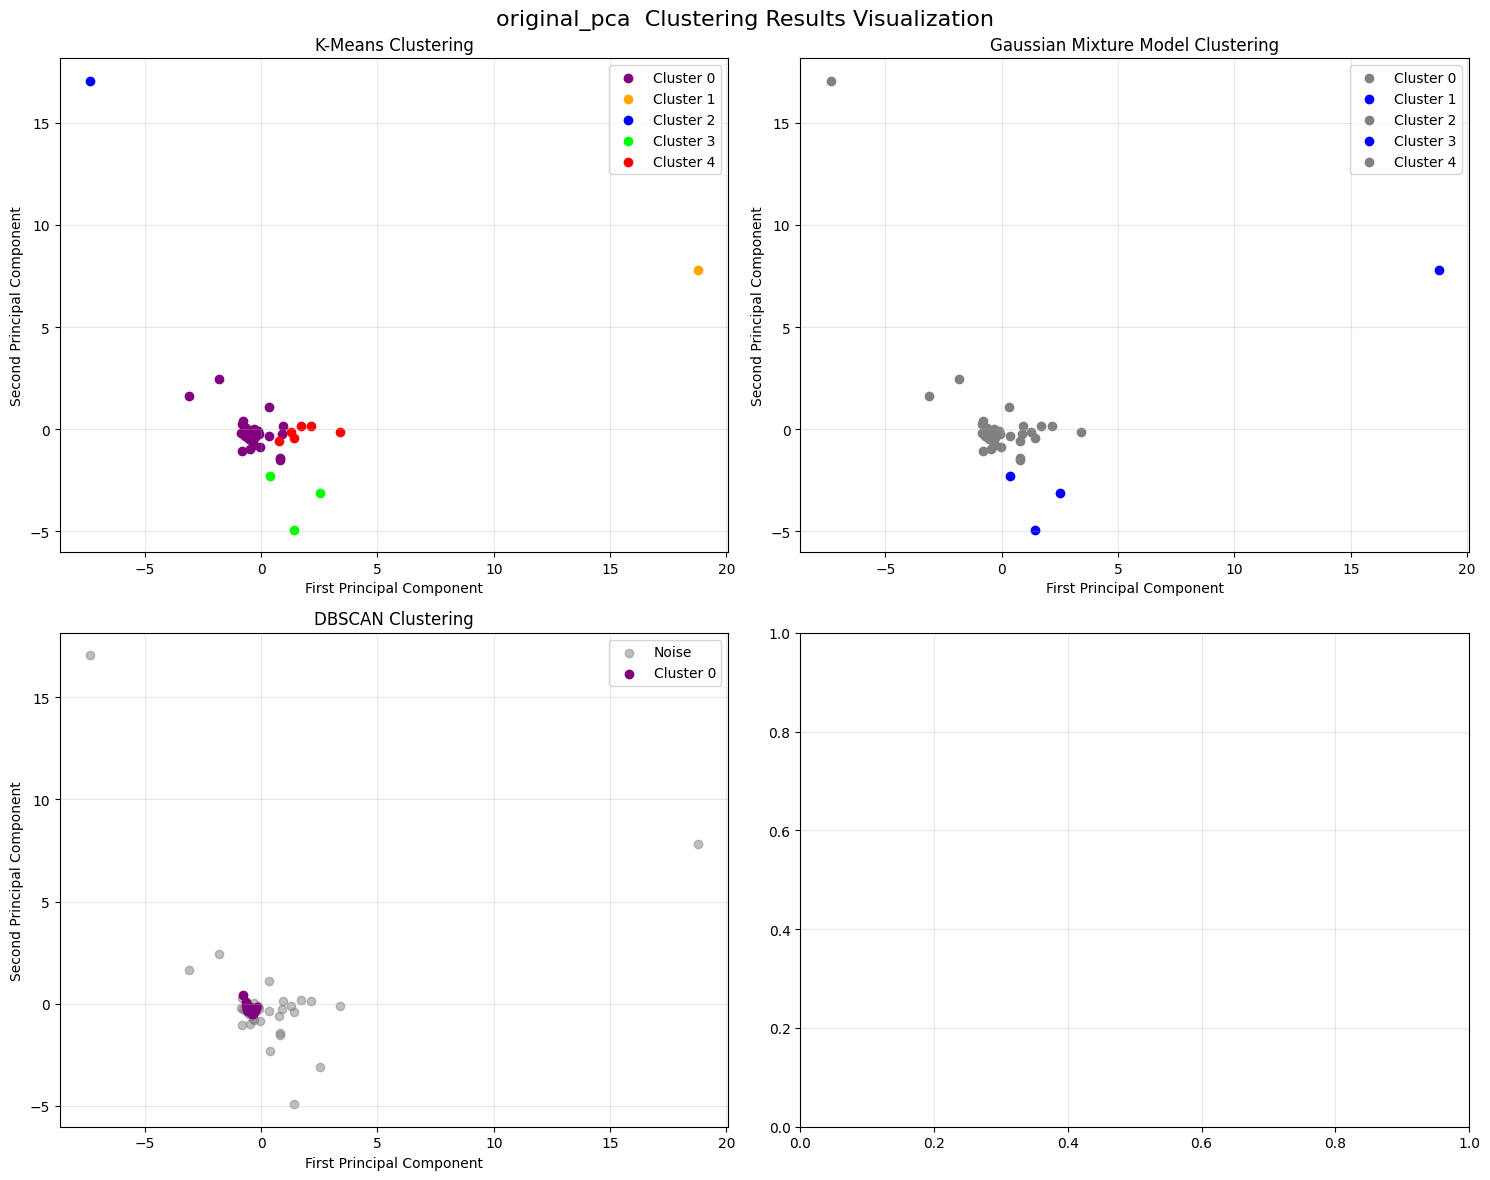


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 11.7702
Silhouette Score: 0.6301572651358246
Davies-Bouldin Score: 0.44600130756571466
Adjusted Rand Score: -0.033431908068621605

Cluster Sizes:
Cluster 0: 59 points
Cluster 1: 1 points
Cluster 2: 1 points
Cluster 3: 3 points
Cluster 4: 6 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 2.5259
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.05673160381907609

Cluster Sizes:
Cluster 0: 35 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 10.5923
Silhouette Score: 0.1994218525040516
Davies-Bouldin Score: 1.1432042436032452
Adjusted Rand Score: 0.009408718983640516

Cluster Sizes:
Cluster 0: 22 points
Cluster 1: 1 points
Cluster 2: 1 points
Cluster 3: 3 points
Cluster 4: 43 points

PCA Explained Variance Ratio:
PC1: 13.40%
PC2: 11.84%
PC3: 10.09%
PC4: 9.15%
PC5: 8.10%
Total Variance Explained (first 10 PCs): 52.57%


In [67]:
# Running pipeline
results_original_pca_cluster  = clustering_pipeline_all(original_pca,  pca_data_name='pca_data_original_pca ',
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_original_pca_cluster, title_prefix='original_pca ')
print_clustering_metrics(results_original_pca_cluster )

### original_pca Discussion

## 11.2 Clustering uniques_pca

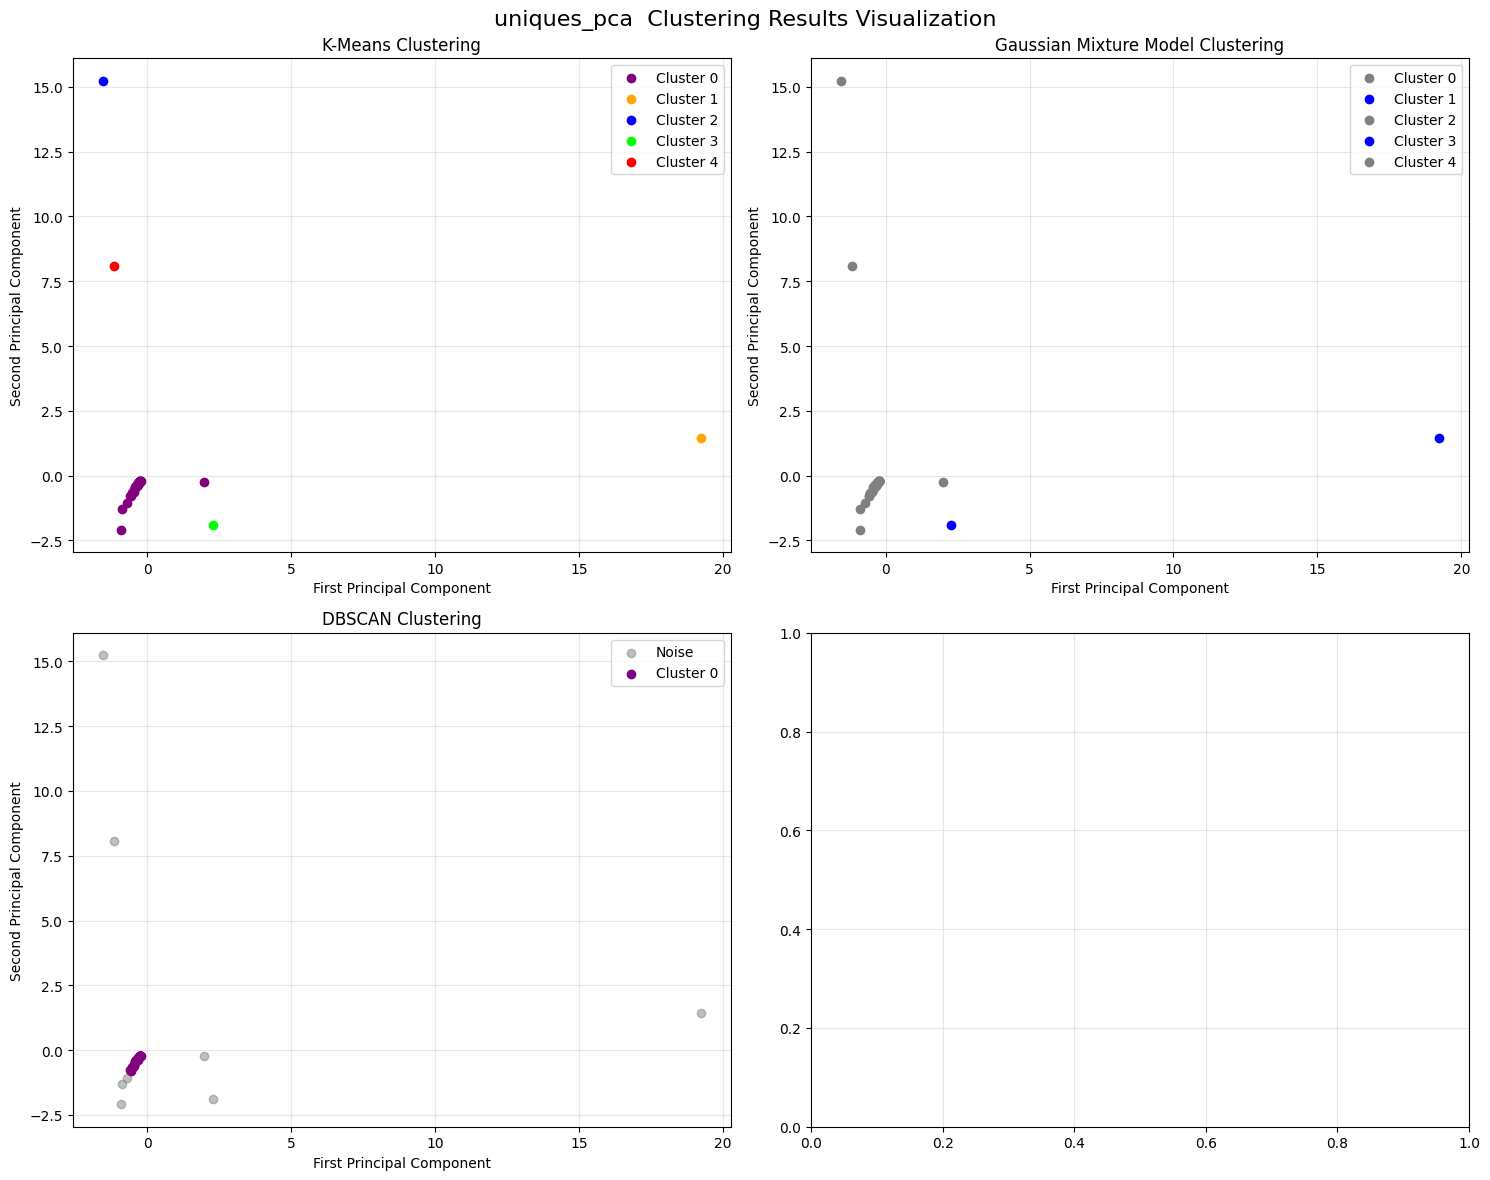


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 5.7538
Silhouette Score: 0.8877653331745179
Davies-Bouldin Score: 0.040367892766702274
Adjusted Rand Score: 0.0028655323934276018

Cluster Sizes:
Cluster 0: 66 points
Cluster 1: 1 points
Cluster 2: 1 points
Cluster 3: 1 points
Cluster 4: 1 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 4.4601
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.02759577992603921

Cluster Sizes:
Cluster 0: 61 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 5.7538
Silhouette Score: 0.8877653331745179
Davies-Bouldin Score: 0.040367892766702274
Adjusted Rand Score: 0.0028655323934276018

Cluster Sizes:
Cluster 0: 66 points
Cluster 1: 1 points
Cluster 2: 1 points
Cluster 3: 1 points
Cluster 4: 1 points

PCA Explained Variance Ratio:
PC1: 11.16%
PC2: 9.06%
PC3: 8.22%
PC4: 8.01%
PC5: 7.04%
Total Variance Explained (first 10 PCs): 43.49%


In [68]:
# Running pipeline
results_uniques_pca_cluster  = clustering_pipeline_all(uniques_pca,  pca_data_name='pca_data_original_pca ',
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_uniques_pca_cluster, title_prefix='uniques_pca ')
print_clustering_metrics(results_uniques_pca_cluster )

### Discussing uniques_pca

## 11.3 Clustering uniques23_OLS

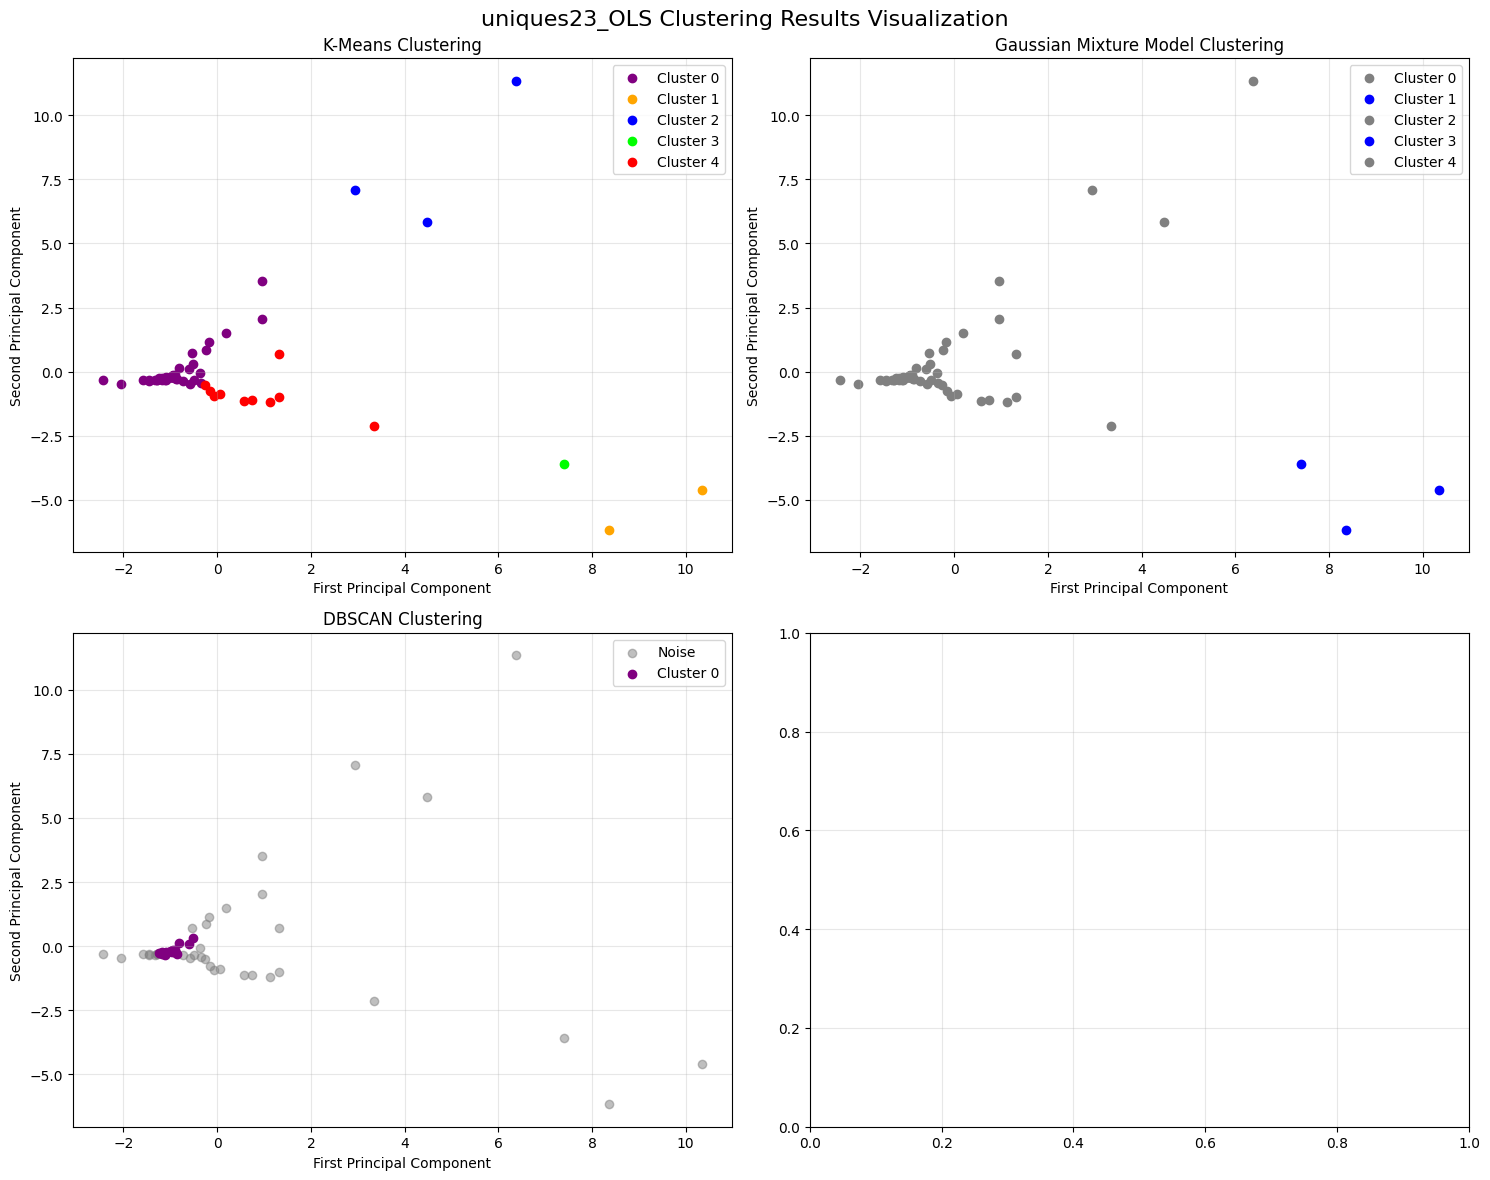


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 7.6972
Silhouette Score: 0.39325299492251986
Davies-Bouldin Score: 0.7757596195903957
Adjusted Rand Score: 0.13022139048762402

Cluster Sizes:
Cluster 0: 54 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 10 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 1.3099
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.07276938318232015

Cluster Sizes:
Cluster 0: 34 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 7.4063
Silhouette Score: 0.27947514332460477
Davies-Bouldin Score: 0.8839006839114465
Adjusted Rand Score: 0.09745136262032149

Cluster Sizes:
Cluster 0: 49 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 15 points

PCA Explained Variance Ratio:
PC1: 19.95%
PC2: 17.05%
PC3: 10.29%
PC4: 7.96%
PC5: 6.53%
Total Variance Explained (first 10 PCs): 61.77%


In [69]:
# Running pipeline
results_uniques23_OLS_cluster  = clustering_pipeline_all(uniques23_OLS,  pca_data_name='pca_data_uniques23_OLS ',
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_uniques23_OLS_cluster, title_prefix='uniques23_OLS')
print_clustering_metrics(results_uniques23_OLS_cluster )

### Discussing  uniques23_OLS (300+ features):
K-means: Silhouette Score of 0.685, Davies-Bouldin of 0.514
Cluster sizes are quite imbalanced (53, 3, 3, 5, 6 points)
PCA explains 37% of variance (19.95% PC1, 17.05% PC2)

## 11.4 Clustering Influencers_OLS

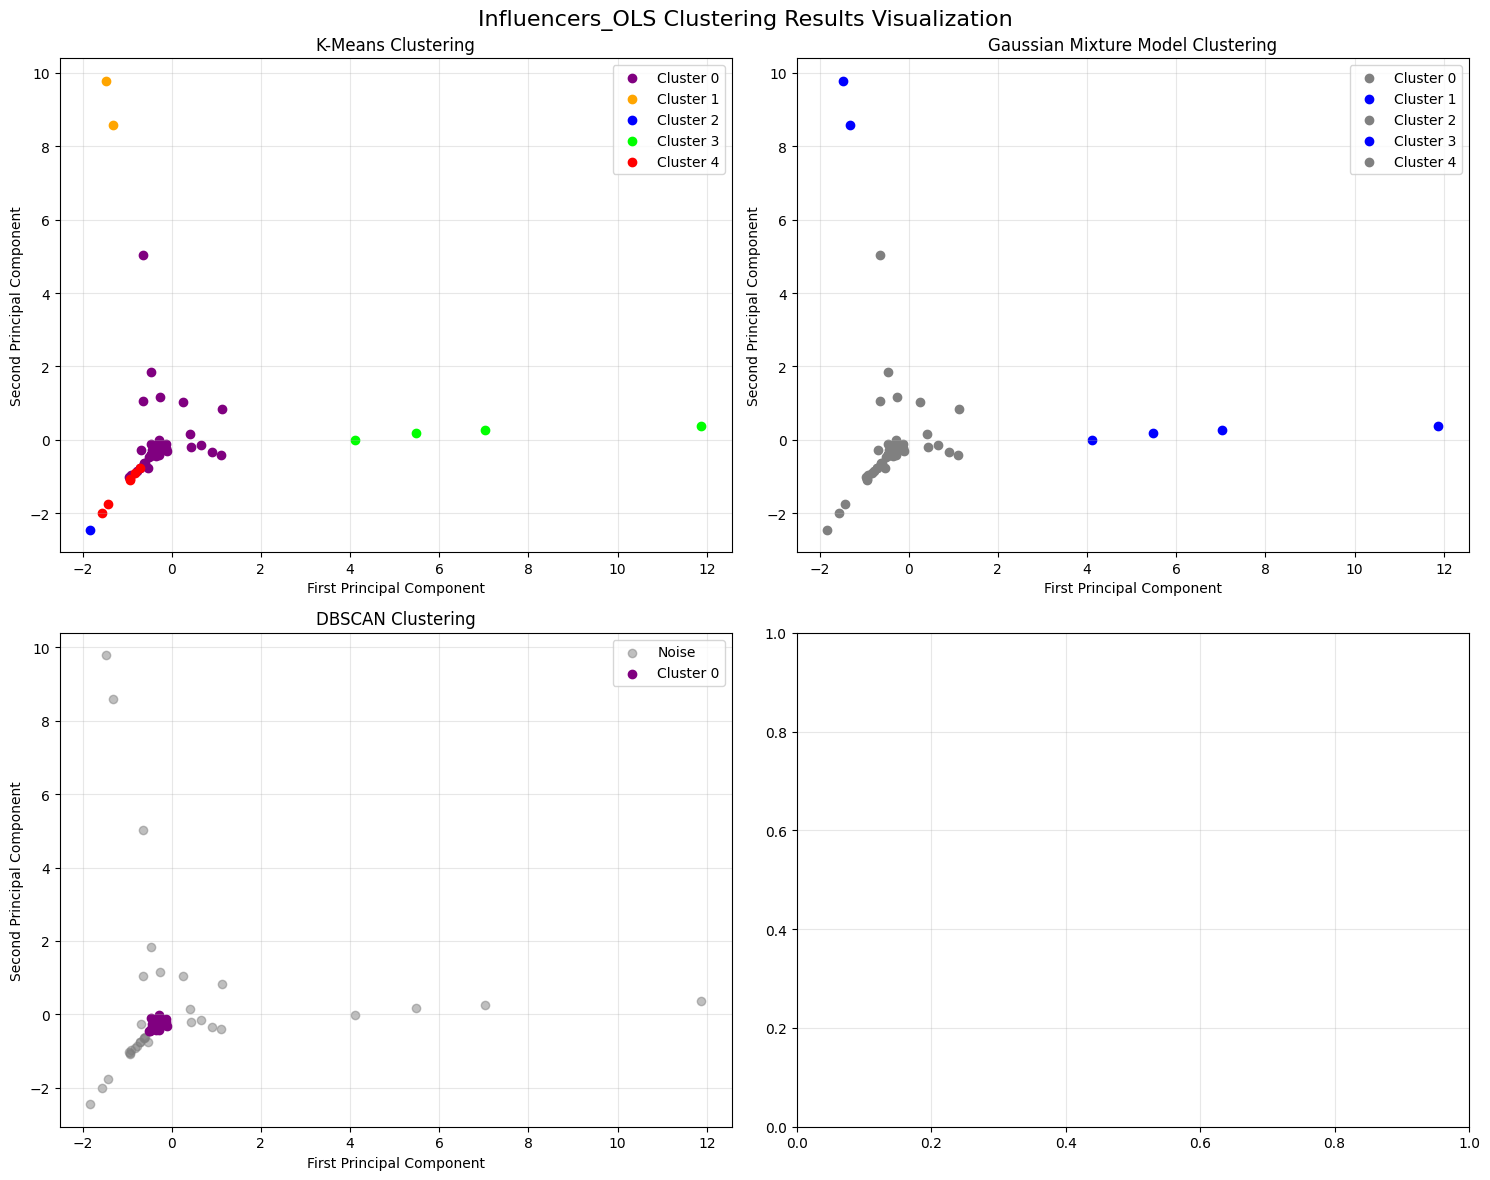


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 5.2940
Silhouette Score: 0.5838892971693419
Davies-Bouldin Score: 0.5103769261887663
Adjusted Rand Score: 0.14999371927262958

Cluster Sizes:
Cluster 0: 57 points
Cluster 1: 2 points
Cluster 2: 1 points
Cluster 3: 4 points
Cluster 4: 6 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 0.7151
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.1158484972356072

Cluster Sizes:
Cluster 0: 37 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 4.6830
Silhouette Score: 0.13076153989479716
Davies-Bouldin Score: 0.992208492229549
Adjusted Rand Score: 0.19690793072014584

Cluster Sizes:
Cluster 0: 33 points
Cluster 1: 2 points
Cluster 2: 1 points
Cluster 3: 4 points
Cluster 4: 30 points

PCA Explained Variance Ratio:
PC1: 19.12%
PC2: 16.41%
PC3: 10.92%
PC4: 9.15%
PC5: 6.73%
Total Variance Explained (first 10 PCs): 62.33%


In [70]:
# Running pipeline
results_Influencers_OLS_cluster = clustering_pipeline_all(Influencers_OLS,  pca_data_name='pca_data_Influencers_OLS_cluster',
                                                   n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_Influencers_OLS_cluster, title_prefix='Influencers_OLS')
print_clustering_metrics(results_Influencers_OLS_cluster)

### Clustering Influencers_OLS, Discussion
Influencers_OLS:
K-means: Silhouette Score of 0.603, Davies-Bouldin of 0.552
Very imbalanced cluster sizes (1, 53, 3, 3, 10 points)
PCA explains 35.53% of variance

Notice that for PCA visualisation on notebook PCA_RF_FImporance.ipnyb, the same dataset was used, hower the main difference is that there the category label was use to color code the samples, however category was droped and didnt participate on the clustering, it was used just for color coding.
Plots show similar behaviour because the clustering algorithms (K-Means, DBSCAN, GMM) are able to identify the inherent structure in the data and recover groupings that are consistent with the original category information, even though the category column is not provided. it means the clustering methods are effectively capturing the underlying patterns in the data, regardless of whether the category information is explicitly given or not. The consistency between the PCA visualization and the clustering results indicates the data has a clear structure that the algorithms can latch onto.
## 11.5 Clustering OLS_all

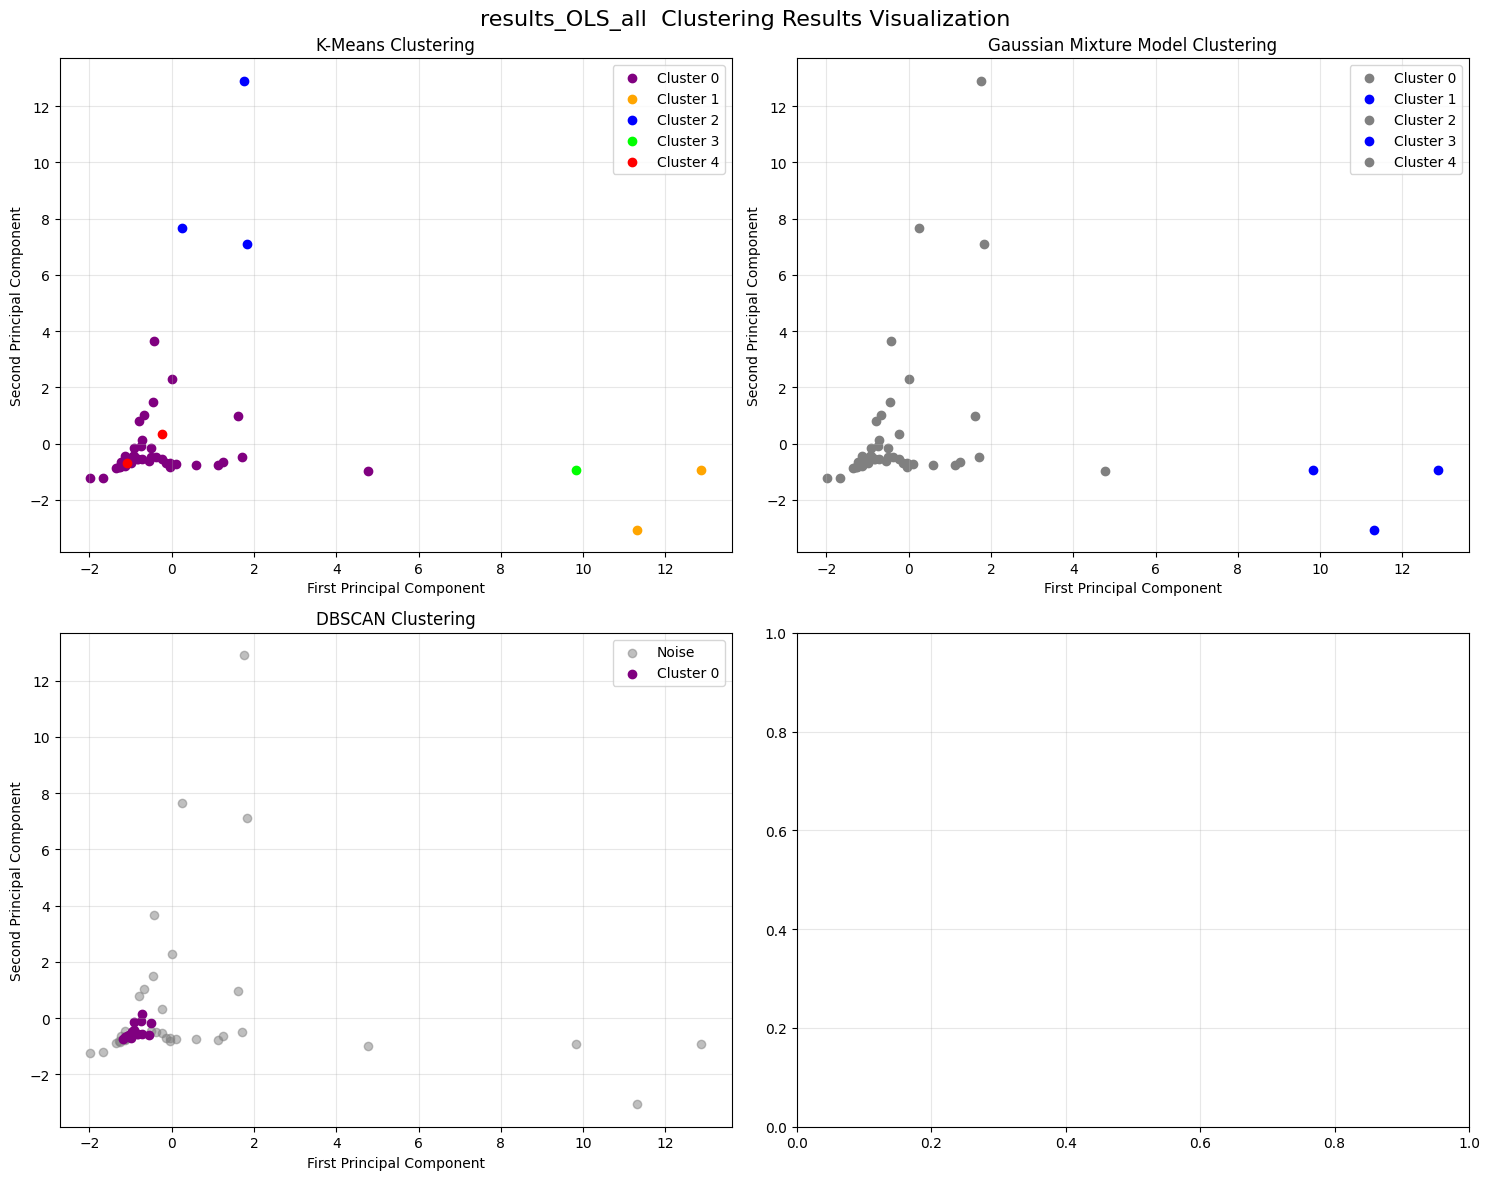


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 8.9253
Silhouette Score: 0.7275569775743765
Davies-Bouldin Score: 0.39104114073843355
Adjusted Rand Score: 0.12140880609088245

Cluster Sizes:
Cluster 0: 62 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 2 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 1.5239
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.11662166071945221

Cluster Sizes:
Cluster 0: 35 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 8.9253
Silhouette Score: 0.7275569775743765
Davies-Bouldin Score: 0.39104114073843355
Adjusted Rand Score: 0.12140880609088245

Cluster Sizes:
Cluster 0: 62 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 2 points

PCA Explained Variance Ratio:
PC1: 21.35%
PC2: 14.84%
PC3: 10.66%
PC4: 8.53%
PC5: 6.63%
Total Variance Explained (first 10 PCs): 62.01%


In [71]:
# Running pipeline
results_OLS_all_cluster = clustering_pipeline_all(OLS_all,  pca_data_name='pca_data_OLS_all',  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_OLS_all_cluster, title_prefix='results_OLS_all ')
print_clustering_metrics(results_OLS_all_cluster)

### OLS_all Discussion
K-means: Silhouette Score of 0.678, Davies-Bouldin of 0.457
Cluster sizes imbalanced (57, 3, 1, 3, 6 points)
PCA explains 36.18% of variance
## 11.6 Clustering Influencers_uniques

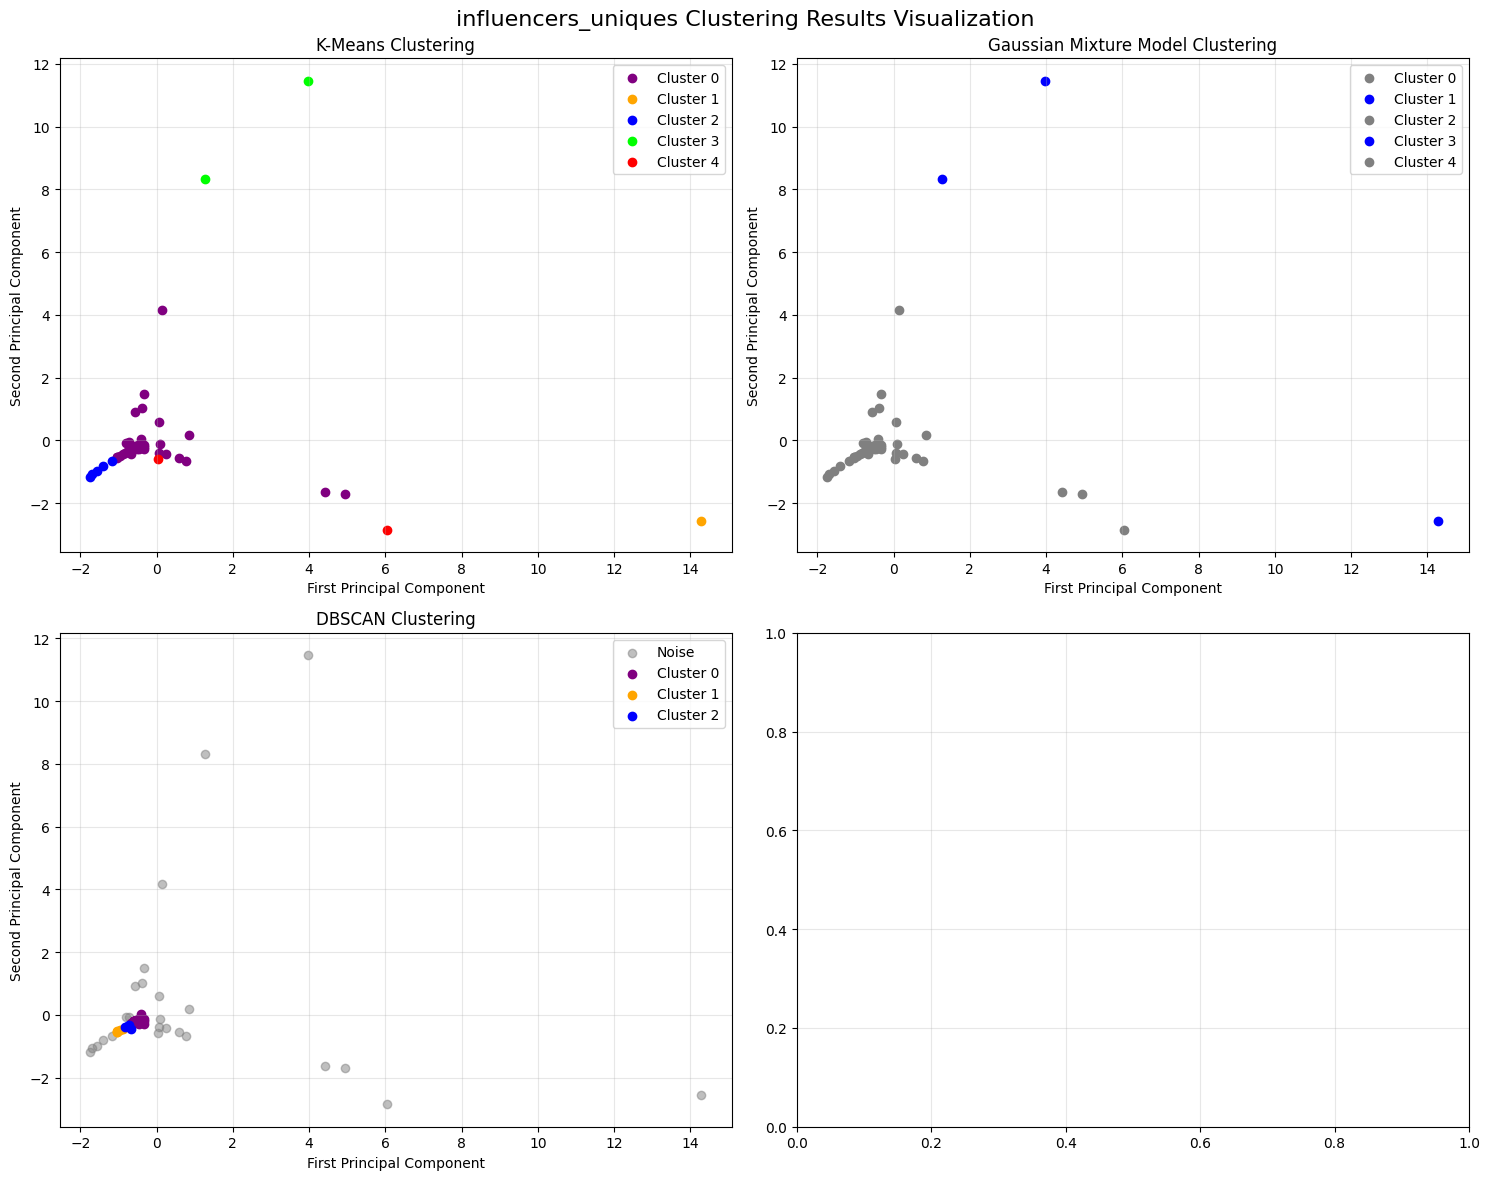


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 8.6146
Silhouette Score: 0.6079058489405563
Davies-Bouldin Score: 0.49052812369557747
Adjusted Rand Score: 0.10525312403329425

Cluster Sizes:
Cluster 0: 60 points
Cluster 1: 1 points
Cluster 2: 5 points
Cluster 3: 2 points
Cluster 4: 2 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 3.3128
Silhouette Score: 0.7207118093954339
Davies-Bouldin Score: 0.5070785208470934
Adjusted Rand Score: 0.20730157144205202

Cluster Sizes:
Cluster 0: 35 points
Cluster 1: 5 points
Cluster 2: 5 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 8.6146
Silhouette Score: 0.6079058489405563
Davies-Bouldin Score: 0.49052812369557747
Adjusted Rand Score: 0.10525312403329425

Cluster Sizes:
Cluster 0: 60 points
Cluster 1: 1 points
Cluster 2: 5 points
Cluster 3: 2 points
Cluster 4: 2 points

PCA Explained Variance Ratio:
PC1: 18.42%
PC2: 13.88%
PC3: 9.48%
PC4: 7.78%
PC5: 7.26%
Total Variance E

In [72]:
#implementing the algoritms in a part of uniques, the first 50 rows
results_influencers_uniques_cluster = clustering_pipeline_all(Influencers_uniques,  pca_data_name='pca_data_influencers_uniques',
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_influencers_uniques_cluster, title_prefix='influencers_uniques')
print_clustering_metrics(results_influencers_uniques_cluster)

### Influencers_uniques_selected Discussion

## 11.7. Clustering Merged_selected

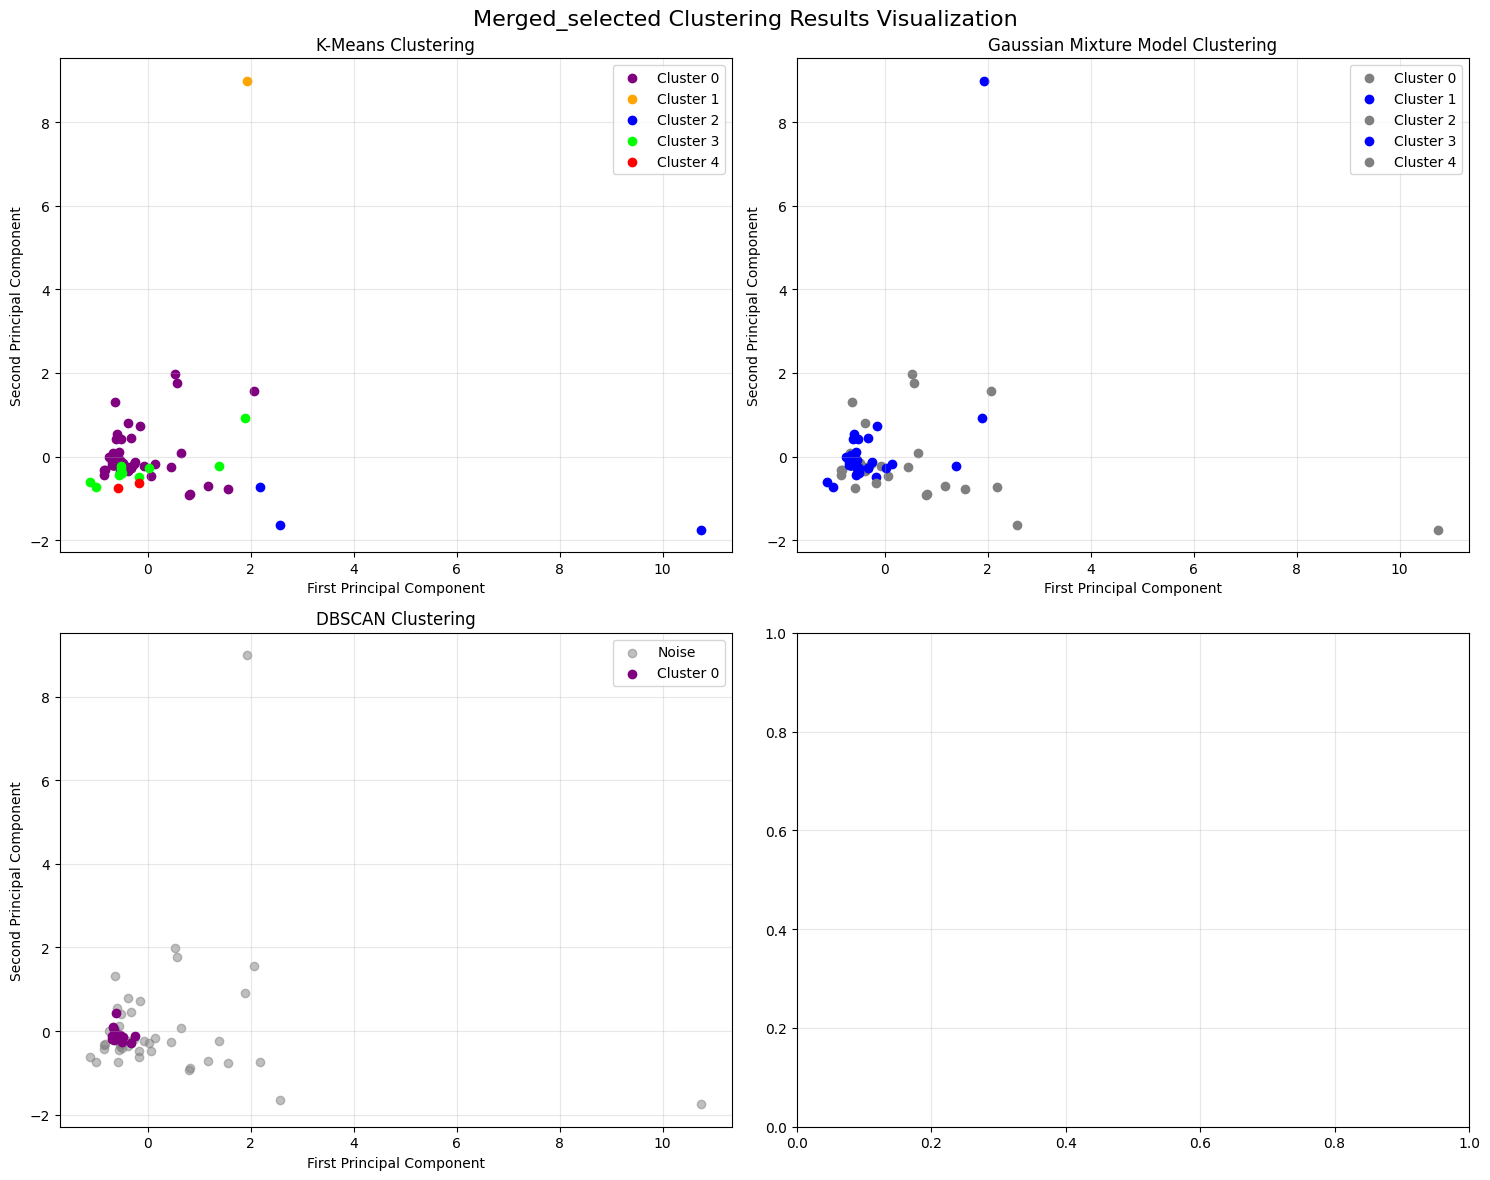


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 4.0735
Silhouette Score: 0.397646725957
Davies-Bouldin Score: 0.8629995847426436
Adjusted Rand Score: 0.06975549784772624

Cluster Sizes:
Cluster 0: 54 points
Cluster 1: 1 points
Cluster 2: 3 points
Cluster 3: 10 points
Cluster 4: 2 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 0.4645
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.009140036946152362

Cluster Sizes:
Cluster 0: 21 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 3.9067
Silhouette Score: 0.1763252189646922
Davies-Bouldin Score: 1.38957098131224
Adjusted Rand Score: 0.09561657810290614

Cluster Sizes:
Cluster 0: 26 points
Cluster 1: 1 points
Cluster 2: 3 points
Cluster 3: 38 points
Cluster 4: 2 points

PCA Explained Variance Ratio:
PC1: 23.64%
PC2: 15.54%
PC3: 13.04%
PC4: 12.06%
PC5: 10.42%
Total Variance Explained (first 10 PCs): 74.70%


In [73]:
# Running pipeline
results_Merged_selected_cluster = clustering_pipeline_all(Merged_selected,  pca_data_name='pca_data_Merged_selected',
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_Merged_selected_cluster, title_prefix='Merged_selected')
print_clustering_metrics(results_Merged_selected_cluster)


## 11.8 Clustering old_new

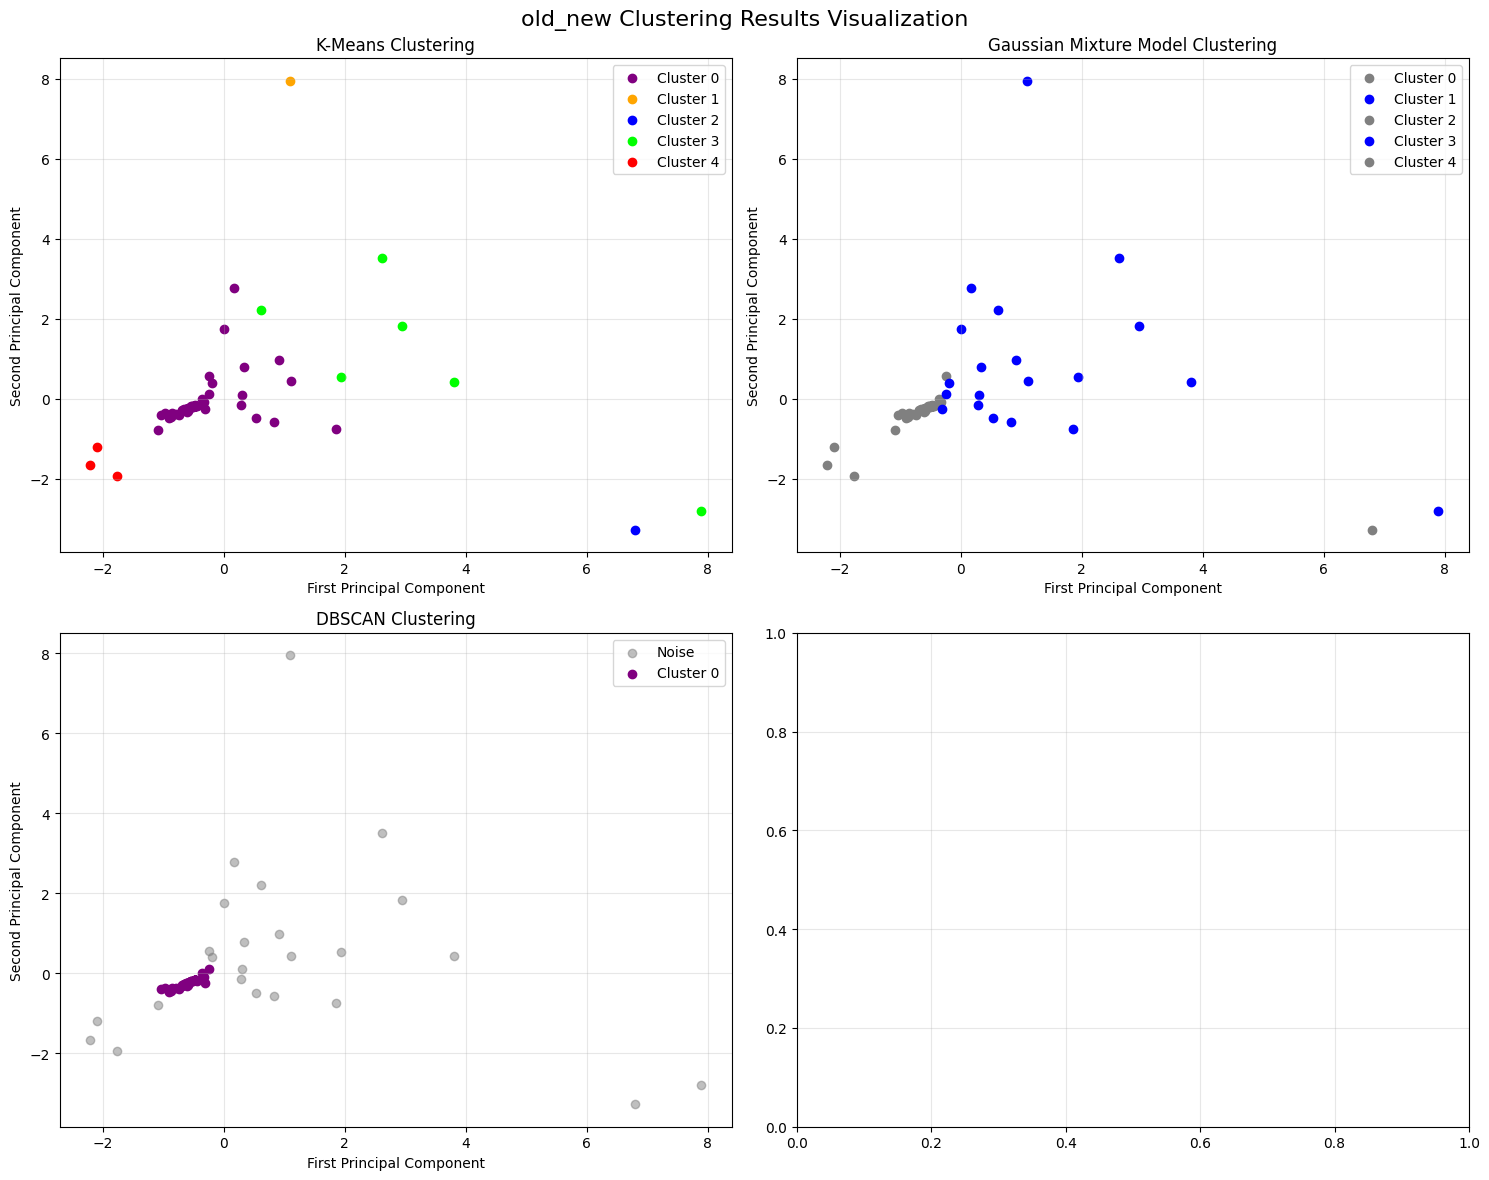


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 7.8797
Silhouette Score: 0.6889644604199615
Davies-Bouldin Score: 0.6701014239085781
Adjusted Rand Score: 0.05592223281328615

Cluster Sizes:
Cluster 0: 59 points
Cluster 1: 1 points
Cluster 2: 1 points
Cluster 3: 6 points
Cluster 4: 3 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 2.1133
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.08704075278488894

Cluster Sizes:
Cluster 0: 46 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 6.5420
Silhouette Score: 0.4703799167192886
Davies-Bouldin Score: 0.7871836832276928
Adjusted Rand Score: 0.11172116910375636

Cluster Sizes:
Cluster 0: 46 points
Cluster 1: 1 points
Cluster 2: 1 points
Cluster 3: 19 points
Cluster 4: 3 points

PCA Explained Variance Ratio:
PC1: 15.22%
PC2: 10.81%
PC3: 10.04%
PC4: 8.91%
PC5: 8.38%
Total Variance Explained (first 10 PCs): 53.35%


In [74]:
# Running pipeline
results_old_new_cluster = clustering_pipeline_all(old_new ,  pca_data_name='pca_data_old_new',
                                                   n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_old_new_cluster, title_prefix='old_new')
print_clustering_metrics(results_old_new_cluster)

### old_new1 Discussion
This old features process of selection was very good so the clustering show very similar to the first clustering that agrees with the risk label of this study.

## 11.10. Cluster Influencers

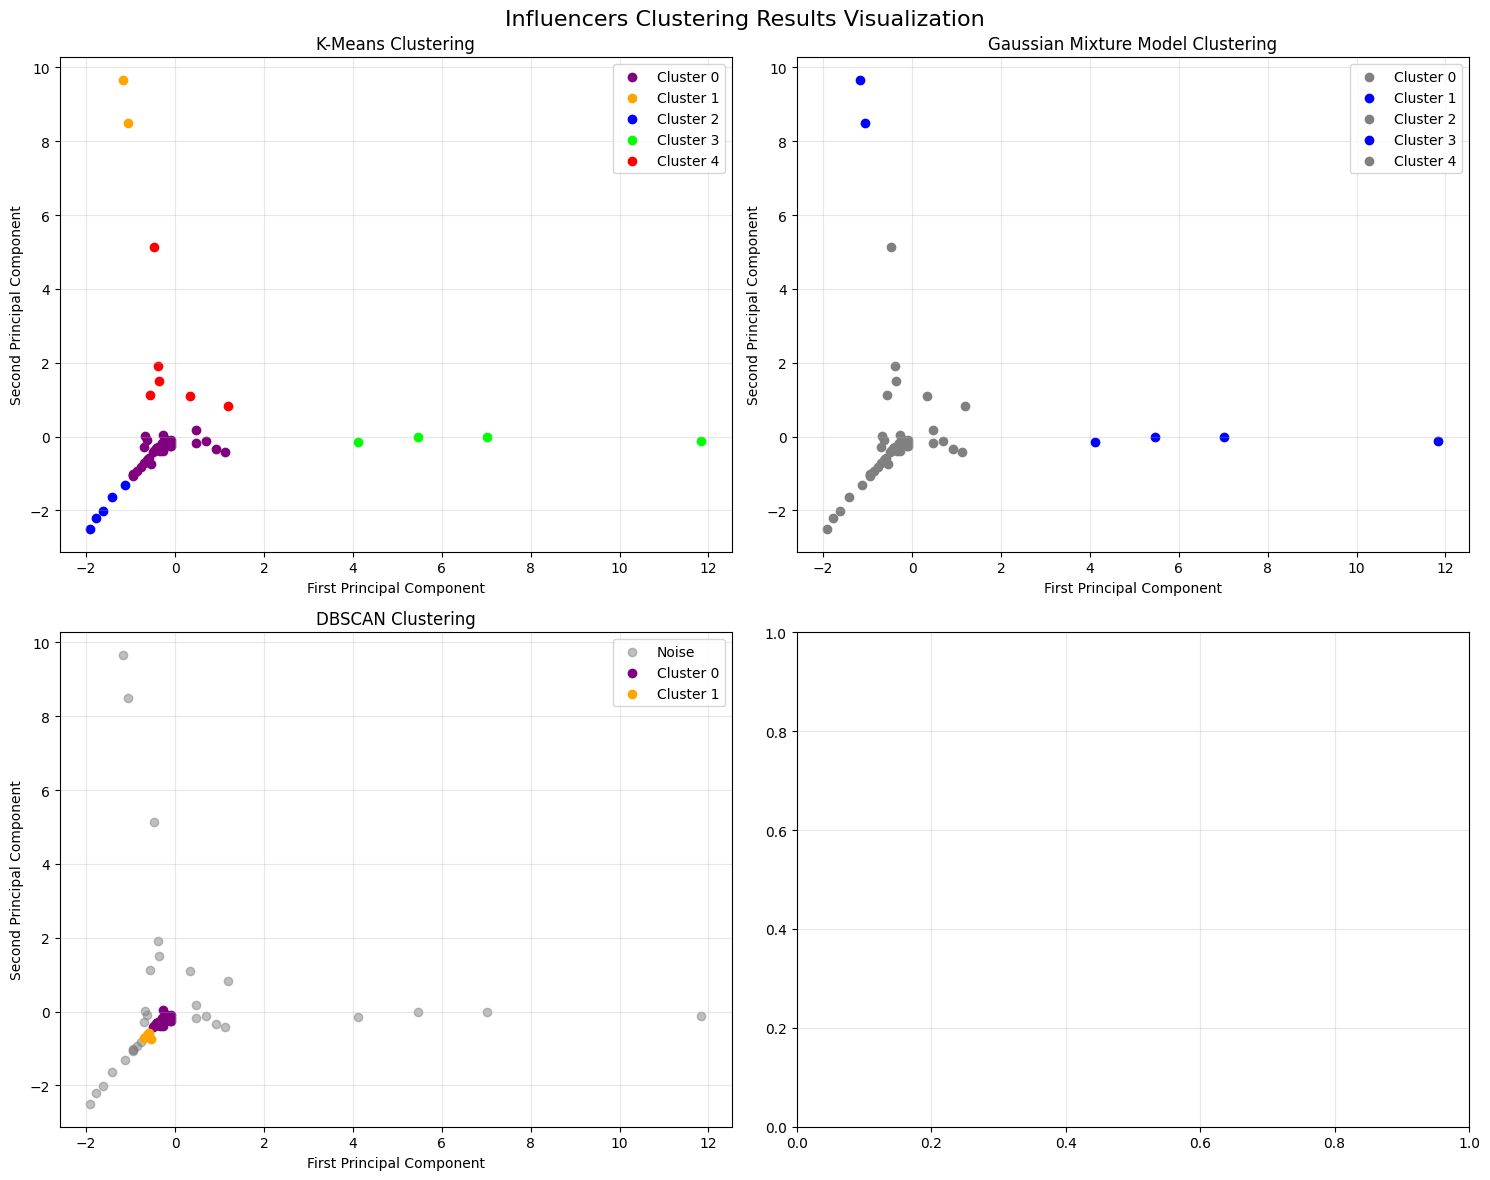


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 6.5981
Silhouette Score: 0.6430920982295619
Davies-Bouldin Score: 0.7520800820434178
Adjusted Rand Score: 0.21342693218978245

Cluster Sizes:
Cluster 0: 53 points
Cluster 1: 2 points
Cluster 2: 5 points
Cluster 3: 4 points
Cluster 4: 6 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 1.9030
Silhouette Score: 0.7029433089904258
Davies-Bouldin Score: 0.4626837323975961
Adjusted Rand Score: 0.17012388721645721

Cluster Sizes:
Cluster 0: 35 points
Cluster 1: 5 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 6.5981
Silhouette Score: 0.6430920982295619
Davies-Bouldin Score: 0.7520800820434178
Adjusted Rand Score: 0.21342693218978245

Cluster Sizes:
Cluster 0: 53 points
Cluster 1: 2 points
Cluster 2: 5 points
Cluster 3: 4 points
Cluster 4: 6 points

PCA Explained Variance Ratio:
PC1: 16.71%
PC2: 14.39%
PC3: 9.99%
PC4: 8.18%
PC5: 6.94%
Total Variance Explained (first 10 PCs

In [75]:
#implementing the algoritms in a part of uniques, the first 50 rows
results_Influencers_cluster = clustering_pipeline_all(Influencers,  pca_data_name='pca_data_Influencers',
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_Influencers_cluster, title_prefix='Influencers')
print_clustering_metrics(results_Influencers_cluster)

# 12. Clustering 3D Model df Influencers_uniques

In [76]:
# umpack data from results
pca_data = results_influencers_uniques_cluster[f'pca_data_influencers_uniques']
scaled_data = results_influencers_uniques_cluster['scaled_data']

# Now create the 3D plot
pc1 = pca_data[:, 0]
pc2 = pca_data[:, 1]
pc3 = pca_data[:, 2]

# Rest of your plotting code
fig = go.Figure(data=[
    go.Scatter3d(
        x=pc1,
        y=pc2,
        z=pc3,
        mode='markers',
        marker=dict(
            size=5,
            color=Influencers_uniques['Category'],
            colorscale='Viridis',
            opacity=0.8
        ),
        text=Influencers_uniques['Category']
    )
])

# Set plot title and axis labels
fig.update_layout(
    title='Interactive 3D PCA Visualization',
    scene=dict(
        xaxis_title='PCA Dimension 1',
        yaxis_title='PCA Dimension 2',
        zaxis_title='PCA Dimension 3'
    ))

fig.show()

## 12.1. On the Category and Cluster Atribution
Upon inspection of the influencers_OLS with the clusters associated to the label on the PCA_RF_FImportance notebook, there is a consistent pattern and it is possible to distinguish three different regions on the exact place the categories are.  category 1 is a v shape that is intop of cat 2 which is in the middle and 3 form a lineal regression bewen 1 and 2 pca, so together form a y shape. it has a clear differenciation and I can see that cluster 1 is same as cat 3, cluster 2, 3 and 0 are cat 1 and that cluster 4 is cat 2. with no visual overlappings, unlikely with my labels which got at the end of the regression line of 3 an overlaping with the shape of the v. So if we were to distribute the cluster in this fashion, would be possible to say that the clustering is revealing consistent groupings that align with the original categorization:  

Category 1: Comprises clusters 0, 2, 3  (total 7 points)  
Category 2: Corresponds to cluster 4    (10 points)  
Category 3: Matches cluster 1           (53 points)  
The fact that there is a persistent structure on the shapes of all the dataframes

Ultimately PCA primarily captures linear variance and might not effectively group data by absolute values. It's more about capturing directional variance and relationships rather than precise value clustering. The method projects data onto principal components that maximize variance, which doesn't necessarily mean it's capturing granular value-based distinctions
# 13. Loadings: On the Mapping of Original Features to the PCA
the principal components are mathematical combinations of the original features. It is possible to try to "invert" the PCA transformation to understand which original features are most responsible for the observed clustering patterns.
One approach would be to examine the PCA loading vectors or the contribution of each feature to the principal components. This could help identify the key underlying characteristics that are driving the separation of the data points. Moreover the cluster boundaries identified by the clustering algorithms are not fixed, static regions. They depend on the distribution of the data points and the specific parameters of the clustering methods. This means that the cluster assignments for individual data points may change if the clustering is performed again with different parameters or on a different dataset. The clustering results provide insights into the overall structure of the data, but the specific cluster boundaries are not guaranteed to be static or definitive.

The PCA loading vectors represent the coefficients that define each principal component. They indicate the relative importance or contribution of each original feature to the corresponding principal component.
By analyzing the loading vectors, it is possible to understand which of the original features are most influential in driving the separation of the data points along the different principal components. Which is very combinient because I am about to decide the selected data from each one of the dfs Influencers_OLS, OLS_all and uniques_23_OLS. By loading the vectors and identifying the original variables that more contribute to the separation, it would help with the selection of the selected genera to implement the cross examination with the physicochemical variables. With this loadings dataframe it is possible to  analyse the relationship with the original features across the principal components, by: higher absolute values = feature importance or features that contrute the most to the separation of the data points. By understand the dimension of the PCAs, then similar loading size hint similar aspects of the data or sinergistic effects?. By connecting clusters loading vectors to the clustering patterns and features, to know which are the most relevant features.

## 13.1 Loadinds Calculations and Visualisation Scripts
Here the relationships between features and components are visualised and highlight the absolute values of the loading vectors, as they represent the magnitude of feature contributions. An additional artifact is the category column.

In [77]:
def calculate_and_analyze_pca_loadings(df, pca, scaled_data_key, output_prefix):
    """
    Calculate and analyze PCA loadings for a given dataset.

    Parameters:
    df (pandas.DataFrame): The original DataFrame.
    pca (sklearn.decomposition.PCA): The PCA object from a previous analysis.
    scaled_data_key (str): The key in the results dictionary that holds the scaled data.
    output_prefix (str): A prefix for the output variables to ensure uniqueness.

    Returns:
    A dictionary containing the following keys:
    - f"{output_prefix}_loadings_df": The DataFrame of loading vectors.
    - f"{output_prefix}_top_loadings": A dictionary of top contributors for each principal component.
    - f"{output_prefix}_top_loadings_df": DataFrame of top contributors with categories.
    """
    loadings = pca.components_.T

    feature_columns = [col for col in df.columns if col != 'Category']

    loadings_df = pd.DataFrame(loadings, index=df.columns[1:],  # Feature column headers (numeric after 'Category')
                    columns=[f'PC{i+1}' for i in range(loadings.shape[1])])

    # Map categories by identifying their contribution strength for features
    # Add category weights
    category_weights = {1: 0.2, 2: 0.4, 3: 0.4}
    feature_categories = {}
    for feature in feature_columns:
        cat_means = {
            cat: df[df['Category'] == cat][int(feature)].mean() * category_weights[cat]
            for cat in [1, 2, 3]
        }
        feature_categories[feature] = max(cat_means.items(), key=lambda x: x[1])[0]

    # Identify top contributors to each principal component
    def get_top_loadings(loadings_df, n_top=10):
        top_loadings = {}
        for col in loadings_df.columns:
            top_loadings[col] = loadings_df[col].abs().nlargest(n_top)
        return top_loadings

    top_loadings = get_top_loadings(loadings_df)
    # Convert top_loadings to DataFrame and add category info

    top_loadings_df = pd.concat([pd.Series(loadings, name=pc) for pc,
                                 loadings in top_loadings.items()], axis=1)

    top_loadings_df.index.name = 'Feature'

    # Add these categories as a column in the top loadings DataFrame
    top_loadings_df['Category'] = pd.Series(feature_categories)

    # Store all results
    results = {
        f"{output_prefix}_loadings_df": loadings_df,
        f"{output_prefix}_top_loadings": top_loadings,
        f"{output_prefix}_top_loadings_df": top_loadings_df}  # Adding the categorized DataFrame

    return results

def plot_top_pca_loadings(results_dict, output_prefix, max_features=20, figsize=(10, 8)):
    """
    Plot a heatmap of top PCA loadings for given results.

    Parameters:
    - results_dict (dict): Results dictionary from calculate_and_analyze_pca_loadings.
    - output_prefix (str): Prefix for accessing correct results keys.
    - max_features (int): Max number of features to visualize for clarity.
    - figsize (tuple): Figure size for the heatmap.
    """
    top_loadings_df = results_dict[f"{output_prefix}_top_loadings_df"]
    top_n_features = top_loadings_df.iloc[:max_features, :-1]

    plt.figure(figsize=figsize)
    sns.heatmap(
        top_n_features, annot=True, cmap="coolwarm", center=0,
        cbar_kws={'label': 'Loading Magnitude'})

    plt.yticks(
        range(len(top_n_features)),
        [f"{idx} (Cat {cats})" for idx, cats in zip(top_loadings_df.index[:max_features], top_loadings_df['Category'][:max_features])],
        rotation=0
    )
    plt.title(f"Top PCA Loadings for {output_prefix}")
    plt.tight_layout()
    plt.show()

Calling the function to calculate and analyse the pca loadings for the dfs
## 13.2. original_pca Pca Loadings

Explained Variance Ratio: [0.13396565 0.11837093 0.10092034 0.09149917 0.08097643]
Cumulative Variance Ratio: [0.13396565 0.25233658 0.35325692 0.44475608 0.52573251]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
140  0.0681 -0.0998  0.2964 -0.0216  0.1530
575  0.1032 -0.0043 -0.0674 -0.2632  0.1652
687  0.0850 -0.1164  0.3295 -0.0455  0.1614
465 -0.0518  0.0101 -0.0884  0.2021  0.2099
300  0.0463 -0.1236  0.3577  0.0128  0.1289
529 -0.0910  0.2019  0.0702 -0.0284 -0.0374
609  0.0966  0.0020 -0.0574 -0.1961  0.1158
564 -0.1483  0.3395  0.1131  0.0326  0.1242
250  0.3263  0.1057  0.1029  0.1200 -0.0299
474  0.0181 -0.0752  0.1791  0.0139  0.0106

Top Contributors to Principal Components:

PC1 Top Contributors:
413   0.3386
546   0.3384
265   0.3374
720   0.3310
250   0.3263
512   0.3243
44    0.2722
145   0.2000
564   0.1483
13    0.1366
Name: PC1, dtype: float64

PC2 Top Contributors:
13    0.3502
187   0.3470
736   0.3470
662   0.3468
564   0.3395
727   0.3012
529   0.

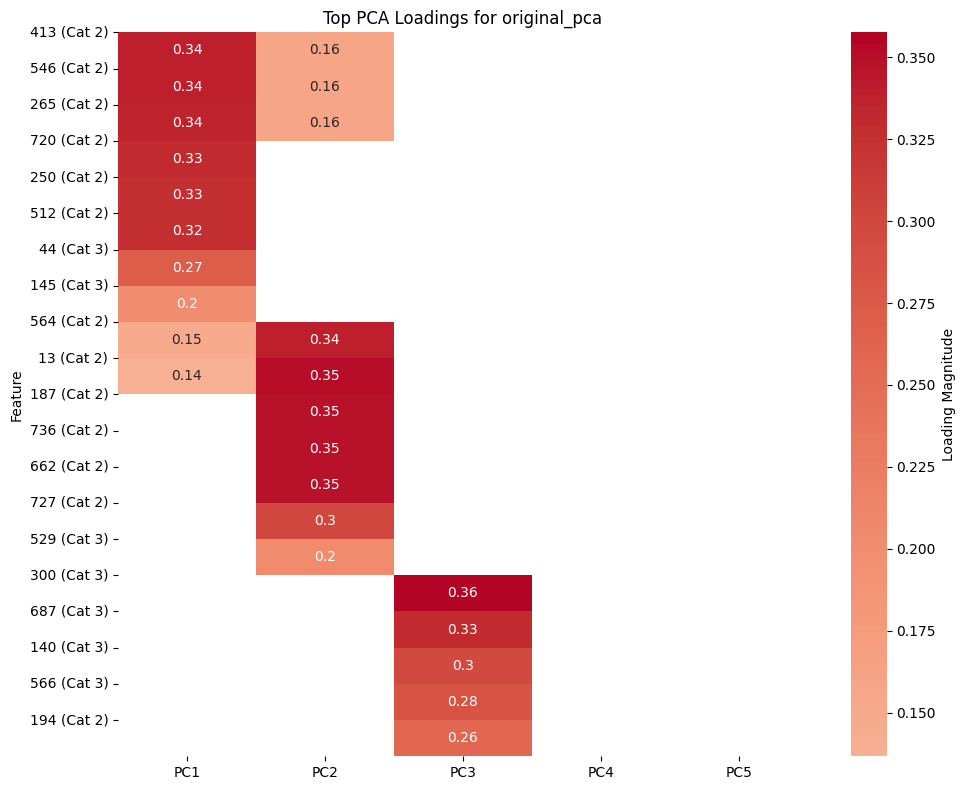

In [78]:
# We taking the data from the previous algoritms results
pca = results_original_pca_cluster['pca']
scaled_data = results_original_pca_cluster['scaled_data']
# Loadings calculation call
results_original_pca_Loadings = calculate_and_analyze_pca_loadings(original_pca, pca, 'scaled_data', 'original_pca')

# Access the results
loadings_df = results_original_pca_Loadings['original_pca_loadings_df']
explained_variance = results_original_pca_cluster['explained_variance']
cumulative_variance = results_original_pca_cluster['cumulative_variance']
top_loadings = results_original_pca_Loadings['original_pca_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings with category analysis (double heatmap):
plot_top_pca_loadings(results_original_pca_Loadings, 'original_pca')

### Discussing original_pca
The results show that some of the features overlap other such is 456. This feature wont be of much help when identifying the relevant bacteria influencing corrosion because it belong to two different categories. We need to make a script to select this features out.
## 13.3. OLS_all pca Loadings

Explained Variance Ratio: [0.21345052 0.14838367 0.10663281 0.08527754 0.06634886]
Cumulative Variance Ratio: [0.21345052 0.36183419 0.468467   0.55374454 0.6200934 ]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
725  0.0338  0.3851  0.0238  0.0026  0.0466
871  0.3293 -0.0791 -0.2282  0.0913  0.0083
428  0.1608  0.1362  0.2685 -0.0815  0.0928
214 -0.0656 -0.0598 -0.0939 -0.0921  0.5212
470 -0.0328 -0.0328 -0.0239 -0.0392 -0.0693
79   0.1961 -0.0288  0.3893  0.0035  0.1326
23   0.0259  0.4065 -0.0625 -0.0247  0.0672
91   0.1363 -0.0362  0.2151 -0.1372 -0.0510
88   0.0400  0.3454  0.0142  0.0119 -0.0138
480  0.3340 -0.0686 -0.0585  0.0115  0.0156

Top Contributors to Principal Components:

PC1 Top Contributors:
426   0.3404
480   0.3340
712   0.3303
871   0.3293
90    0.3241
625   0.3237
657   0.2937
549   0.2116
494   0.2099
79    0.1961
Name: PC1, dtype: float64

PC2 Top Contributors:
565   0.4122
23    0.4065
725   0.3851
605   0.3849
541   0.3699
88    0.3454
494   0.

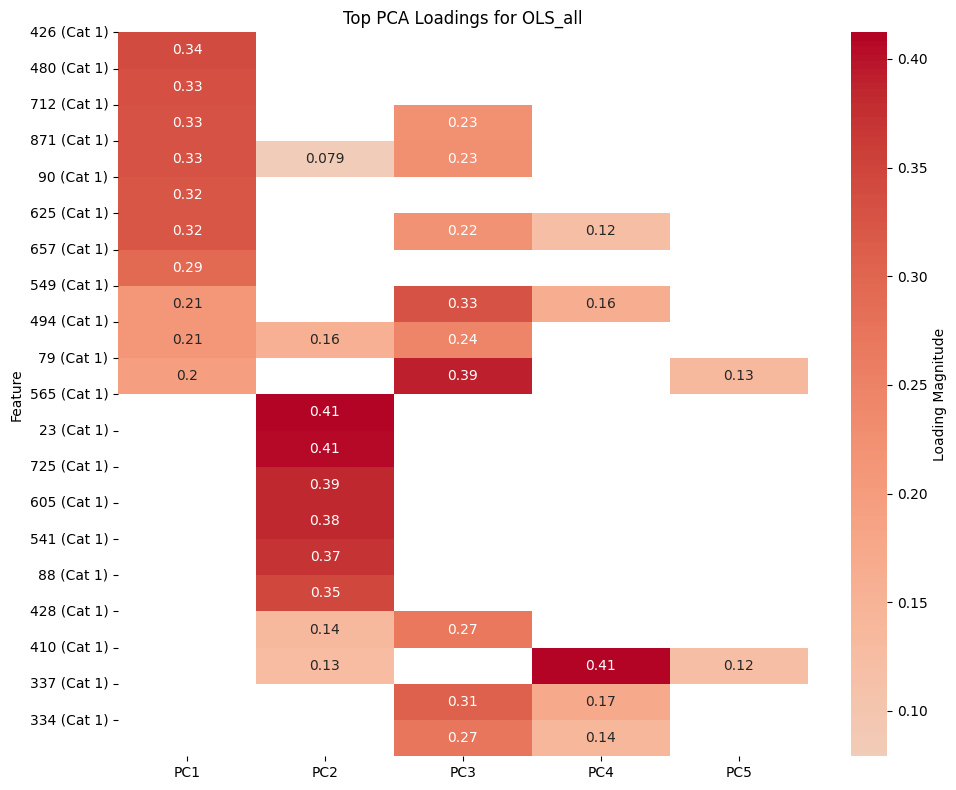

In [79]:
# We taking the data from the previous algoritms results
pca = results_OLS_all_cluster['pca']
scaled_data = results_OLS_all_cluster['scaled_data']
# Loadings calculation call
results_OLS_all_Loadings = calculate_and_analyze_pca_loadings(OLS_all, pca, 'scaled_data', 'OLS_all')

# Access the results
loadings_df = results_OLS_all_Loadings['OLS_all_loadings_df']
explained_variance = results_OLS_all_cluster['explained_variance']
cumulative_variance = results_OLS_all_cluster['cumulative_variance']
top_loadings = results_OLS_all_Loadings['OLS_all_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings with category analysis (double heatmap):
plot_top_pca_loadings(results_OLS_all_Loadings, 'OLS_all')

### Discussing OLS_all
This dataframe is composed by the significant genera by OLS analysis on the whole data and interestingly doesnt have any feature that belong to the category 2. The genera presenting strong contributions 565, 23, 725, 605, 799, 771, 410, all belong to the category 1 and the rest to category 3. 140, 214, 229

## 13.4. Influencers_OLS Pca Loadings

Explained Variance Ratio: [0.19122825 0.1640954  0.10924184 0.0915163  0.06725806]
Cumulative Variance Ratio: [0.19122825 0.35532365 0.46456549 0.55608179 0.62333985]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
725  0.3852  0.0133  0.0778  0.0580  0.1560
871 -0.0639  0.4981  0.2586 -0.1095 -0.0013
214 -0.0865 -0.1238  0.2747  0.1622  0.4173
351  0.2767 -0.0060  0.0575 -0.0500 -0.0493
23   0.4812  0.0266  0.1047  0.0583  0.0191
91  -0.0051  0.2152 -0.2902  0.3076 -0.1107
863  0.2320  0.0445 -0.1318  0.0041 -0.2558
526 -0.0764 -0.1041  0.1865  0.0501  0.5566
584 -0.0601 -0.0832  0.1729  0.0905  0.2839
712 -0.0642  0.4990  0.2570 -0.1063 -0.0000

Top Contributors to Principal Components:

PC1 Top Contributors:
23    0.4812
565   0.4489
864   0.4102
725   0.3852
351   0.2767
375   0.2663
863   0.2320
229   0.0957
214   0.0865
526   0.0764
Name: PC1, dtype: float64

PC2 Top Contributors:
712   0.4990
871   0.4981
625   0.4972
549   0.2934
91    0.2152
334   0.1610
678   0.

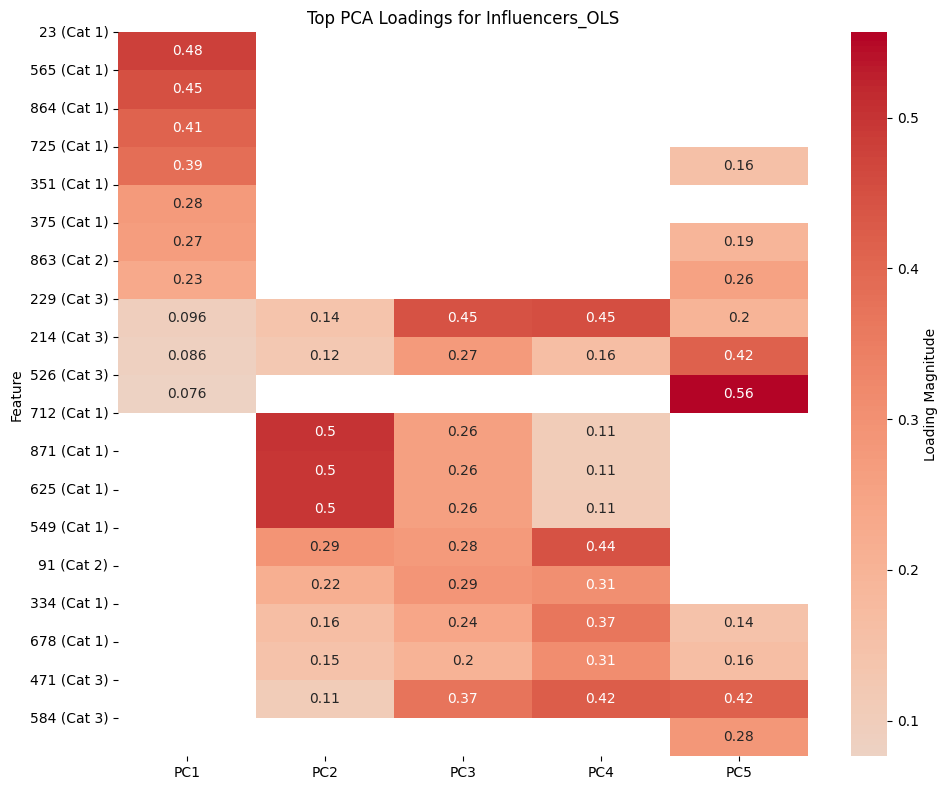

In [80]:
# We taking the data from the previous algoritms results
pca = results_Influencers_OLS_cluster['pca']
scaled_data = results_Influencers_OLS_cluster['scaled_data']
# Loadings calculation call
results_Influencers_OLS_Loadings = calculate_and_analyze_pca_loadings(Influencers_OLS, pca, 'scaled_data', 'Influencers_OLS')

# Access the results
loadings_df = results_Influencers_OLS_Loadings['Influencers_OLS_loadings_df']
explained_variance = results_Influencers_OLS_cluster['explained_variance']
cumulative_variance = results_Influencers_OLS_cluster['cumulative_variance']
top_loadings = results_Influencers_OLS_Loadings['Influencers_OLS_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_Influencers_OLS_Loadings, 'Influencers_OLS')

### Influencers_OLS Discussing
Top contributors for PC1 and PC2 are seen. These contributions suggest which original variables drive the variance along each principal axis. Loading values indicate the weight or influence of a feature on a principal component. In for Influencers_OLS feature 23 contributes 0,48 to PC1 and feature 712 contributes 0.499 to PC2.  
When puting 7 components the total explained variance ratio of the first 7 PCs is 74.19%.   
Strong contribution from PC1 to PC3. Cumulative explained variance achieves a balance of high dimensionality reduction with a reasonable representation. Total explained variance ratio of the first 7 PCs is 68.38%.
Reduced explained variance suggests the additional features do not significantly improve variance representation. In fact, they dilute the strength of the first PCs.
## 13.5. Influencers_uniques Pca Loadings

Explained Variance Ratio: [0.18418311 0.13881821 0.09477534 0.07775328 0.072638  ]
Cumulative Variance Ratio: [0.18418311 0.32300132 0.41777666 0.49552994 0.56816794]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
725  0.3255 -0.1359 -0.0413  0.2059  0.1069
871  0.0966  0.4862  0.1379  0.1118 -0.0530
214 -0.0760 -0.0598  0.2759  0.0257  0.1729
351  0.2423 -0.0823  0.0528 -0.1343 -0.0629
23   0.4177 -0.1283  0.0371 -0.0432  0.0636
91   0.0178  0.1610 -0.2532 -0.2193  0.2113
863  0.1762 -0.0499 -0.1302 -0.1574 -0.0706
526 -0.0685 -0.0505  0.2036  0.0180  0.0672
584 -0.0568 -0.0444  0.2169  0.0200  0.1377
712  0.0975  0.4879  0.1377  0.1107 -0.0504

Top Contributors to Principal Components: Influencers_uniques

PC1 Top Contributors:
23    0.4177
565   0.4154
541   0.3877
864   0.3487
725   0.3255
494   0.2775
351   0.2423
375   0.1934
863   0.1762
712   0.0975
Name: PC1, dtype: float64

PC2 Top Contributors:
712   0.4879
871   0.4862
625   0.4849
494   0.2798
549   0.2271
9

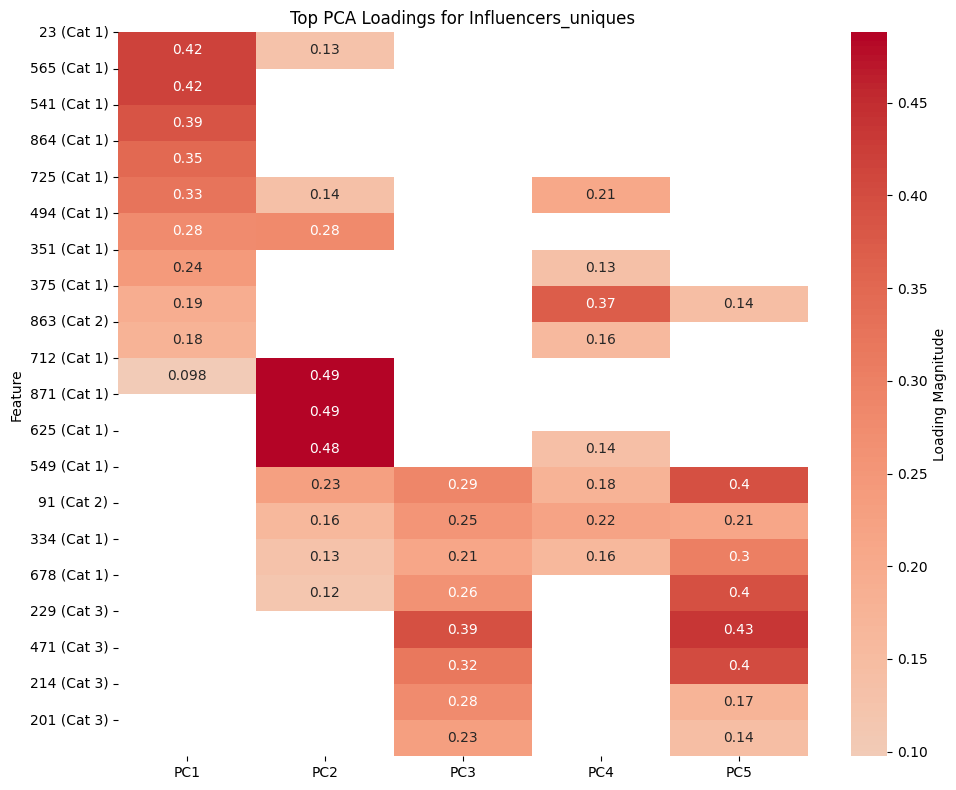

In [81]:
# We taking the data from the previous algoritms results
pca = results_influencers_uniques_cluster['pca']
scaled_data = results_influencers_uniques_cluster['scaled_data']
# Loadings calculation call
results_influencers_uniques_Loadings = calculate_and_analyze_pca_loadings(Influencers_uniques, pca,
                                                                 'scaled_data', 'Influencers_uniques')
# Access the results
loadings_df = results_influencers_uniques_Loadings['Influencers_uniques_loadings_df']
explained_variance = results_influencers_uniques_cluster['explained_variance']
cumulative_variance = results_influencers_uniques_cluster['cumulative_variance']
top_loadings = results_influencers_uniques_Loadings['Influencers_uniques_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components: Influencers_uniques")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_influencers_uniques_Loadings, 'Influencers_uniques')

In [82]:
Influencers_uniques.dtypes

Category      int64
725         float64
871         float64
214         float64
351         float64
23          float64
91          float64
863         float64
526         float64
584         float64
712         float64
625         float64
864         float64
678         float64
565         float64
408         float64
334         float64
549         float64
375         float64
471         float64
229         float64
541         float64
494         float64
201         float64
342         float64
410         float64
799         float64
dtype: object

### Discussing Influencers_uniques_selected Pca Loadings
## 13.6. Merged_selected Pca Loadings

Explained Variance Ratio: [0.2364268  0.15544553 0.13035581 0.12063869 0.10416161]
Cumulative Variance Ratio: [0.2364268  0.39187233 0.52222815 0.64286684 0.74702845]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
549 -0.0929 -0.0906 -0.0276 -0.4819 -0.3823
110 -0.0506 -0.0668  0.2163  0.7116 -0.1860
323  0.4869 -0.2416  0.2863 -0.1280  0.0307
270  0.0471 -0.0492 -0.4971 -0.2463 -0.3734
526  0.3344  0.5979  0.0540 -0.1087 -0.0359
491  0.0749  0.7214  0.0223  0.0132  0.0581
470 -0.0118 -0.0904 -0.3073 -0.1137  0.8071
140  0.5380 -0.1395 -0.2232  0.0865  0.0305
23   0.1798 -0.1108  0.6504 -0.3332  0.1016
214  0.5569 -0.0931 -0.2296  0.2022 -0.1074

Top Contributors to Principal Components:

PC1 Top Contributors:
214   0.5569
140   0.5380
323   0.4869
526   0.3344
23    0.1798
549   0.0929
491   0.0749
110   0.0506
270   0.0471
470   0.0118
Name: PC1, dtype: float64

PC2 Top Contributors:
491   0.7214
526   0.5979
323   0.2416
140   0.1395
23    0.1108
214   0.0931
549   0.

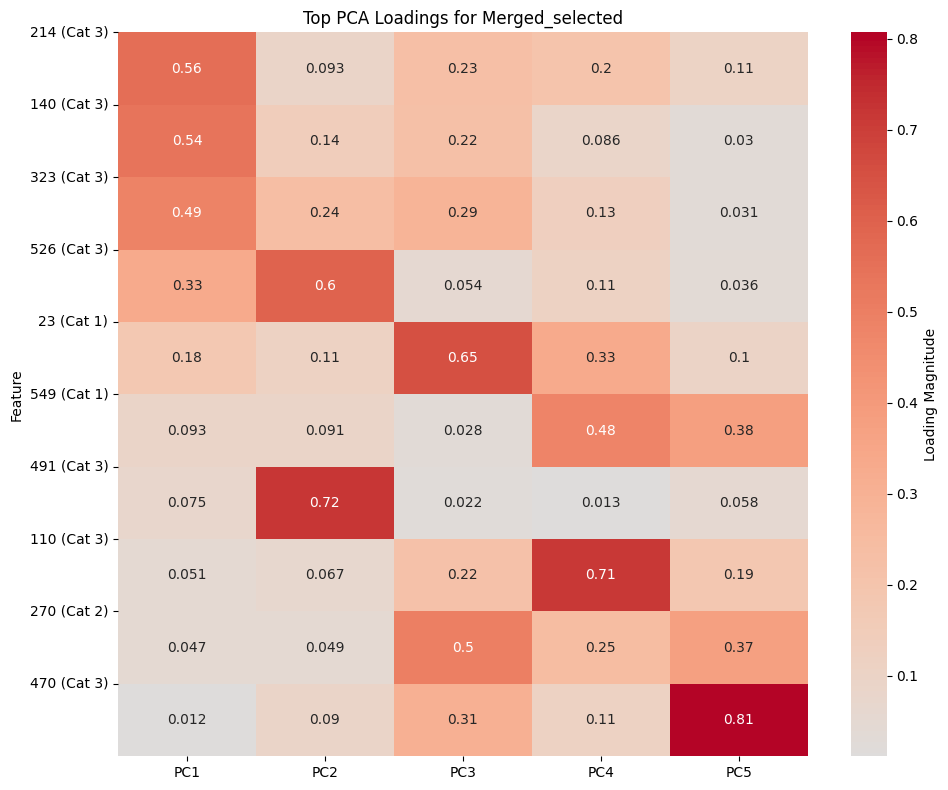

In [83]:
# We taking the data from the previous algoritms results
pca = results_Merged_selected_cluster['pca']
scaled_data = results_Merged_selected_cluster['scaled_data']
# Loadings calculation call
results_Merged_selected_Loadings = calculate_and_analyze_pca_loadings(Merged_selected, pca, 'scaled_data', 'Merged_selected')

# Access the results
loadings_df = results_Merged_selected_Loadings['Merged_selected_loadings_df']
explained_variance = results_Merged_selected_cluster['explained_variance']
cumulative_variance = results_Merged_selected_cluster['cumulative_variance']
top_loadings = results_Merged_selected_Loadings['Merged_selected_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_Merged_selected_Loadings, 'Merged_selected')

### Discussing Merged_selected
This df gives very strong signal for features 354 PC5 and also PC4. PC3 has some contributors such as 110, 491, 561, which could have some biological significance. Same for PC2 with 110, 549 and 18. PC1 could be represented only by 214, 140, 572 and 18.

## 13.7. old_new Loadings visualisation with category information

Explained Variance Ratio: [0.1522022  0.10808356 0.10036669 0.08906517 0.08381035]
Cumulative Variance Ratio: [0.1522022  0.26028576 0.36065245 0.44971762 0.53352797]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
154  0.3708 -0.2065  0.0708 -0.4036 -0.4479
201  0.2220  0.1116  0.0221  0.4880 -0.2678
214  0.4401 -0.1382  0.0430  0.0912  0.4985
229  0.5040 -0.2186  0.0893 -0.2987 -0.2585
334 -0.0631 -0.0411 -0.1595 -0.0395  0.0166
351 -0.1332 -0.0589  0.5990  0.0428 -0.0395
354 -0.1459 -0.1732  0.5315  0.0055  0.0658
408  0.2104  0.2478  0.1072  0.4239 -0.2159
497  0.4150 -0.1251  0.0645  0.1177  0.5271
512  0.1000  0.5844  0.1608 -0.2778  0.1202

Top Contributors to Principal Components:

PC1 Top Contributors:
229   0.5040
214   0.4401
497   0.4150
154   0.3708
201   0.2220
408   0.2104
584   0.2020
354   0.1459
351   0.1332
565   0.1280
Name: PC1, dtype: float64

PC2 Top Contributors:
512   0.5844
581   0.5607
606   0.2613
408   0.2478
229   0.2186
154   0.2065
354   0.

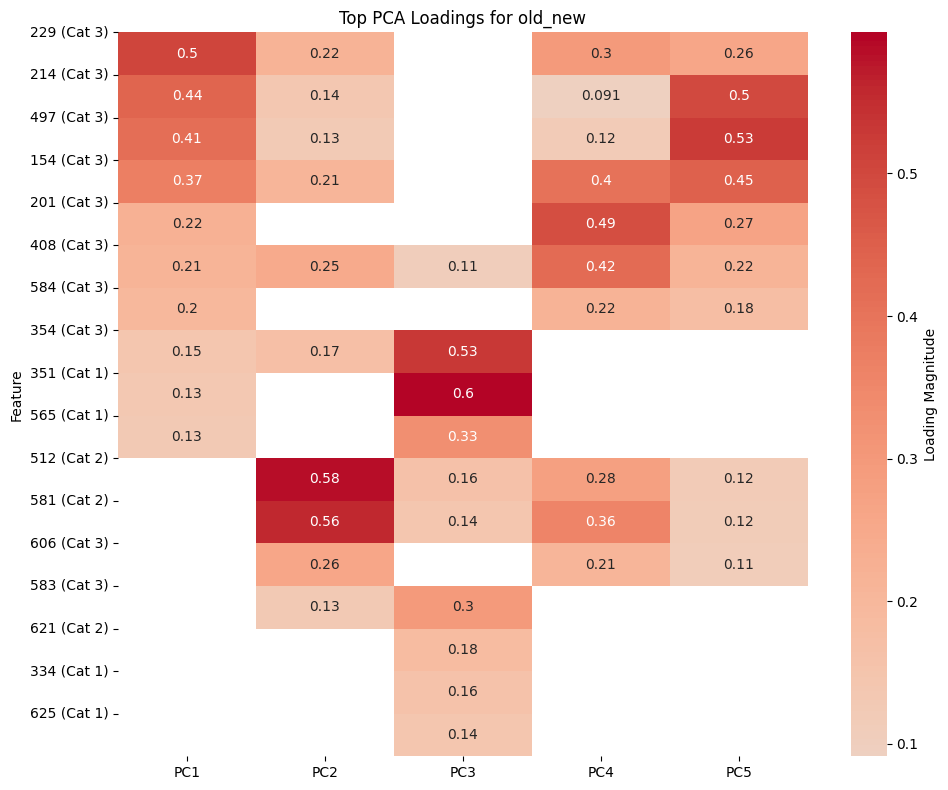

In [84]:
# We taking the data from the previous algoritms results
pca = results_old_new_cluster['pca']
scaled_data = results_old_new_cluster['scaled_data']
# Loadings calculation call
results_old_new_Loadings = calculate_and_analyze_pca_loadings(old_new, pca, 'scaled_data', 'old_new')

# Access the results
loadings_df = results_old_new_Loadings['old_new_loadings_df']
explained_variance = results_old_new_cluster['explained_variance']
cumulative_variance = results_old_new_cluster['cumulative_variance']
top_loadings = results_old_new_Loadings['old_new_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_old_new_Loadings, 'old_new')

## 13.9. Influencers Loadings visualisation with category information

Explained Variance Ratio: [0.16710058 0.14385289 0.09990205 0.08184916 0.06939643]
Cumulative Variance Ratio: [0.16710058 0.31095347 0.41085552 0.49270468 0.56210111]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
725  0.3828 -0.0040  0.0789  0.0737  0.0704
871 -0.0508  0.4888  0.2751 -0.0917  0.0666
214 -0.0922 -0.1288  0.2531  0.1638  0.0196
351  0.2758 -0.0169  0.0547 -0.0406  0.0410
23   0.4782  0.0042  0.1101  0.0729  0.0232
91   0.0035  0.2175 -0.2184  0.2419 -0.4044
863  0.2355  0.0388 -0.0932 -0.0404 -0.2765
526 -0.0809 -0.1075  0.1760  0.0611  0.0259
584 -0.0704 -0.0975  0.2004  0.1304 -0.0111
712 -0.0510  0.4897  0.2738 -0.0887  0.0653

Top Contributors to Principal Components:

PC1 Top Contributors:
23    0.4782
565   0.4456
864   0.4081
725   0.3828
351   0.2758
375   0.2648
863   0.2355
229   0.1025
214   0.0922
526   0.0809
Name: PC1, dtype: float64

PC2 Top Contributors:
712   0.4897
871   0.4888
625   0.4880
549   0.2964
91    0.2175
334   0.1643
678   0.

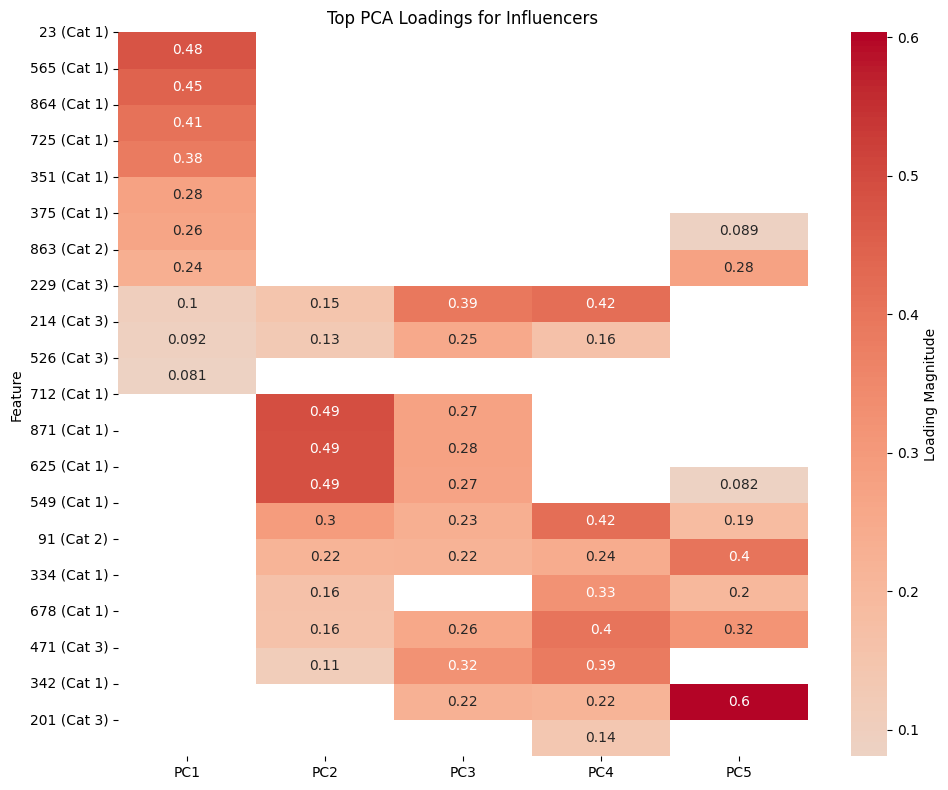

In [85]:
# We taking the data from the previous algoritms results
pca = results_Influencers_cluster['pca']
scaled_data = results_Influencers_cluster['scaled_data']
# Loadings calculation call
results_Influencers_Loadings = calculate_and_analyze_pca_loadings(Influencers, pca, 'scaled_data', 'Influencers')

# Access the results
loadings_df = results_Influencers_Loadings['Influencers_loadings_df']
explained_variance = results_Influencers_cluster['explained_variance']
cumulative_variance = results_Influencers_cluster['cumulative_variance']
top_loadings = results_Influencers_Loadings['Influencers_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_Influencers_Loadings, 'Influencers')

### Conclusions on Loadings Metrics
Looking at the loadings and PCA results across the datasets:
Influencers_OLS shows: Strongest contributors to PC1: 23, 565, 864, 725. PC2: 712, 871, 625, 549, Total variance explained by 5 PCs: 62.33%

Influencers_uniques shows: PC1 led by: 23, 565, 864, 725. PC2: 229, 549, 91, 471. Less total variance explained (54.63%)
Merged_selected shows:
Different pattern with PC1: 214, 323, 572, 526. PC2: 549, 18, 371, 110. Higher total variance explained (66.93%).

# 14. Selection
After analysing the loadings we can see that there are some overlapping between features being in the space of the different categories and therefore sort of overlapping as can be seen in the pc1 vs pc2, this in fact is from origing, that the features belog to different categories. This features can have an excellent metrics and the prediction powever be great, however the fact that exist on two different categories on the dataframes different as the dataframe "Influencers" is problematic. Therefore we select this features out moving forward. Influencers Dataset:Has OLS test of significance and has been filtered the overlapping features are statistically validated. They are proven to be meaningful through statistical testing. Instead other Datasets like original_pca, has no OLS validation and overlaps could be due to random variation, noise in the data, or false correlations. As a consequence same feature might show inconsistent behavior across categories, and there is less statistical guarantee that the overlap is meaningful. There is a marked underepresentation of cat 2 in the samples. Even when category 1 : has 17 samples, cat 2: 32 samples, cat 3: 21 samples.
However Cat 1 (no corrosion) and Cat 3 (corrosion) represent clear biological states, Cat 2 might not have unique markers, but rather transitional patterns. This could explain why finding "pure" Cat 2 features is difficult

## 14.1 Analysing Feature Categories using Loadings

In [86]:
def analyze_pca_feature_categories(top_loadings_df, df, analysis_name=""):
    """
    Analyze PCA features to identify their category distribution and overlaps. Includes ALL features in feature_loading_info, including those in multiple categories

    Parameters:
    - top_loadings_df: DataFrame containing PCA loadings and category information

    Returns:
    - Dictionary containing:
        - features_by_category: Dict of sets showing which features belong to each category
        - overlapping_features: Set of features that appear in multiple categories
        - feature_loading_info: Dict with loading information for unique features
    """
    category_weights = {1: 0.2, 2: 0.4, 3: 0.4}
    feature_categories = {
        feature: max({cat: df[df['Category'] == cat][int(feature)].mean() * category_weights[cat]
                     for cat in [1, 2, 3]}.items(),
                    key=lambda x: x[1])[0]
        for feature in top_loadings_df.index
    }

    # Organize by new assignments
    features_by_category = {}
    for feature, category in feature_categories.items():
        if category not in features_by_category:
            features_by_category[category] = set()
        features_by_category[category].add(feature)

    # Find overlapping features
    overlapping_features = set()
    category_pairs = [(1,2), (1,3), (2,3)]
    for cat1, cat2 in category_pairs:
        if cat1 in features_by_category and cat2 in features_by_category:
            overlap = features_by_category[cat1].intersection(features_by_category[cat2])
            if overlap:
                overlapping_features.update(overlap)
                print(f"Features in both Category {cat1} and {cat2}: {overlap}")

    # Get loading information using existing PCA loadings
    feature_loading_info = {}
    pc_columns = [col for col in top_loadings_df.columns if col.startswith('PC')]
    for feature in top_loadings_df.index:
        loading_values = top_loadings_df.loc[feature, pc_columns]
        max_loading = loading_values.max()
        feature_loading_info[feature] = {
            'category': top_loadings_df.loc[feature, 'Category'],
            'max_loading': max_loading,
            'loadings': dict(loading_values),
            'is_overlapping': feature in overlapping_features
        }

    return {
        'features_by_category': features_by_category,
        'overlapping_features': overlapping_features,
        'feature_loading_info': feature_loading_info
    }

def print_pca_category_analysis(analysis_results):
    """
    Print a formatted analysis of the PCA feature categories.

    Parameters: - analysis_results: Dictionary output from analyze_pca_feature_categories
    """
    print("Features by Category:")
    for cat, features in analysis_results['features_by_category'].items():
        print(f"Category {cat}: {sorted(features)}")

    print("\nOverlapping Features:")
    if analysis_results['overlapping_features']:
        for feature in sorted(analysis_results['overlapping_features']):
            info = analysis_results['feature_loading_info'][feature]
            print(f"Feature {feature}: Primary Category {info['category']}, Loading {info['max_loading']:.3f}")
    else:
        print("No overlapping features found")

    print("\nFeature Loading Information:")
    for feat, info in sorted(analysis_results['feature_loading_info'].items()):
        overlap_status = "Overlapping" if info['is_overlapping'] else "Unique"
        print(f"Feature {feat} (Category {info['category']}): {overlap_status}, Max loading = {info['max_loading']:.3f}")

## 14.2. original_pca loadings analysis by category

In [87]:
# Then analyze the category distribution
analysis_results_original_pca = analyze_pca_feature_categories(results_original_pca_Loadings['original_pca_top_loadings_df'], original_pca)
print_pca_category_analysis(analysis_results_original_pca)

#overlaping:
overlapping = analysis_results_original_pca['overlapping_features']

Features by Category:
Category 2: [13, 187, 194, 250, 265, 270, 413, 512, 542, 546, 564, 575, 662, 720, 727, 736]
Category 3: [39, 41, 44, 81, 140, 145, 300, 323, 389, 456, 474, 529, 566, 606, 687]
Category 1: [96, 127, 289, 465, 516, 591, 875]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 13 (Category 2): Unique, Max loading = 0.350
Feature 39 (Category 3): Unique, Max loading = 0.259
Feature 41 (Category 3): Unique, Max loading = 0.238
Feature 44 (Category 3): Unique, Max loading = 0.272
Feature 81 (Category 3): Unique, Max loading = 0.215
Feature 96 (Category 1): Unique, Max loading = 0.345
Feature 127 (Category 1): Unique, Max loading = 0.237
Feature 140 (Category 3): Unique, Max loading = 0.296
Feature 145 (Category 3): Unique, Max loading = 0.200
Feature 187 (Category 2): Unique, Max loading = 0.347
Feature 194 (Category 2): Unique, Max loading = 0.257
Feature 250 (Category 2): Unique, Max loading = 0.326
Feature 265 (Category 2): Uniq

### Discusing original_pca
this dataframe has a pool of features that do no overlap and that perhaps could be relevant to make up the final df
## 14.3. OLS_all Analysing Loadings by Category

In [88]:
# Then analyze the category distribution
analysis_results_OLS_all = analyze_pca_feature_categories(results_OLS_all_Loadings['OLS_all_top_loadings_df'],
                                                                    OLS_all)
print_pca_category_analysis(analysis_results_OLS_all)

# overlapping
overlapping = analysis_results_OLS_all['overlapping_features']

Features by Category:
Category 1: [23, 79, 88, 90, 334, 337, 342, 410, 426, 428, 480, 494, 541, 549, 565, 605, 625, 657, 678, 712, 725, 771, 799, 871]
Category 2: [91]
Category 3: [92, 140, 201, 214, 229, 584]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 23 (Category 1): Unique, Max loading = 0.407
Feature 79 (Category 1): Unique, Max loading = 0.389
Feature 88 (Category 1): Unique, Max loading = 0.345
Feature 90 (Category 1): Unique, Max loading = 0.324
Feature 91 (Category 2): Unique, Max loading = 0.137
Feature 92 (Category 3): Unique, Max loading = 0.150
Feature 140 (Category 3): Unique, Max loading = 0.544
Feature 201 (Category 3): Unique, Max loading = 0.212
Feature 214 (Category 3): Unique, Max loading = 0.521
Feature 229 (Category 3): Unique, Max loading = 0.389
Feature 334 (Category 1): Unique, Max loading = 0.272
Feature 337 (Category 1): Unique, Max loading = 0.308
Feature 342 (Category 1): Unique, Max loading = 0.239
Feature 410

### Discussing OLS_all category on loadings
dataframe OLS has no representation on category 2 but 1 and 3, we gather the features that present higher loading average than 0,35, to make the final dataframe alternative.

## 14.4. Merged_selected Analysing Loadings by Category

In [89]:
# Then analyze the category distribution
analysis_results_Merged_selected = analyze_pca_feature_categories(results_Merged_selected_Loadings['Merged_selected_top_loadings_df'], Merged_selected)
print_pca_category_analysis(analysis_results_Merged_selected )

# # overlapping
overlapping = analysis_results_Merged_selected ['overlapping_features']

Features by Category:
Category 3: [110, 140, 214, 323, 470, 491, 526]
Category 1: [23, 549]
Category 2: [270]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 23 (Category 1): Unique, Max loading = 0.650
Feature 110 (Category 3): Unique, Max loading = 0.712
Feature 140 (Category 3): Unique, Max loading = 0.538
Feature 214 (Category 3): Unique, Max loading = 0.557
Feature 270 (Category 2): Unique, Max loading = 0.497
Feature 323 (Category 3): Unique, Max loading = 0.487
Feature 470 (Category 3): Unique, Max loading = 0.807
Feature 491 (Category 3): Unique, Max loading = 0.721
Feature 526 (Category 3): Unique, Max loading = 0.598
Feature 549 (Category 1): Unique, Max loading = 0.482


## 14.5. Influencers_uniques Analysing Loadings by Category

In [90]:
# Then analyze the category distribution
analysis_results_Influencers_uniques = analyze_pca_feature_categories(results_influencers_uniques_Loadings['Influencers_uniques_top_loadings_df'],
                                                                    Influencers_uniques)
print_pca_category_analysis(analysis_results_Influencers_uniques)

# overlapping
overlapping = analysis_results_Influencers_uniques['overlapping_features']

Features by Category:
Category 1: [23, 334, 342, 351, 375, 410, 494, 541, 549, 565, 625, 678, 712, 725, 799, 864, 871]
Category 2: [91, 863]
Category 3: [201, 214, 229, 471, 584]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 23 (Category 1): Unique, Max loading = 0.418
Feature 91 (Category 2): Unique, Max loading = 0.253
Feature 201 (Category 3): Unique, Max loading = 0.232
Feature 214 (Category 3): Unique, Max loading = 0.276
Feature 229 (Category 3): Unique, Max loading = 0.435
Feature 334 (Category 1): Unique, Max loading = 0.304
Feature 342 (Category 1): Unique, Max loading = 0.230
Feature 351 (Category 1): Unique, Max loading = 0.242
Feature 375 (Category 1): Unique, Max loading = 0.370
Feature 410 (Category 1): Unique, Max loading = 0.595
Feature 471 (Category 3): Unique, Max loading = 0.400
Feature 494 (Category 1): Unique, Max loading = 0.280
Feature 541 (Category 1): Unique, Max loading = 0.388
Feature 549 (Category 1): Unique, Max 

## 14.6. Influencers_OLS Analyis Loadings by Category

In [91]:
# Then analyze the category distribution
analysis_results_Influencers_OLS = analyze_pca_feature_categories(results_Influencers_OLS_Loadings['Influencers_OLS_top_loadings_df'],
                                                                    Influencers_OLS)
print_pca_category_analysis(analysis_results_Influencers_OLS )

# overlapping
overlapping = analysis_results_Influencers_OLS['overlapping_features']

Features by Category:
Category 1: [23, 334, 351, 375, 549, 565, 625, 678, 712, 725, 864, 871]
Category 2: [91, 863]
Category 3: [214, 229, 471, 526, 584]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 23 (Category 1): Unique, Max loading = 0.481
Feature 91 (Category 2): Unique, Max loading = 0.308
Feature 214 (Category 3): Unique, Max loading = 0.417
Feature 229 (Category 3): Unique, Max loading = 0.452
Feature 334 (Category 1): Unique, Max loading = 0.367
Feature 351 (Category 1): Unique, Max loading = 0.277
Feature 375 (Category 1): Unique, Max loading = 0.266
Feature 471 (Category 3): Unique, Max loading = 0.424
Feature 526 (Category 3): Unique, Max loading = 0.557
Feature 549 (Category 1): Unique, Max loading = 0.443
Feature 565 (Category 1): Unique, Max loading = 0.449
Feature 584 (Category 3): Unique, Max loading = 0.284
Feature 625 (Category 1): Unique, Max loading = 0.497
Feature 678 (Category 1): Unique, Max loading = 0.313
Feature 7

Since Influencers_OLS presents a better visualistion than Influencers_uniques_selected, but the final has better metrics, there is no point to have these two dataframes separated, actually they are very similar except for some features. So since the most important part is to analyse the biological significance, we integrate this two dfs moving forward.


## 14.7 old_new Loadings on Category

In [92]:
# Then analyze the category distribution
analysis_results_old_new = analyze_pca_feature_categories(results_old_new_Loadings['old_new_top_loadings_df'],
                                                                    old_new)
print_pca_category_analysis(analysis_results_old_new)

# overlapping
overlapping = analysis_results_old_new['overlapping_features']

Features by Category:
Category 3: [154, 201, 214, 229, 354, 408, 497, 583, 584, 606]
Category 1: [334, 351, 565, 625]
Category 2: [512, 581, 621]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 154 (Category 3): Unique, Max loading = 0.448
Feature 201 (Category 3): Unique, Max loading = 0.488
Feature 214 (Category 3): Unique, Max loading = 0.499
Feature 229 (Category 3): Unique, Max loading = 0.504
Feature 334 (Category 1): Unique, Max loading = 0.160
Feature 351 (Category 1): Unique, Max loading = 0.599
Feature 354 (Category 3): Unique, Max loading = 0.532
Feature 408 (Category 3): Unique, Max loading = 0.424
Feature 497 (Category 3): Unique, Max loading = 0.527
Feature 512 (Category 2): Unique, Max loading = 0.584
Feature 565 (Category 1): Unique, Max loading = 0.328
Feature 581 (Category 2): Unique, Max loading = 0.561
Feature 583 (Category 3): Unique, Max loading = 0.297
Feature 584 (Category 3): Unique, Max loading = 0.218
Feature 606 (Ca

## 14.9. influencers Loadings on Category

In [93]:
# Then analyze the category distribution
analysis_results_Influencers = analyze_pca_feature_categories(results_Influencers_Loadings['Influencers_top_loadings_df'],
                                                                    Influencers)
print_pca_category_analysis(analysis_results_Influencers)

# overlapping
overlapping = analysis_results_Influencers['overlapping_features']

Features by Category:
Category 1: [23, 334, 342, 351, 375, 549, 565, 625, 678, 712, 725, 799, 864, 871]
Category 2: [91, 863]
Category 3: [201, 214, 229, 408, 471, 526, 584]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 23 (Category 1): Unique, Max loading = 0.478
Feature 91 (Category 2): Unique, Max loading = 0.404
Feature 201 (Category 3): Unique, Max loading = 0.138
Feature 214 (Category 3): Unique, Max loading = 0.253
Feature 229 (Category 3): Unique, Max loading = 0.418
Feature 334 (Category 1): Unique, Max loading = 0.326
Feature 342 (Category 1): Unique, Max loading = 0.604
Feature 351 (Category 1): Unique, Max loading = 0.276
Feature 375 (Category 1): Unique, Max loading = 0.265
Feature 408 (Category 3): Unique, Max loading = 0.096
Feature 471 (Category 3): Unique, Max loading = 0.386
Feature 526 (Category 3): Unique, Max loading = 0.081
Feature 549 (Category 1): Unique, Max loading = 0.415
Feature 565 (Category 1): Unique, Max loadi

## 14.10 On the making of a high_loadings_df
we doing a comprehensive list of possible relevant features that are relevant to each category. From the makers of function __analyze_pca_feature_categories__ and __results_dfs_Loadings['df_top_loadings']__ it is presented here the combination of this dataframes
Let's create the joined dataframe with all the selected features from our analyses. From the makers of analysing
| df | Features by Category |
|---|---|
| Merged_selected | Category 3: [110, 140, 214, 470, 491, 526] Category 1: [23, 323, 549] Category 2: [270] |
| Influencers_uniques| Category 1: [23, 91, 334, 342, 351, 375, 549, 565, 625, 678, 712, 725, 799, 864, 871] Category 2: [863]Category 3: [201, 214, 229, 408, 471, 526, 584]|
| old_new | Category 3: [214, 229, 354, 408, 497, 583, 584] Category 1: [334, 351, 565, 606, 625] Category 2: [512, 581, 621] |


In [94]:
def combine_features_from_analyses(analysis_results_old_new, analysis_results_Merged_selected,
                                    analysis_results_Influencers_uniques, loading_threshold=0.2):
    """
    Combine features from different analyses with threshold and deduplication.
    Works with output from analyze_pca_feature_categories() function.
    Now includes explicit tracking of features appearing in multiple categories.

    Parameters:
    -----------
    analysis_results_* : dict
        Results from analyze_pca_feature_categories() for each analysis
    loading_threshold : float, optional (default=0.2)
        Minimum loading value to consider a feature relevant

    Returns:
    --------
    tuple : (feature_list, selected_features)
        feature_list : list with 'Category' and selected features
        selected_features : dict with feature information
    """
    selected_features = {}
    feature_categories = {}  # Track all categories where each feature appears

    # Dictionary mapping analysis results to their source names
    analyses = {
        'old_new': analysis_results_old_new,
        'Merged_selected': analysis_results_Merged_selected,
        'Influencers_uniques': analysis_results_Influencers_uniques
    }

    # Process each analysis
    for source_name, analysis in analyses.items():
        print(f"\nProcessing features from {source_name}")

        for feature, info in analysis['feature_loading_info'].items():
            # Skip features below threshold
            if abs(info['max_loading']) < loading_threshold:
                continue

            if feature not in selected_features:
                selected_features[feature] = {
                    'category': info['category'],
                    'max_loading': abs(info['max_loading']),
                    'source': source_name,
                    'all_categories': {info['category']}  # Track all categories where feature appears
                }
                # Initialize feature category tracking
                if feature not in feature_categories:
                    feature_categories[feature] = {info['category']}
                else:
                    feature_categories[feature].add(info['category'])
            else:
                # Add category to tracking
                feature_categories[feature].add(info['category'])
                selected_features[feature]['all_categories'].add(info['category'])

                # Print overlap information
                print(f"\nFeature {feature} found in multiple analyses:")
                print(f"Current: {source_name}, loading={abs(info['max_loading']):.3f}, category={info['category']}")
                print(f"Previous: {selected_features[feature]['source']}, "
                      f"loading={selected_features[feature]['max_loading']:.3f}, "
                      f"category={selected_features[feature]['category']}")

                # Keep the version with higher loading
                if abs(info['max_loading']) > selected_features[feature]['max_loading']:
                    selected_features[feature].update({
                        'category': info['category'],
                        'max_loading': abs(info['max_loading']),
                        'source': source_name
                    })
                    print(f"Keeping version from {source_name} due to higher loading")

    # Create feature list with 'Category' first
    feature_list = [['Sites', 'Category']] + list(selected_features.keys())

    # Print summary by category and source
    print("\nFeature Selection Summary:")
    for category in sorted(set(info['category'] for info in selected_features.values())):
        features = [f for f, info in selected_features.items() if info['category'] == category]
        print(f"\nCategory {category} features ({len(features)}):")
        print(f"Features: {sorted(features)}")

    # Print multi-category features
    print("\nFeatures appearing in multiple categories:")
    multi_category_features = {
        feature: categories
        for feature, categories in feature_categories.items()
        if len(categories) > 1
    }

    if multi_category_features:
        for feature, categories in multi_category_features.items():
            print(f"\nFeature {feature}:")
            print(f"  Categories: {sorted(categories)}")
            print(f"  Current assignment: Category {selected_features[feature]['category']} "
                  f"(from {selected_features[feature]['source']} "
                  f"with loading {selected_features[feature]['max_loading']:.3f})")
    else:
        print("No features appear in multiple categories")

    print("\nFeatures by source:")
    for source in analyses.keys():
        source_features = [f for f, info in selected_features.items() if info['source'] == source]
        print(f"\n{source} features ({len(source_features)}):")
        for feature in sorted(source_features):
            info = selected_features[feature]
            print(f"Feature {feature}: Category {info['category']}, Loading {info['max_loading']:.3f}")

    return feature_list, selected_features

def create_combined_feature_df(original_df, feature_list, selected_features):
    """
    Create a dataframe with selected features and their metadata.

    Parameters:
    -----------
    original_df : pd.DataFrame
        Original dataframe containing all features
    feature_list : list
        List of features from combine_features_from_analyses()
    selected_features : dict
        Feature information from combine_features_from_analyses()

    Returns:
    --------
    pd.DataFrame
        Combined dataframe with selected features and metadata
    """
# Debug print
    print("Feature list:", feature_list)

    # Flatten feature list and remove 'Category'
    flat_features = []
    for item in feature_list:
        if isinstance(item, list):
            flat_features.extend(item)
        else:
            flat_features.append(item)

    feature_list_clean = [f for f in flat_features if f != 'Category']

    # Convert to ints
    numeric_features = [int(f) for f in feature_list_clean if f not in ['Sites', 'Category']]

    # Create columns list
    columns = ['Category'] + numeric_features

    # Create DataFrame
    combined_df = original_df[columns].copy()

    # Add metadata
    combined_df.attrs['feature_sources'] = {
        feature: f"{info['source']} ({info['max_loading']:.3f})"
        for feature, info in selected_features.items()
        if feature != 'Category'
    }

    return combined_df

In [95]:
# calling the function
feature_list, selected_features = combine_features_from_analyses(analysis_results_old_new, analysis_results_Merged_selected, analysis_results_Influencers_uniques,
                                            loading_threshold=0.2)

# Create combined dataframe
high_loadings = create_combined_feature_df(original, feature_list, selected_features)


Processing features from old_new

Processing features from Merged_selected

Feature 214 found in multiple analyses:
Current: Merged_selected, loading=0.557, category=3
Previous: old_new, loading=0.499, category=3
Keeping version from Merged_selected due to higher loading

Processing features from Influencers_uniques

Feature 23 found in multiple analyses:
Current: Influencers_uniques, loading=0.418, category=1
Previous: Merged_selected, loading=0.650, category=1

Feature 565 found in multiple analyses:
Current: Influencers_uniques, loading=0.415, category=1
Previous: old_new, loading=0.328, category=1
Keeping version from Influencers_uniques due to higher loading

Feature 351 found in multiple analyses:
Current: Influencers_uniques, loading=0.242, category=1
Previous: old_new, loading=0.599, category=1

Feature 549 found in multiple analyses:
Current: Influencers_uniques, loading=0.396, category=1
Previous: Merged_selected, loading=0.482, category=1

Feature 229 found in multiple anal

Looking at the analysis, the old_new data has good or even better representation from class 2, and I'm not entirely convinced that OLS_all's data is that relevant. There's a significant imbalance in class 2 representation, which is puzzling given that in reality the sample distribution was: class 1 (17 samples), class 2 (32 samples), and class 3 (21 samples). Currently, category 2 features are very limited, coming only from:

Influencers: just one feature (863); Merged_selected: one feature (270); old_new data: two features (512, 581)

There are still class 2 features from original_pca that I'm unsure whether to use, since those only got an influence pca test undergoing and no an OLS significance test and were also no accounted by abundancy and frequency as the Influencers dataframe were. My strategy is to create a new dataframe from this selection and analyze which features from classes 1 and 3 fall into the space of class 2, and then trim them out. For this purpose, a script on the next section 15.2 is created in 3D scatter plot that relates PCA to loadings to original data.

### Verification High_loading_genera

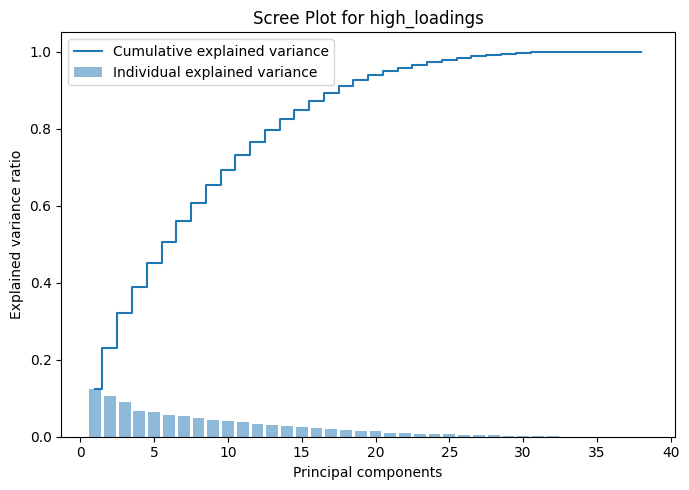

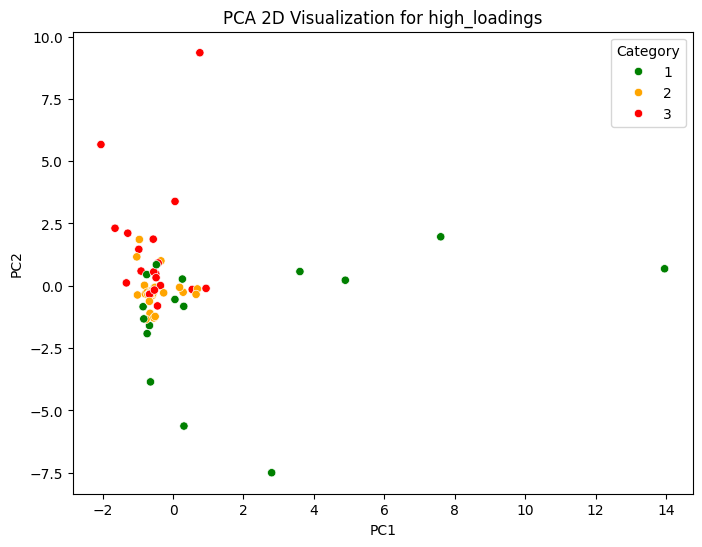

high_loadings_pipeline:
high_loadings_pipeline:
Cross-Validation MAE Scores for RF: [0.6508, 0.7545, 0.4364, 0.3345, 0.4718]
Average MAE for RF: 0.5296
Mean Squared Error: 0.2827
Root Mean Squared Error: 0.5317
Mean Absolute Error: 0.395
Feature Importance by RF:     Features  Importance
18       549      0.3403
21       270      0.0784
20       110      0.0641
15       323      0.0463
16       526      0.0445
14       140      0.0413
7        354      0.0386
22       470      0.0383
27       375      0.0358
19       491      0.0334
1        214      0.0268
17        23      0.0254
5        408      0.0245
8        351      0.0213
0        229      0.0178
24       864      0.0159
32       334      0.0151
30       625      0.0140
13       583      0.0123
29       871      0.0122
31        91      0.0082
33       678      0.0079
12       606      0.0066
11       581      0.0041
3        154      0.0034
high_loadings_pipeline:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.5833, 0.4545, 0.7273, 0.6364, 0.7273]
Average Accuracy: 0.6258
Precision: [0.4826, 0.2273, 0.7792, 0.7121, 0.7636]
Average Precision: 0.593
Recall: [0.5833, 0.4545, 0.7273, 0.6364, 0.7273]
Average Recall: 0.6258
F1-Score: [0.511, 0.303, 0.697, 0.6228, 0.7273]
Average F1-Score: 0.5722

Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [1 4 2]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       0.50      0.57      0.53         7
           3       0.33      0.25      0.29         4

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.50        14
weighted avg       0.49      0.50      0.49        14


Feature Importance:
    Features  Importance
18       549      0.1112
20       110      0.0654
16       526      0.0611
19       491      0.0543
14       140      0.0504
21       270      0.0490
15     

In [96]:
# Aply pipeline for visual results
results_high_loadings = pca_pipeline(high_loadings, 'Category', n_components=2, dataset_name='high_loadings')

# Apply the pipeline for numerical results
high_loadings_pipeline, df_pca_influence_high_loadings, explained_variance_high_loadings, n_components = apply_pipeline_pca(high_loadings, "high_loadings", n_components=2, n_top_features=20)

# Apply pipeline Regression
high_loadings_pipeline_reg, importances_reg_high_loadings= apply_pipeline_regressor(high_loadings, "high_loadings")
# Apply the pipeline Classification
high_loadings_pipe_class, importances_class_high_loadings = apply_classification_pipeline_classif(high_loadings, "high_loadings")

Acuracy is reduce and the metrics are no as good as the smaller set of Influencers_OLS, however it is a set that is more comprehensive and has bigger set of features that could posses a biological significate, the patterns of the pca can be misleading since this is just 2d, however the categories 1 and 3 are very well defined on their own planes, with category 2 presented on a middle space with many problematic overlaps.

### Highloadings clustering

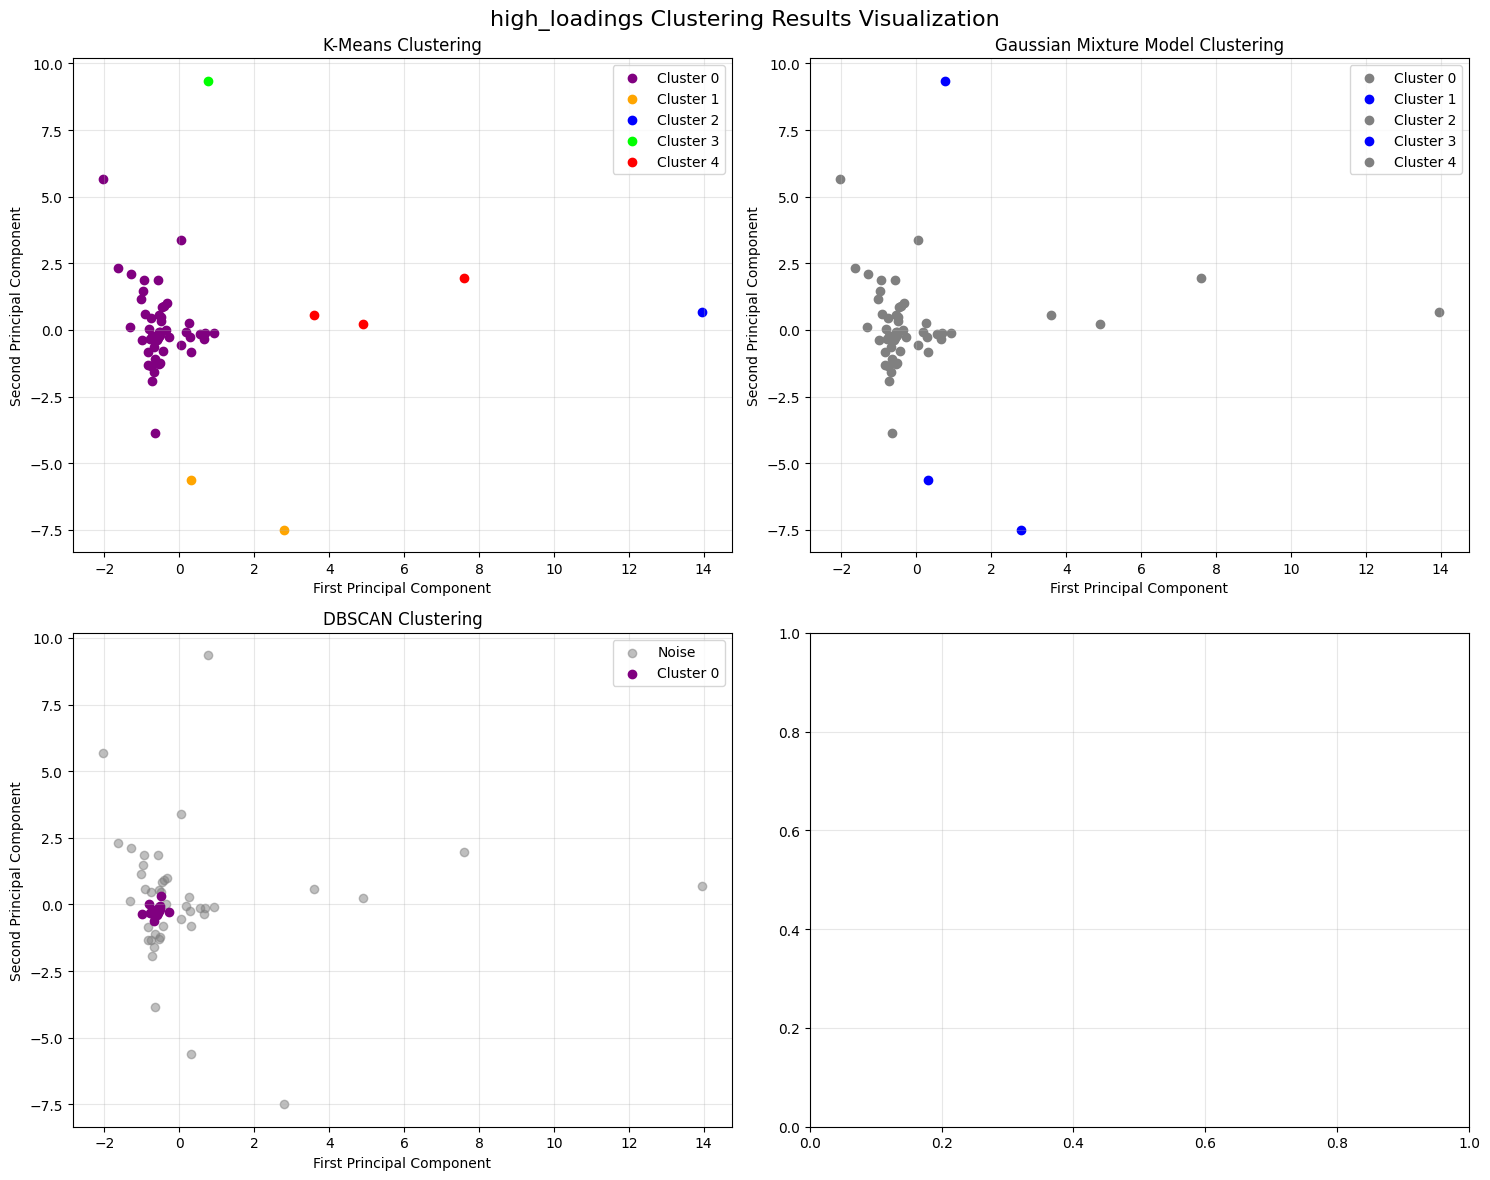


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 8.4001
Silhouette Score: 0.5999945803916107
Davies-Bouldin Score: 0.5231617672137584
Adjusted Rand Score: 0.0874025006372696

Cluster Sizes:
Cluster 0: 63 points
Cluster 1: 2 points
Cluster 2: 1 points
Cluster 3: 1 points
Cluster 4: 3 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 2.3044
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.12735618812082558

Cluster Sizes:
Cluster 0: 27 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 8.4001
Silhouette Score: 0.5999945803916107
Davies-Bouldin Score: 0.5231617672137584
Adjusted Rand Score: 0.0874025006372696

Cluster Sizes:
Cluster 0: 63 points
Cluster 1: 2 points
Cluster 2: 1 points
Cluster 3: 1 points
Cluster 4: 3 points

PCA Explained Variance Ratio:
PC1: 12.49%
PC2: 10.59%
PC3: 8.96%
PC4: 6.73%
PC5: 6.31%
Total Variance Explained (first 10 PCs): 45.08%


In [97]:
# Running pipeline
results_high_loadings_cluster = clustering_pipeline_all(high_loadings,  pca_data_name='pca_data_high_loadings ',
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_high_loadings_cluster, title_prefix='high_loadings')
print_clustering_metrics(results_high_loadings_cluster )

Analysing the clustering mapping with the original pca where the risk labels are distingushed, it is possible to note the correspondence of category 1 with clusters 0 and 4, category 2 being overhelminly mixed up corresponding to cluster 2 roughly and category 3 distintive clusters 1 and 3.

### high_loadings Analysing and visualising Calculate_and_analyze_pca_loadings

Explained Variance Ratio: [0.12492731 0.10592431 0.08960053 0.06725789 0.06312241]
Cumulative Variance Ratio: [0.12492731 0.23085162 0.32045215 0.38771004 0.45083245]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
229 -0.0563  0.3066  0.2624  0.2922 -0.2176
214 -0.0109  0.3130  0.2425 -0.2721  0.0221
497  0.0049  0.3041  0.2480 -0.3100  0.0527
154 -0.0578  0.2044  0.1842  0.4288 -0.2711
201 -0.0367  0.1120  0.0671  0.0357  0.1069
408 -0.0663  0.1091  0.0383  0.0429  0.1943
584 -0.0202  0.1375  0.0856  0.0192  0.0953
354 -0.0101 -0.0161 -0.0830  0.0725  0.2519
351  0.2334  0.0172 -0.0722  0.1414  0.1845
565  0.4149  0.0257 -0.0524  0.1096  0.0439

Top Contributors to Principal Components:

PC1 Top Contributors:
23    0.4178
565   0.4149
541   0.3791
725   0.3512
864   0.3059
494   0.2502
323   0.2409
351   0.2334
375   0.2326
410   0.1200
Name: PC1, dtype: float64

PC2 Top Contributors:
214   0.3130
140   0.3081
229   0.3066
497   0.3041
625   0.3006
712   0.2996
871   0.

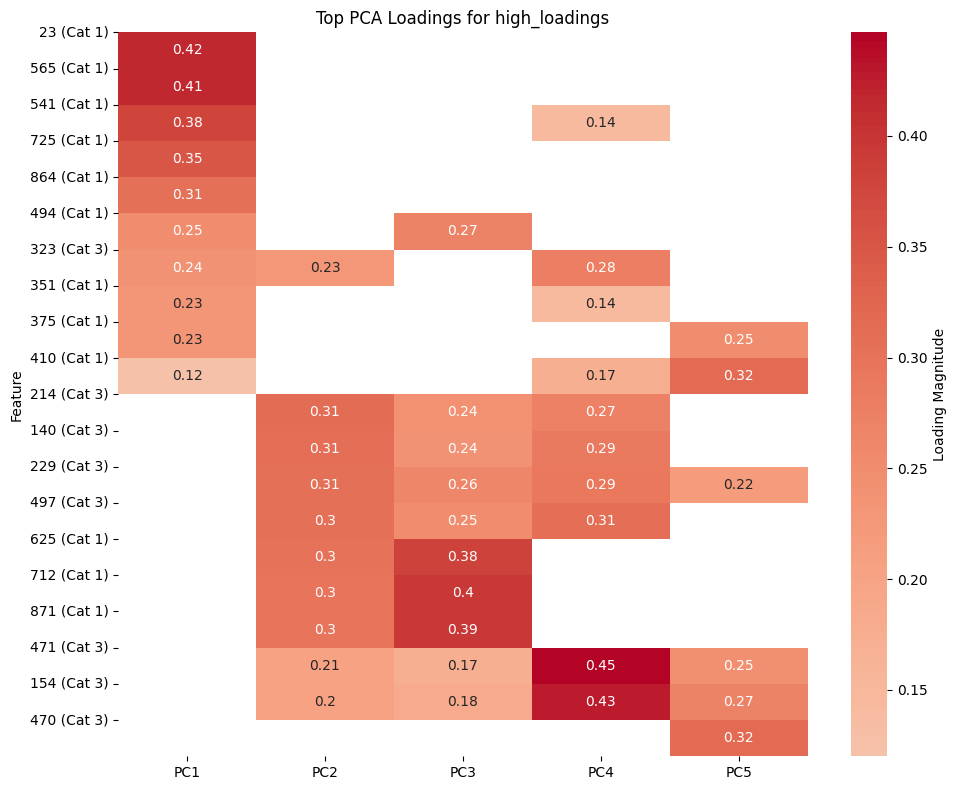

In [98]:
# We taking the data from the previous algoritms results
pca = results_high_loadings_cluster['pca']
scaled_data = results_high_loadings_cluster['scaled_data']
# Loadings calculation call
results_high_loadings_Loadings = calculate_and_analyze_pca_loadings(high_loadings, pca, 'scaled_data', 'high_loadings')

# Access the results
loadings_df = results_high_loadings_Loadings['high_loadings_loadings_df']
explained_variance = results_high_loadings_cluster['explained_variance']
cumulative_variance = results_high_loadings_cluster['cumulative_variance']
top_loadings = results_high_loadings_Loadings['high_loadings_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings with category analysis (double heatmap):
plot_top_pca_loadings(results_high_loadings_Loadings, 'high_loadings')

### high_loadings Analysiis of Loadings by Category

In [99]:
# Then analyze the category distribution
analysis_results_high_loadings = analyze_pca_feature_categories(results_high_loadings_Loadings['high_loadings_top_loadings_df'], high_loadings)
print_pca_category_analysis(analysis_results_high_loadings)

#overlaping:
overlapping = analysis_results_high_loadings['overlapping_features']

Features by Category:
Category 1: [23, 351, 375, 410, 494, 541, 565, 625, 712, 725, 799, 864, 871]
Category 3: [140, 154, 214, 229, 323, 354, 408, 470, 471, 497, 583]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 23 (Category 1): Unique, Max loading = 0.418
Feature 140 (Category 3): Unique, Max loading = 0.308
Feature 154 (Category 3): Unique, Max loading = 0.429
Feature 214 (Category 3): Unique, Max loading = 0.313
Feature 229 (Category 3): Unique, Max loading = 0.307
Feature 323 (Category 3): Unique, Max loading = 0.277
Feature 351 (Category 1): Unique, Max loading = 0.233
Feature 354 (Category 3): Unique, Max loading = 0.252
Feature 375 (Category 1): Unique, Max loading = 0.249
Feature 408 (Category 3): Unique, Max loading = 0.194
Feature 410 (Category 1): Unique, Max loading = 0.318
Feature 470 (Category 3): Unique, Max loading = 0.318
Feature 471 (Category 3): Unique, Max loading = 0.447
Feature 494 (Category 1): Unique, Max loading = 0

# 15 Selected trial and error
## 15.1. Trial and error with claude

In [100]:
def test_and_update_features(base_df, feature_to_test, action='add'):
    """
    Test a feature and optionally add/remove it from the dataframe

    Parameters:   base_df: Current working dataframe
                  feature_to_test: Feature number to test
                   action: 'add' or 'remove' or 'test' (just view results)

    Returns:    updated_df: Updated dataframe if action is 'add'/'remove', None if 'test'
    results:    PCA results
    """
    if action == 'add':
        # Add the feature without plotting
        updated_df = pd.concat([base_df, original[[feature_to_test]]], axis=1)
        print(f"\nAdded feature {feature_to_test}")
        return updated_df, None

    elif action == 'remove':
        # Remove feature if present
        if feature_to_test in base_df.columns:
            updated_df = base_df.drop(columns=[feature_to_test])
            print(f"\nRemoved feature {feature_to_test}")
            return updated_df, None

    else:  # 'test'
        # Test with plot
        test_df = pd.concat([base_df, original[[feature_to_test]]], axis=1)
        results = pca_pipeline(test_df, 'Category', n_components=2,
                             dataset_name=f'testing_{feature_to_test}')
        print(f"\nTested feature {feature_to_test}")
        return base_df, results
# additional features from original_pca to test
original_pca_features = [516, 512,736, 546, 265,13,720,  564, 662,  727, 250,187, 413, 300, 687,  96, 875  ,591]
#from Merged_selected =Category 3: [110, 140, 214, 470, 491, 526]
#Category 1: [23, 323, 549]
#Category 2: [270] No 270, 110, 323 desorganisa todos los otros puntos que no son verdes
# no 512, 736,265,13,720,662,727, 250,300. 187, 687, 875
## yes  546,516,96,564,413,214,470,

In [101]:
original.dtypes

Category      int64
1           float64
2           float64
3           float64
4           float64
             ...   
878         float64
879         float64
880         float64
881         float64
882         float64
Length: 883, dtype: object

In [102]:
original.columns.tolist()

['Category',
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 18

In [103]:
# df
top_trial = [23, 91, 549, 342, 565, 625, 678, 712, 725, 799, 864,  871, #351, **375**,334,
            863, 265, 270,
            201, 214, 229, 408, 471, 526, 584] # 512,581,621,270 joiningf= cat1 410, 541, 494

# Create test dataset
trial_columns = ['Category'] + top_trial

trial = original[trial_columns]#.astype(int)
# 154 makes all very desorganise, has very big influence
#265 appears to have good effect

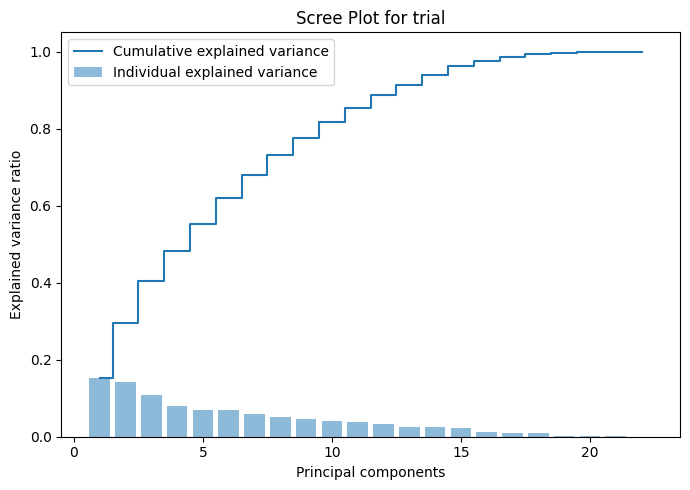

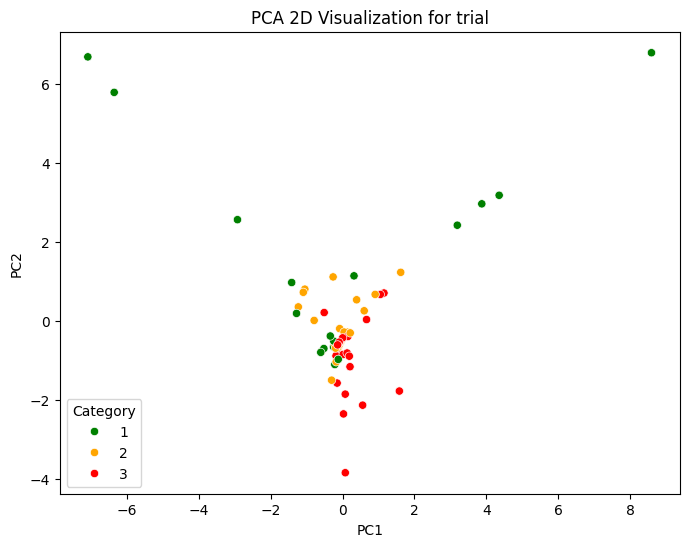

trial_pipeline:
trial_pipeline:
Cross-Validation MAE Scores for RF: [0.7117, 0.7436, 0.4109, 0.2964, 0.5709]
Average MAE for RF: 0.5467
Mean Squared Error: 0.2151
Root Mean Squared Error: 0.4638
Mean Absolute Error: 0.3807
Feature Importance by RF:     Features  Importance
2        549      0.4039
14       270      0.1242
0         23      0.0770
18       408      0.0611
20       526      0.0592
16       214      0.0418
5        625      0.0365
10       864      0.0321
12       863      0.0261
1         91      0.0248
17       229      0.0226
11       871      0.0215
19       471      0.0160
6        678      0.0136
13       265      0.0107
8        725      0.0103
4        565      0.0072
21       584      0.0060
7        712      0.0031
3        342      0.0014
9        799      0.0008
15       201      0.0001
trial_pipeline:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.4167, 0.4545, 0.6364, 0.6364, 0.7273]
Average Accuracy: 0.5743
Precision: [0.375, 0.3506, 0.4667, 0.7121, 0.7636]
Average Precision: 0.5336
Recall: [0.4167, 0.4545, 0.6364, 0.6364, 0.7273]
Average Recall: 0.5743
F1-Score: [0.3939, 0.3939, 0.5351, 0.6228, 0.7273]
Average F1-Score: 0.5346

Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [1 4 2]
 [0 2 2]]

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       0.57      0.57      0.57         7
           3       0.50      0.50      0.50         4

    accuracy                           0.57        14
   macro avg       0.58      0.58      0.58        14
weighted avg       0.57      0.57      0.57        14


Feature Importance:
    Features  Importance
2        549      0.1674
20       526      0.0810
18       408      0.0766
14       270      0.0763
16       214      0.0760
10       864      0.0651
1   

In [104]:
# Aply pipeline for visual results
trial_pca = pca_pipeline(trial, 'Category', n_components=2, dataset_name='trial')
# Apply the pipeline for numerical results
trial_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(trial, "trial", n_components=2, n_top_features=None)
# Apply pipeline Regression
trial_pipeline_reg, importances_reg= apply_pipeline_regressor(trial, "trial")
# Apply the pipeline Classification
trial_pipe_class, importances_class = apply_classification_pipeline_classif(trial, "trial")

In [105]:
# Added features that look good
working_df, _ = test_and_update_features(Influencers_OLS, 375, action='remove') # [512, 581, 621]


Removed feature 375


In [106]:
print(*trial.columns)# cat 1: 23, 91, 334, 342, 351, 375, 549, 565, 625, 678, 712, 725, 799, 864, 871
                        #   cat 2:863] [512, 581, 621] |[270] |

Category 23 91 549 342 565 625 678 712 725 799 864 871 863 265 270 201 214 229 408 471 526 584


In [107]:
# Added features that look good
working_df, _ = test_and_update_features(Influencers_OLS, 678, action='remove') # [512, 581, 621]


Removed feature 678


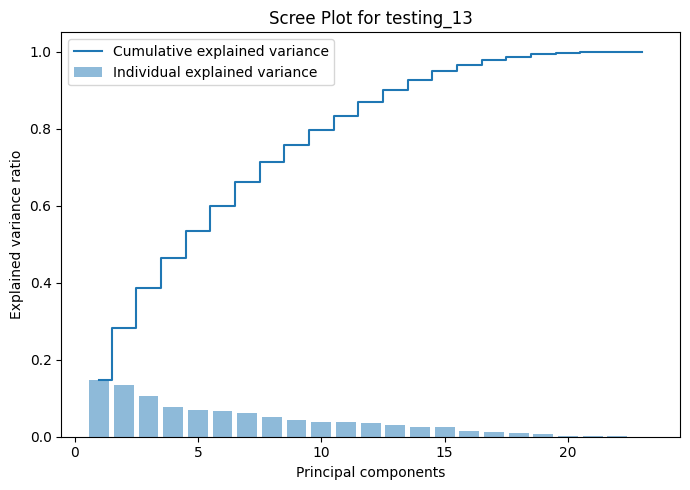

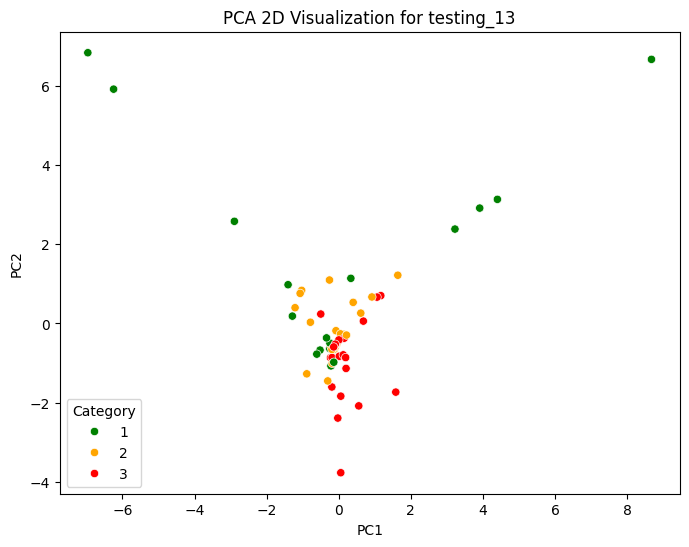


Tested feature 13


In [108]:
# Added features that look good
trial_tri, _ = test_and_update_features(trial, 13, action='test') # [512, 581, 621]

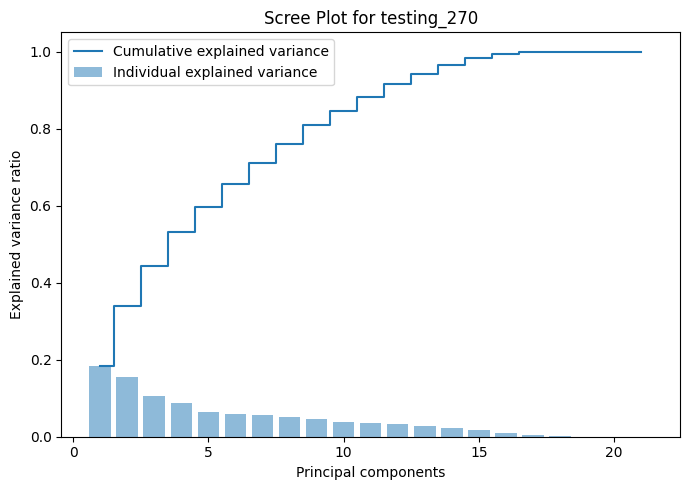

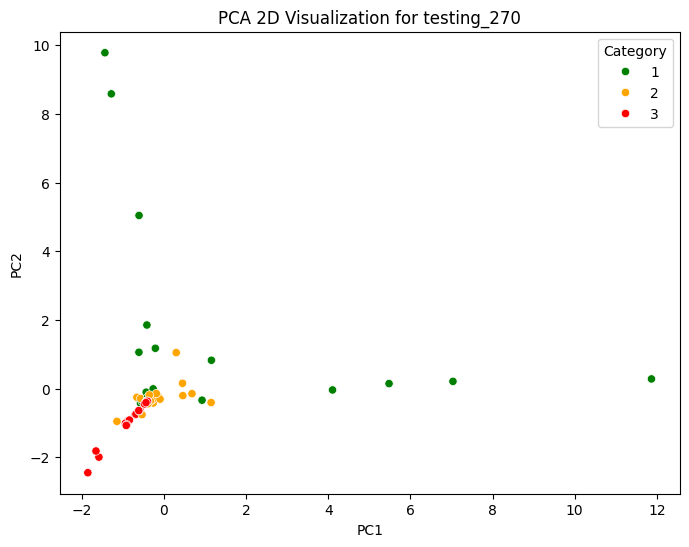


Tested feature 270


In [109]:
# Added features that look good
working_df, _ = test_and_update_features(Influencers_OLS, 270, action='test') # [512, 581, 621]


Removed feature 375


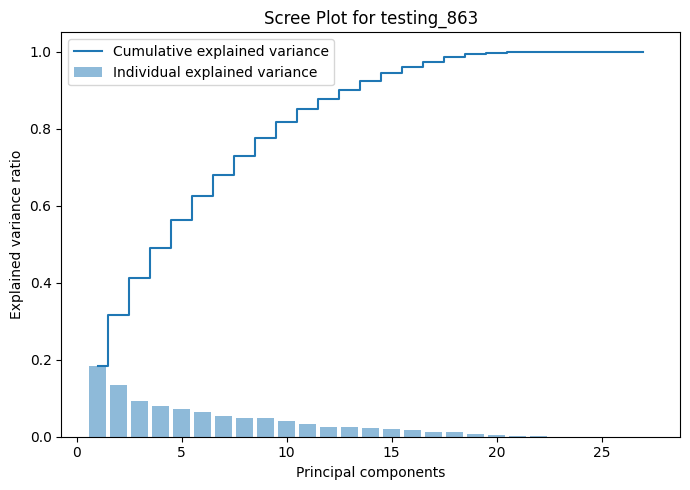

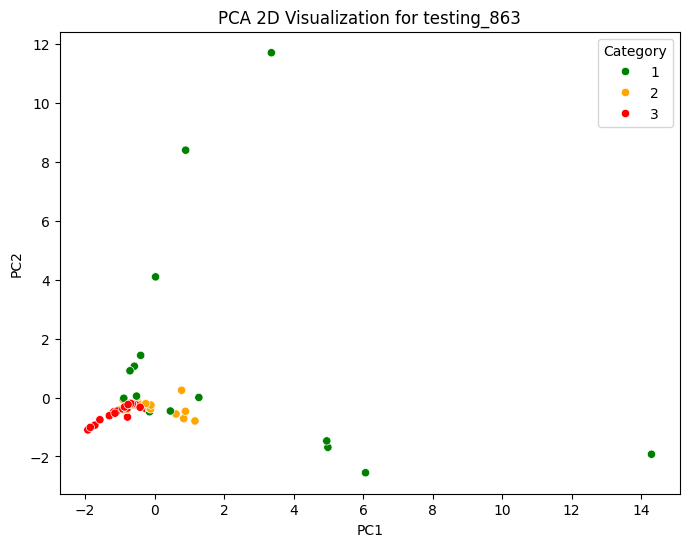


Tested feature 863


In [110]:
# Added features that look good
working_df, _ = test_and_update_features(Influencers_uniques, 375, action='remove') # [512, 581, 621]
working_df, _ = test_and_update_features(Influencers_uniques, 863, action='test')

## 15.2 3D Visualisation pca to Loadings to original Feat

In [111]:
def plot_pca_feature_loadings(df, loadings_df, analysis_results, dataset_name=None, plot_3d=False):
    """
    Create a PCA loadings plot showing how features contribute to PC1, PC2, and optionally PC3.
    Uses the output from analyze_pca_feature_categories for category information.

    Parameters:
    -----------
    loadings_df : pandas DataFrame. DataFrame containing the PCA loadings with features as index and PCs as columns
    analysis_results : dict Output from analyze_pca_feature_categories containing feature categories
    dataset_name : int, Name of the dataset for the plot title
    plot_3d : bool, Whether to create an interactive 3D plot with Plotly
    """
    import plotly.graph_objects as go

    # Convert index to integer
    loadings_df.index = loadings_df.index.astype(int)

    # Compute categories for features just like in the original code
    feature_categories = {}
    for feature in loadings_df.index:
        cat_means = {
            cat: df[df['Category'] == cat][feature].mean()
            for cat in [1, 2, 3]
        }
        feature_categories[feature] = max(cat_means.items(), key=lambda x: x[1])[0]


    # Generate title
    plot_title = f"{dataset_name} - PCA Feature Loadings" if dataset_name else "PCA Feature Loadings"

    # Color mapping
    color_map = {1: '#00CC00', 2: '#FFA500', 3: '#FF0000'}

    if plot_3d:
        # Create 3D Plotly figure
        fig = go.Figure()

        # Add arrows for each feature
        for feature in loadings_df.index:
            pc1_loading = loadings_df.loc[feature, 'PC1']
            pc2_loading = loadings_df.loc[feature, 'PC2']
            pc3_loading = loadings_df.loc[feature, 'PC3']

            # Get category from our computed categories
            category = feature_categories[feature]
            color = color_map[category]

            # Add line from origin to loading point
            fig.add_trace(go.Scatter3d(
                x=[0, pc1_loading],
                y=[0, pc2_loading],
                z=[0, pc3_loading],
                mode='lines',
                line=dict(color=color, width=5),
                name=f'Feature {feature} (Cat {category})'
            ))

            # Add text label at loading point
            fig.add_trace(go.Scatter3d(
                x=[pc1_loading],
                y=[pc2_loading],
                z=[pc3_loading],
                mode='text',
                text=[(feature)],
                textposition='top center',
                name=f'Label {feature}'
            ))

        # Update layout
        fig.update_layout(
            title=plot_title,
            width=1200,
            height=800,
            scene=dict(
                xaxis_title='PC1',
                yaxis_title='PC2',
                zaxis_title='PC3',
                aspectmode='cube',
                camera=dict(
                    up=dict(x=0, y=0, z=1),
                    center=dict(x=0, y=0, z=0),
                    eye=dict(x=1.5, y=1.5, z=1.5)
                )
            ),
            showlegend=True
        )

    else:
        # 2D matplotlib plot
        plt.figure(figsize=(12, 8))
        ax = plt.gca()

        # Create arrows from origin to loading points
        for feature in loadings_df.index:
            pc1_loading = loadings_df.loc[feature, 'PC1']
            pc2_loading = loadings_df.loc[feature, 'PC2']

            # Get category from our computed categories
            category = feature_categories[feature]
            color = color_map[category]

            # Draw arrow
            ax.arrow(0, 0, pc1_loading, pc2_loading,
                    color=color, alpha=0.6, head_width=0.02, head_length=0.02, width=0.005)

            # Add feature name
            ax.text(pc1_loading*1.1, pc2_loading*1.1, (feature),
                   fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

        # Add reference lines
        ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)

        # Set equal aspect ratio
        ax.set_aspect('equal')

        # Set limits
        max_val = max(abs(loadings_df[['PC1', 'PC2']]).max().max() * 1.2, 1.0)
        ax.set_xlim(-max_val, max_val)
        ax.set_ylim(-max_val, max_val)

        # Labels and title
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_title(plot_title)

        # Add legend
        legend_elements = [plt.Line2D([0], [0], color=color, label=f'Category {cat}',
                                    linewidth=3) for cat, color in color_map.items()]
        ax.legend(handles=legend_elements, fontsize=10)

        ax.grid(True, alpha=0.3)
        plt.tight_layout()

    # Show the appropriate plot
    if plot_3d:
        fig.show()
    else:
        plt.show()

In [112]:
# From the loadings dataframe:Influencers_uniques
plot_pca_feature_loadings(Influencers_uniques, results_influencers_uniques_Loadings['Influencers_uniques_loadings_df'],
                                                analysis_results_Influencers_uniques,"Influencers__uniques", plot_3d=True)

In [113]:
# From the loadings dataframe:Influencers_OLS    # , dataset_name="Influencers_OLS"
plot_pca_feature_loadings(Influencers_OLS, results_Influencers_OLS_Loadings['Influencers_OLS_loadings_df'],
                                                analysis_results_Influencers_OLS,"Influencers_OLS", plot_3d=True)

In [114]:
# From the loadings dataframe:Influencers_OLS    # , dataset_name="Influencers_OLS"
plot_pca_feature_loadings(high_loadings, results_high_loadings_Loadings['high_loadings_loadings_df'],
                                                analysis_results_high_loadings,"high_loadings", plot_3d=True)

In the plot tridimensional space it is possible to differentiate all the different features and their eignevectoren, annotated with the number identifier of the genera. All the categories are on a different plane.
Category 2 feature (863) occupies its own distinct plane
Category 3 features are grouped in a line
Category 1 features occupy two different planes
What appears as overlap in 2D is actually distinct in 3D space the view is rotated.

# 16. putting together all dfs for reference only purposes

Making a compendium of all the features that are relevant to our study Keep track of the loading values for each feature. When a feature appears in multiple analyses, keep the highest loading value. Save from which analysis each feature came from and sort features by loading value within each category

In [115]:
# Get features and their loadings from each analysis
features_with_loadings = {1: {}, 2: {}, 3: {}}

# Add from OLS_all
for feat, info in analysis_results_OLS_all['feature_loading_info'].items():
    cat = info['category']
    features_with_loadings[cat][feat] = {
        'max_loading': info['max_loading'],
        'source': 'OLS_all'
    }

# Add from Merged_selected
for feat, info in analysis_results_Merged_selected['feature_loading_info'].items():
    cat = info['category']
    if feat not in features_with_loadings[cat] or info['max_loading'] > features_with_loadings[cat][feat]['max_loading']:
        features_with_loadings[cat][feat] = {
            'max_loading': info['max_loading'],
            'source': 'Merged_selected'
        }

# Add from Influencers
for feat, info in analysis_results_Influencers['feature_loading_info'].items():
    cat = info['category']
    if feat not in features_with_loadings[cat] or info['max_loading'] > features_with_loadings[cat][feat]['max_loading']:
        features_with_loadings[cat][feat] = {
            'max_loading': info['max_loading'],
            'source': 'Influencers'
        }

# Add category 2 from original_pca with threshold
for feat, info in analysis_results_original_pca['feature_loading_info'].items():
    if info['category'] == 2 and info['max_loading'] > 0.30:
        if feat not in features_with_loadings[2] or info['max_loading'] > features_with_loadings[2][feat]['max_loading']:
            features_with_loadings[2][feat] = {
                'max_loading': info['max_loading'],
                'source': 'original_pca'
            }

# Print organized results
print("\nFeatures by category with loadings:")
for cat in features_with_loadings:
    print(f"\nCategory {cat}:")
    # Sort by loading value
    sorted_features = sorted(features_with_loadings[cat].items(),
                           key=lambda x: x[1]['max_loading'],
                           reverse=True)
    for feat, info in sorted_features:
        print(f"Feature {feat}: Loading = {info['max_loading']:.3f}, Source = {info['source']}")


Features by category with loadings:

Category 1:
Feature 23: Loading = 0.650, Source = Merged_selected
Feature 342: Loading = 0.604, Source = Influencers
Feature 799: Loading = 0.543, Source = OLS_all
Feature 771: Loading = 0.541, Source = OLS_all
Feature 712: Loading = 0.490, Source = Influencers
Feature 871: Loading = 0.489, Source = Influencers
Feature 625: Loading = 0.488, Source = Influencers
Feature 549: Loading = 0.482, Source = Merged_selected
Feature 565: Loading = 0.446, Source = Influencers
Feature 410: Loading = 0.410, Source = OLS_all
Feature 864: Loading = 0.408, Source = Influencers
Feature 678: Loading = 0.403, Source = Influencers
Feature 79: Loading = 0.389, Source = OLS_all
Feature 725: Loading = 0.385, Source = OLS_all
Feature 605: Loading = 0.385, Source = OLS_all
Feature 541: Loading = 0.370, Source = OLS_all
Feature 88: Loading = 0.345, Source = OLS_all
Feature 426: Loading = 0.340, Source = OLS_all
Feature 480: Loading = 0.334, Source = OLS_all
Feature 334: Loa

# 17. Former selection section 14

Features 549, 214, 229, and 526 consistently appear important across datasets, though their contributions vary, suggesting different underlying structures. The improved color separation in clustering visualizations indicates feature 549's importance may relate to cluster separation. While DBSCAN showing mostly noise suggests the structure isn't density-based, the clear category-linked patterns in other clustering methods indicate strong discriminative potential. In order to select the features contributing to the risk label and no to neglect any important data points, a discriminative selection would take place. The mapping of the cluster to the categories would be done for each of the dataframes, so to be more precise. The discriminative selection of the features can be done to take into account all the metrics presented in this notebook, so no to prescind of important genera.

## 17.1. Adjusted Rand Index (ARI): Mapping of Clusters to Category
To properly evaluate feature importance, we need to map clusters to their corresponding categories for each dataframe. This mapping allows us to assess how well the clustering aligns with our known categories. The ARI will measure this alignment, adjusting for chance agreement. We'll analyze these key dataframes:

original_pca: Baseline for comparison
Influencers_uniques_selected: Current best performer with highest classification accuracy
Merged_selected: Combined features from multiple analyses
old_new: Previous feature selections that showed promise

In [116]:
# Define mappings for each mappable dataset based on clustering analysis
mappings = {
'Influencers_OLS': {   # from 4.4. and 11.4
        1:1, 3:1, # v shape - v shape Category 1 green
        4:2,   # middle Category 2 yellow
        0:3, 2:3     # Linear Category 3  red
    },
    'Influencers_uniques': { # from 8.1. and 11.6
      1:1, 3:1, 2:1, # inverted v shape Category 1 green
      4:2,      # middle Category 2 yellow
      0:3       # # Linear Category 3  red
    },
    'Merged_selected': { # from 8.1. and 11.6
      3:1, 4:1,
      0:2,      # middle Category 2 yellow
      1:3, 2:3       # # Linear Category 3  red
    },
    'old_new': { # from 8.1. and 11.8
      1:1,
      4:2,
      0:3, 2:3, 3:3
    },
    'high_loadings': { # from 14.10
      0:1, 4:1,
      2:2,
      1:3, 3:3
    },

}
# Function to apply mapping and calculate ARI
def calculate_mapped_ari(df, df_name, cluster_labels):
    mapping = mappings[df_name]
    mapped_labels = np.array([mapping[label] for label in cluster_labels])
    true_labels = df['Category']
    return adjusted_rand_score(true_labels, mapped_labels), mapped_labels

# Store results for each dataset
mapping_results = {}
for df_name in mappings.keys():
    if df_name == 'Influencers_OLS':
        labels = results_Influencers_OLS_cluster['kmeans']['cluster_labels']
        ari, mapped = calculate_mapped_ari(Influencers_OLS, df_name, labels)
        mapping_results[df_name] = {
            'ari': ari,
            'mapped_labels': mapped
        }

    elif df_name == 'Influencers_uniques':
        labels = results_influencers_uniques_cluster['kmeans']['cluster_labels']
        ari, mapped = calculate_mapped_ari(Influencers_uniques, df_name, labels)
        mapping_results[df_name] = {
        'ari': ari,
        'mapped_labels': mapped
        }
    elif df_name == 'Merged_selected':
        labels = results_Merged_selected_cluster['kmeans']['cluster_labels']
        ari, mapped = calculate_mapped_ari(Merged_selected, df_name, labels)
        mapping_results[df_name] = {
        'ari': ari,
        'mapped_labels': mapped
        }
    elif df_name == 'old_new':
        labels = results_old_new_cluster['kmeans']['cluster_labels']
        ari, mapped = calculate_mapped_ari(old_new, df_name, labels)
        mapping_results[df_name] = {
        'ari': ari,
        'mapped_labels': mapped
        }
    elif df_name == 'high_loadings':
        labels = results_high_loadings_cluster['kmeans']['cluster_labels']
        ari, mapped = calculate_mapped_ari(high_loadings, df_name, labels)
        mapping_results[df_name] = {
        'ari': ari,
        'mapped_labels': mapped
        }

## 17.2. Performance Comparison Calculation and Visualisation
Before proceeding with discriminative selection, we evaluated the overall performance of our key dataframes using multiple metrics. These include PCA variance explained, classification accuracy, F1 scores, K-means silhouette scores, and clustering ARI.

In [129]:
# Compile performance metrics for each dataframe
performance_metrics = pd.DataFrame(columns=[
    'Dataset',
    'PCA_Variance_Explained',
    'Classification_Accuracy',
    'Classification_F1',
    'Kmeans_Silhouette',
    'Clustering_ARI'
])

# Influencers_OLS metrics
influencers_OLS_metrics = pd.DataFrame({
    'Dataset': 'Influencers_OLS',
    'PCA_Variance_Explained': results_Influencers_OLS_cluster['explained_variance'][:2].sum(),
    'Classification_Accuracy': 0.8286,  # From section 6.4
    'Classification_F1': 0.64,         # From section 6.4
    'Kmeans_Silhouette': results_Influencers_OLS_cluster['kmeans']['silhouette_score'],
    'Clustering_ARI': results_Influencers_OLS_cluster['kmeans']['adjusted_rand_score']
})

# Merged_selected metrics
merged_selected_metrics = pd.DataFrame({
    'Dataset': 'Merged_selected',
    'PCA_Variance_Explained': results_Merged_selected_cluster['explained_variance'][:2].sum(),
    'Classification_Accuracy': 0.6773,    # From section 8.2
    'Classification_F1': 0.6615,       # From section 8.2
    'Kmeans_Silhouette': results_Merged_selected_cluster['kmeans']['silhouette_score'],
    'Clustering_ARI': results_Merged_selected_cluster['kmeans']['adjusted_rand_score']
})

# Influencers_uniques_selected metrics
influencers_uniques_metrics = pd.DataFrame({
    'Dataset': 'Influencers_uniques',
    'PCA_Variance_Explained': results_influencers_uniques_cluster['explained_variance'][:2].sum(),
    'Classification_Accuracy': 0.8212,  # From section 7.1
    'Classification_F1': 0.8095,       # From section 7.1
    'Kmeans_Silhouette': results_influencers_uniques_cluster['kmeans']['silhouette_score'],
    'Clustering_ARI': results_influencers_uniques_cluster['kmeans']['adjusted_rand_score']
})
# Old_new metrics collection
old_new_metrics = pd.DataFrame({
    'Dataset': 'old_new',
    'PCA_Variance_Explained': results_old_new_cluster['explained_variance'][:2].sum(),
    'Classification_Accuracy': 0.644,
    'Classification_F1': 0.5948,
    'Kmeans_Silhouette': results_old_new_cluster['kmeans']['silhouette_score'],
    'Clustering_ARI': results_old_new_cluster['kmeans']['adjusted_rand_score']
})

# high_loadings metrics collection
high_loadings_metrics = pd.DataFrame({
    'Dataset': 'high_loadings',
    'PCA_Variance_Explained': results_high_loadings_cluster['explained_variance'][:2].sum(),
    'Classification_Accuracy': 0.5727,
    'Classification_F1': 0.4978,
    'Kmeans_Silhouette': results_high_loadings_cluster['kmeans']['silhouette_score'],
    'Clustering_ARI': results_high_loadings_cluster['kmeans']['adjusted_rand_score']
})

# Add metrics to DataFrame
performance_metrics = pd.concat([performance_metrics, influencers_OLS_metrics, merged_selected_metrics,
                                         influencers_uniques_metrics, old_new_metrics, high_loadings_metrics],
                                         ignore_index=True)

# Create a radar plot to visualize performance comparison
def radar_plot(df):
    # Prepare the data
    categories = list(df.columns)[1:]  # Skip 'Dataset' column
    n_categories = len(categories)

    # Normalize the values
    values_norm = df[categories].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    # Calculate angles for each axis
    angles = [n / float(n_categories) * 2 * np.pi for n in range(n_categories)]
    angles += angles[:1]

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

    # Plot data
    for idx, row in values_norm.iterrows():
        values = row.values.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=df.iloc[idx]['Dataset'])
        ax.fill(angles, values, alpha=0.1)

    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    plt.legend(loc='best')
    plt.title('Performance Comparison of Different Datasets')
    plt.show()

# Display numeric results
print("Performance Metrics Comparison:")
print(performance_metrics)

# Create visualization
radar_plot(performance_metrics)

ValueError: If using all scalar values, you must pass an index

In [130]:
performance_metrics

Empty DataFrame
Columns: [Dataset, PCA_Variance_Explained, Classification_Accuracy, Classification_F1, Kmeans_Silhouette, Clustering_ARI]
Index: []

Influencers_uniques being a more comprehensive dataframe has still a good general metrics, compared to high_loadings which was expected to perform better. Influencers_OLS still continues to be an all round better df


## 17.3. Discriminative Selection Script
The following script take a comprehensive look to all the metrics taken from the outstanding dataframes comparing them, and makes a discriminative selection of the most relevant Features that get the best score out of all the metrics, the pca influence from section 4, the predictive metrics from section 6, the clusters mapped labels, kmeans clustering results from section 11 and the loadings to refer the metrics to the original features. The idea, to make the selection over the colective dataframes, however features often work together and their importance can be highly context dependent. A feature might appear significant in one dataset combination but less so in another due to feature interacions, only discriminative when combined or in presence of other features. Or could be redundant, or carry same information and when combined with other similar feature then it would appear less significant. Also it could be that some features have a synergistic effect, which increase or supress the discriminative power. Due to that instead of combining all features and metrics. The reduced and still standing dataframes that performed better or have interesting features:
original_pca with the whole dataset information as baseline
old_new -->former selected genera
Influencers_uniques-> best performer
high_lodings-->collection of all other dataframes best features
The dataframes underwent a mapping (17.1) of the cluster to category selection first. A compendium all of the top performer genera would be merge and compared to see if the metrics improve, ultimately for the next step all the best features can be brought without much triming, so that the biological significate be evaluated and then the triming process can be done, if not statistically nor biological relevant.
Following script calculates category separation scores using mean differences and standard deviations. Evaluates cluster alignment using mapped labels. Incorporates Random Forest importance and PCA influence. Combines scores with adjustable weights and returns detailed metrics for each feature.

In [131]:
def select_discriminative_features(
    data,                     # Original dataframe
    mapped_kmeans_labels,     # From our cluster mapping
    feature_importances_rf,   # From Random Forest
    pca_influences,          # From PCA analysis
    n_features=20            # Number of features to select
):
    """
    Select most discriminative features based on multiple criteria
    """
    # Initialize results dictionary
    feature_scores = {}

    # Get feature names (excluding Category and Sites)
    features = [col for col in data.columns if col not in ['Category', 'Sites']]
    category_means = [] # track feature association with categories

    # Calculate separation between categories
    separation_score = 0
    category_weights = {1: 0.2,  # Reduce weight for Cat 1
                        2: 0.4,  # Increase for Cat 2
                        3: 0.4}  # Increase for Cat 3

    for feature in features:
        feature_values = data[feature].values
        category_means = []

        # 1. Category Separation Score
        # Calculate mean and std for each category
        category_stats = {}
        for cat in [1, 2, 3]:
            cat_values = feature_values[data['Category'] == cat]
            mean_val = np.mean(cat_values)
            category_stats[cat] = {
                'mean': mean_val,
                'std': np.std(cat_values),
                'weighted_mean': mean_val * category_weights[cat]}
            category_means.append((cat, mean_val * category_weights[cat]))  # Weight affects category assignment

        dominant_category = max(category_means, key=lambda x: x[1])[0]

        for cat1 in [1, 2, 3]:
            for cat2 in [1,2,3]:
                if cat1 < cat2:
                    mean_diff = abs(category_stats[cat1]['mean'] - category_stats[cat2]['mean'])
                    pooled_std = np.sqrt(category_stats[cat1]['std']**2 + category_stats[cat2]['std']**2)
                    weight = category_weights[cat1] * category_weights[cat2]
                    separation_score += weight * mean_diff / (pooled_std + 1e-10)

        # 2. Cluster Alignment Score. How well feature aligns with mapped clusters
        cluster_values = {}
        for cluster in np.unique(mapped_kmeans_labels):
            cluster_values[cluster] = feature_values[mapped_kmeans_labels == cluster]

        cluster_score = 0
        for cluster1 in cluster_values:
            for cluster2 in cluster_values:
                if cluster1 < cluster2:
                    mean_diff = abs(np.mean(cluster_values[cluster1]) - np.mean(cluster_values[cluster2]))
                    pooled_std = np.sqrt(np.var(cluster_values[cluster1]) + np.var(cluster_values[cluster2]))
                    cluster_score += mean_diff / (pooled_std + 1e-10)

        # 3. Get importance scores
        rf_importance = feature_importances_rf[feature_importances_rf['Features'] == feature]['Importance'].values[0]
        pca_influence = pca_influences[pca_influences['Features'] == feature]['Influence'].values[0]

        # Combine scores with weights
        feature_scores[feature] = {
            'separation_score': separation_score,
            'cluster_score': cluster_score,
            'rf_importance': rf_importance,
            'pca_influence': pca_influence,
            'dominant_category': dominant_category,
            'combined_score': (0.3 * separation_score +
                             0.3 * cluster_score +
                             0.2 * rf_importance +
                             0.2 * pca_influence)}

    # Convert to DataFrame for easier handling
    scores_df = pd.DataFrame.from_dict(feature_scores, orient='index')

    # Select top features
    selected_features = scores_df.nlargest(n_features, 'combined_score')

    # Print feature list
    print("\nTop Discriminative Features:")
    for i, (feature, scores) in enumerate(selected_features.iterrows(), 1):
        print(f"{i}. Feature {feature}: {scores['combined_score']:.4f}, Category: {scores['dominant_category']}")

    return selected_features

## 17.4. Results Discriminative Selection Influencers_OLS and Influencers_uniques_selected

In [132]:
# For Influencers_uniques
selected_features_Influencers_uniques = select_discriminative_features(
                        Influencers_uniques, mapping_results['Influencers_uniques']['mapped_labels'],
                        importances_class_Influencers_uniques, df_pca_influence_Influencers_uniques)
# For Influencers_uniques_selected
selected_features_high_loadings = select_discriminative_features(
                        high_loadings, mapping_results['high_loadings']['mapped_labels'],
                        importances_class_high_loadings, df_pca_influence_high_loadings)


Top Discriminative Features:
1. Feature 410: 5.7661, Category: 1.0
2. Feature 799: 1.7531, Category: 1.0
3. Feature 375: 1.6147, Category: 1.0
4. Feature 201: 1.4985, Category: 3.0
5. Feature 229: 1.4401, Category: 3.0
6. Feature 471: 1.3480, Category: 3.0
7. Feature 494: 1.2670, Category: 1.0
8. Feature 408: 1.2541, Category: 3.0
9. Feature 526: 1.2149, Category: 3.0
10. Feature 541: 1.2121, Category: 1.0
11. Feature 625: 1.1554, Category: 1.0
12. Feature 549: 1.1283, Category: 1.0
13. Feature 584: 1.1127, Category: 3.0
14. Feature 864: 1.0848, Category: 1.0
15. Feature 334: 1.0730, Category: 1.0
16. Feature 342: 1.0433, Category: 1.0
17. Feature 565: 1.0390, Category: 1.0
18. Feature 725: 1.0207, Category: 1.0
19. Feature 678: 0.9671, Category: 1.0
20. Feature 712: 0.9383, Category: 1.0

Top Discriminative Features:
1. Feature 494: 6611280.1879, Category: 1.0
2. Feature 725: 188.2447, Category: 1.0
3. Feature 565: 58.6908, Category: 1.0
4. Feature 351: 49.8544, Category: 1.0
5. Feat

Top Discriminative Features:
1. Feature 549: 1.9845
2. Feature 334: 1.4321
3. Feature 91: 1.3767
4. Feature 678: 1.3703
5. Feature 863: 1.3634
6. Feature 351: 1.2240
7. Feature 625: 1.1778
8. Feature 864: 1.1706
9. Feature 725: 1.1697
10. Feature 375: 1.1654
11. Feature 526: 1.1312
12. Feature 712: 1.1240
13. Feature 871: 1.1225
14. Feature 410: 1.0727
15. Feature 23: 1.0635
16. Feature 494: 1.0335
17. Feature 799: 1.0002
18. Feature 408: 0.9983
19. Feature 541: 0.9726
20. Feature 214: 0.9622

Top Discriminative Features:
1. Feature 408: 3.2048
2. Feature 584: 2.3142
3. Feature 229: 2.0870
4. Feature 606: 1.7685
5. Feature 549: 1.5129
6. Feature 110: 1.4816
7. Feature 214: 1.4436
8. Feature 23: 1.3777
9. Feature 140: 1.3617
10. Feature 526: 1.3183
11. Feature 497: 1.2787
12. Feature 154: 1.2705
13. Feature 91: 1.2562
14. Feature 725: 1.2498
15. Feature 471: 1.2443
16. Feature 581: 1.2216
17. Feature 470: 1.1959
18. Feature 334: 1.1647
19. Feature 323: 1.1507
20. Feature 351: 1.1089

I may has wasted my time the whole time and just realise!.
classes are no at all representative

In [ ]:
def analyze_selected_features(filtered_df):
    """
    Analyze frequency and abundance for selected features
    """
    feature_cols = [col for col in filtered_df.columns if col not in ['Sites', 'Category']]

    for feature in feature_cols:
        print(f"\nFeature {feature}:")
        for cat in [1, 2, 3]:
            cat_data = filtered_df[filtered_df['Category'] == cat][feature]
            present = sum(cat_data > 0)
            total = len(cat_data)

            print(f"Category {cat}:")
            print(f"Present in {present}/{total} ({present/total*100:.1f}%)")
            print(f"Mean abundance: {cat_data.mean():.4f}")

In [201]:
analyze_selected_features(original_pca)


Feature 140:
Category 1:
Present in 3/17 (17.6%)
Mean abundance: 0.0015
Category 2:
Present in 4/32 (12.5%)
Mean abundance: 0.0041
Category 3:
Present in 9/21 (42.9%)
Mean abundance: 0.0498

Feature 575:
Category 1:
Present in 15/17 (88.2%)
Mean abundance: 0.7372
Category 2:
Present in 19/32 (59.4%)
Mean abundance: 3.3039
Category 3:
Present in 11/21 (52.4%)
Mean abundance: 2.7716

Feature 687:
Category 1:
Present in 14/17 (82.4%)
Mean abundance: 0.6624
Category 2:
Present in 22/32 (68.8%)
Mean abundance: 0.5722
Category 3:
Present in 14/21 (66.7%)
Mean abundance: 1.4245

Feature 465:
Category 1:
Present in 4/17 (23.5%)
Mean abundance: 0.0031
Category 2:
Present in 4/32 (12.5%)
Mean abundance: 0.0012
Category 3:
Present in 1/21 (4.8%)
Mean abundance: 0.0001

Feature 300:
Category 1:
Present in 3/17 (17.6%)
Mean abundance: 0.0066
Category 2:
Present in 3/32 (9.4%)
Mean abundance: 0.0047
Category 3:
Present in 9/21 (42.9%)
Mean abundance: 0.0200

Feature 529:
Category 1:
Present in 5/17

For original_pca
Feature 140:


Category 1: 17.6% presence, 0.0015 abundance
Category 2: 12.5% presence, 0.0041 abundance
Category 3: 42.9% presence, 0.0498 abundance


Feature 474:


Category 1: 35.3% presence, 0.0155 abundance
Category 2: 21.9% presence, 0.0138 abundance
Category 3: 47.6% presence, 0.1514 abundance


Feature 81:


Category 1: 41.2% presence, 0.0746 abundance
Category 2: 15.6% presence, 0.0072 abundance
Category 3: 52.4% presence, 0.1035 abundance


Feature 566:


Category 1: 11.8% presence, 0.0014 abundance
Category 2: 21.9% presence, 0.0358 abundance
Category 3: 47.6% presence, 0.1763 abundance

Feature 354:


Category 1: 23.5% presence, mean abundance 0.0462
Category 2: 34.4% presence, mean abundance 1.6274
Category 3: 61.9% presence, mean abundance 2.7596


Feature 581:


Category 1: 17.6% presence, mean abundance 0.1153
Category 2: 25.0% presence, mean abundance 0.8370
Category 3: 42.9% presence, mean abundance 0.8108


Feature 606:


Category 1: 29.4% presence, mean abundance 0.4041
Category 2: 37.5% presence, mean abundance 0.0431
Category 3: 47.6% presence, mean abundance 0.2259

In [202]:
analyze_selected_features(original)

Streaming output truncated to the last 5000 lines.
Category 2:
Present in 3/32 (9.4%)
Mean abundance: 0.0014
Category 3:
Present in 1/21 (4.8%)
Mean abundance: 0.0007

Feature 429:
Category 1:
Present in 8/17 (47.1%)
Mean abundance: 0.0505
Category 2:
Present in 7/32 (21.9%)
Mean abundance: 0.1421
Category 3:
Present in 6/21 (28.6%)
Mean abundance: 0.3062

Feature 430:
Category 1:
Present in 6/17 (35.3%)
Mean abundance: 0.0469
Category 2:
Present in 9/32 (28.1%)
Mean abundance: 0.0711
Category 3:
Present in 9/21 (42.9%)
Mean abundance: 0.0305

Feature 431:
Category 1:
Present in 3/17 (17.6%)
Mean abundance: 0.0010
Category 2:
Present in 3/32 (9.4%)
Mean abundance: 0.0029
Category 3:
Present in 2/21 (9.5%)
Mean abundance: 0.0032

Feature 432:
Category 1:
Present in 3/17 (17.6%)
Mean abundance: 0.0294
Category 2:
Present in 7/32 (21.9%)
Mean abundance: 0.0039
Category 3:
Present in 7/21 (33.3%)
Mean abundance: 0.0169

Feature 433:
Category 1:
Present in 1/17 (5.9%)
Mean abundance: 0.0008

Category 3 Trend Markers:

Feature 214: Increases from 0% to 25% to 52.4%
Feature 229: Increases from 35.3% to 37.5% to 61.9%
Feature 408: Increases from 47.1% to 43.8% to 61.9%
Feature 867: Increases from 17.6% to 15.6% to 42.9%

Category 2 Trend Markers:

Feature 581: Increases from 17.6% to 25% to 42.9%
Feature 566: Increases from 11.8% to 21.9% to 47.6%
Feature 695: Increases from 35.3% to 40.6% to 57.1%

Let me check Feature 471's presence in each category:
Category 1: 3/17 (17.6%)
Category 2: 6/32 (18.8%)
Category 3: 9/21 (42.9%)

# 19. Otras Visualisations
## 19.1.  t-SNE for Visualization
t-SNE is a non-linear dimensionality reduction technique that is particularly effective for visualizing high-dimensional data in 2D or 3D. It often preserves local structure better than PCA

In [133]:
def tsne_visualization(scaled_data):
    """
    Visualizes data using t-SNE.

    Parameters:
    - df: Scaled DataFrame or numpy array (features only).
    - labels: Cluster or category labels to color-code.
    - perplexity: Perplexity for t-SNE (default=30).
    - n_components: Number of components for t-SNE (default=2).
    - random_state: Random seed for reproducibility.
    """
    # Apply t-SNE
    tsne = TSNE(n_components=3, perplexity=50, random_state=42)
    tsne_results = tsne.fit_transform(scaled_data)

    # Plot t-SNE results
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=true_labels, cmap='viridis', s=20, alpha=0.7)
    plt.colorbar(label='True Labels')
    plt.title("t-SNE Visualization")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

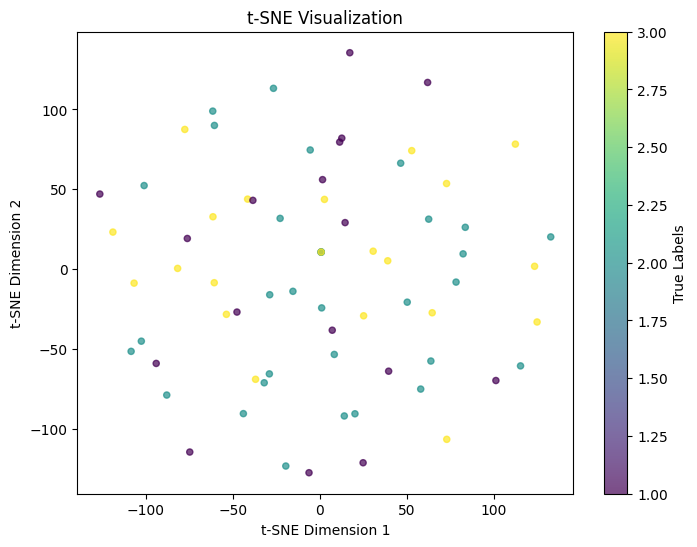

In [134]:
# Visualising the implementation
scaled_data = results_Influencers_OLS_cluster['scaled_data']
true_labels = Influencers_OLS["Category"]
tsne_visualization(scaled_data)

## 19.2. UMAP Visualisation

In [135]:
def umap_visualization(df, scaled_data, label_column='Category', colors=['green', 'orange', 'red'],
                      n_neighbors=10, min_dist=0.1):
    """
    Visualizes data using UMAP with custom colors.

    Parameters:
    - scaled_data: Scaled DataFrame or numpy array (features only).
    - labels: Cluster or category labels for color-coding.
    - categories: List of category values to match labels.
    - colors: List of colors corresponding to each category.
    - n_neighbors: Number of neighbors for UMAP (default=15).
    - min_dist: Minimum distance between points (default=0.1).

    Returns:
    - None (Displays a plot)
    """
    # Get unique categories in order
    categories = sorted(df[label_column].unique())

    # Get category labels from the DataFrame
    labels = df[label_column].values

    # Apply UMAP
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)
    umap_results = umap_reducer.fit_transform(scaled_data)

    # Create a mapping from labels to colors
    label_color_map = {category: color for category, color in zip(categories, colors)}
    mapped_colors = [label_color_map[label] for label in labels]

    plt.figure(figsize=(8, 6))
    plt.scatter(
        umap_results[:, 0], umap_results[:, 1],
        c=mapped_colors, alpha=0.8, s=50
    )
    plt.title('UMAP Visualization with Custom Colors')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    # Plotting

    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10, label=f'Category {category}')
               for category, color in zip(categories, colors)]
    plt.legend(handles=handles, title='Category', loc='best')

    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



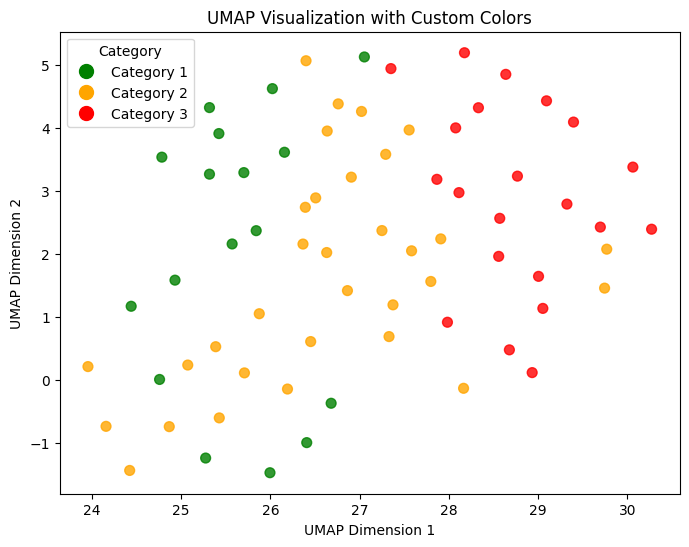

In [136]:
scaled_data = results_Influencers_OLS_cluster['scaled_data']
# Extract category labels
category_labels = Influencers_OLS['Category'].values

# Calling the function
umap_visualization(Influencers_OLS, scaled_data, label_column='Category',  colors=['green', 'orange', 'red'],  n_neighbors=20, min_dist=0.7)

### Visualisation of Influencers_OLS UMAP
presents some patterns that has distintive regions, but still some mixture.
Category 3 (red) tends to cluster on the right side
Category 1 (green) and 2 (orange) have some overlap but show patterns

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



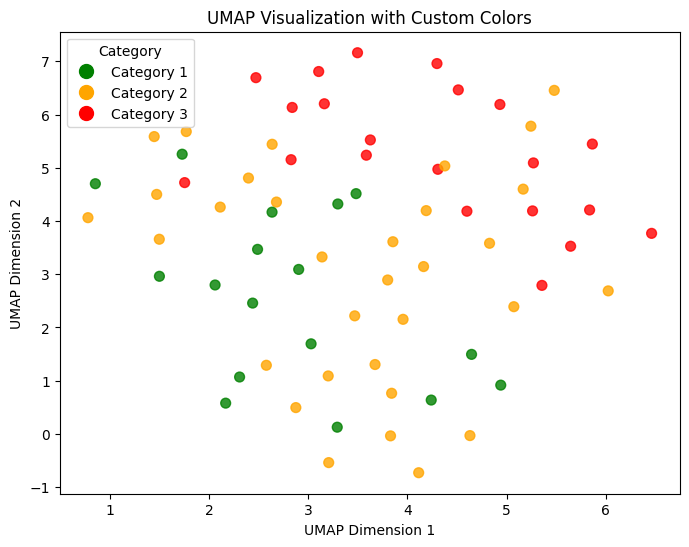

In [137]:
scaled_data = results_Influencers_cluster['scaled_data']
# Extract category labels
category_labels = Influencers['Category'].values

# Calling the function
umap_visualization(Influencers, scaled_data, label_column='Category', colors=['green', 'orange', 'red'], n_neighbors=20, min_dist=0.7)

**Influencers_uniques shows**: Different spatial arrangement, better vertical separation of Category 3.
More spread out distribution overall
**Combined/Merged** shows: More mixing between categories, some local clustering but less global structure, higher dimension 2 values (7-11 range)

In [138]:
stop

NameError: name 'stop' is not defined

# 20. Saving the dataframes

In [ ]:
# Save multiple dataframes to different sheets in the same Excel file
with pd.ExcelWriter(f'data/df_after_pca.xlsx') as writer:
    alternatives.to_excel(writer, sheet_name='alternatives', index=True)
    selected.to_excel(writer, sheet_name='selected', index=True)
    compendium.to_excel(writer, sheet_name='compendium', index=True)

## END NOTEBOOK

## OLD WORK NO TO TAKE INTO ACCOUNT

In [ ]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7])#, sort=False)#, dtype={i: float for i in range(2, 882)})
# making sure that the levels all are on str mode
Jointax.columns = Jointax.columns.set_levels([level.astype(str) for level in Jointax.columns.levels])
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
#Correcting the Tuple-like Index
Jointax.index = Jointax.index.map(lambda x: x[0] if isinstance(x, tuple) else x)

In [ ]:
# Original selected GIDs
selected_gen_fin = {154, 201, 214, 229, 334, 351, 354, 408, 497, 512, 565, 581, 583, 584, 606, 621, 625}
selected_gen_fin = set(map(str, selected_gen_fin))

mae_results = {}  # Initialize an empty dictionary to store MAE results

for gid_to_remove in selected_gen_fin:
    print(f"Removing GID: {gid_to_remove}")  # Debugging line

    # Temporarily remove one GID
    modified_gids = [x for x in selected_gen_fin if x != gid_to_remove]

    # Initialize an empty list to store the columns to keep
    columns_to_keep_fin = []

    # Filtering original DataFrame to only include the modified GIDs
    for col in Jointax.columns[2:]:
        gid = str(col[-1])
        if gid in modified_gids:
            columns_to_keep_fin.append(col)

    selected_dfs_fin = Jointax.loc[:, columns_to_keep_fin]

    # Add back the 'Sites' and 'Category' columns
    selected_dfs_fin['Sites'] = Jointax['Sites']
    selected_dfs_fin['Category'] = Jointax['Category']

    # Run pipeline here with the modified_df and get the MAE
    mae = apply_pipeline(selected_dfs_fin, "Modified_Gids")

    # Store the MAE result
    mae_results[f'Remove {gid_to_remove}'] = mae

print(mae_results)


| GID  | Join_tax                                              | Importance |   | GID  | Join_tax                                              | Influence |
|------|-------------------------------------------------------|------------|---|------|-------------------------------------------------------|-----------|
| 565  | Bacteroidales_Porphyromonadaceae_Porphyromonas        | 0.1578     |   | 581  | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3        | 2.5536    |
| 625  | Rhodospirillales_Acetobacteraceae_Roseococcus         | 0.1568     |   | 584  | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas  | 2.5225    |
| 408  | Legionellales_Legionellaceae_Legionella               | 0.1230     |   | 565  | Bacteroidales_Porphyromonadaceae_Porphyromonas        | 2.3413    |
| 229  | Actinomycetales_Corynebacteriaceae_Corynebacterium    | 0.1044     |   | 583  | Actinomycetales_Micrococcaceae_Pseudarthrobacter      | 2.2417    |
| 351  | Pasteurellales_Pasteurellaceae_Haemophilus            | 0.0930     |   | 408  | Legionellales_Legionellaceae_Legionella               | 2.2394    |
| 214  | Clostridiales_Clostridiaceae_Clostridium              | 0.0925     |   | 621  | Burkholderiales_Comamonadaceae_Roseateles             | 2.2278    |
| 354  | Oceanospirillales_Halomonadaceae_Halomonas            | 0.0675     |   | 229  | Actinomycetales_Corynebacteriaceae_Corynebacterium    | 2.2168    |
| 334  | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria | 0.0462     |   | 354  | Oceanospirillales_Halomonadaceae_Halomonas            | 2.1489    |
| 584  | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas  | 0.0443     |   | 334  | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria | 2.0918    |
| 606  | Xanthomonadale_Paracoccaceae_Rhodobacter              | 0.0387     |   | 497  | Actinomycetales_Cellulomonadaceae_Oerskovia           | 1.9865    |
| 583  | Actinomycetales_Micrococcaceae_Pseudarthrobacter      | 0.0274     |   | 625  | Rhodospirillales_Acetobacteraceae_Roseococcus         | 1.7623    |
| 621  | Burkholderiales_Comamonadaceae_Roseateles             | 0.0230     |   | 214  | Clostridiales_Clostridiaceae_Clostridium              | 1.7298    |
| 581  | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3        | 0.0196     |   | 351  | Pasteurellales_Pasteurellaceae_Haemophilus            | 1.7265    |
| 512  | Clostridiales_Clostridiaceae_Oxobacter                | 0.0032     |   | 512  | Clostridiales_Clostridiaceae_Oxobacter                | 1.5879    |
| 497  | Actinomycetales_Cellulomonadaceae_Oerskovia           | 0.0025     |   | 606  | Xanthomonadale_Paracoccaceae_Rhodobacter              | 1.3106    |


In [ ]:
# Final selected genera taxonomic levels and abundance
new_selected_gen = 625, 214,408,229,351,354,565,606,334,584,583,621,581,497,512
new_selected_gen = set(map(str, new_selected_gen))
# Initialize an empty list to store the columns to keep
columns_to_keep_new = []

# Skip the first two columns ('Header_7', 'GID') and iterate through the rest of the columns in 'Jointax'
for col in Jointax.columns[2:]:
    # Because GID or unique identifier is the last element in the multi-level header tuple
    gid = str(col[-1])  # Convert to string just to be sure
    if gid in new_selected_gen:
        columns_to_keep_new.append(col)

# Filter 'Jointax' to only include the columns in 'columns_to_keep'
selected_new = Jointax.loc[:, columns_to_keep_new]
# Add back the 'Sites' and 'Category' columns
selected_new['Sites'] = Jointax['Sites']
selected_new['Category'] = Jointax['Category']
#organising the columns
cols = [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')] + [col for col in selected_new.columns if col not in [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')]]

selected_new  = selected_new .loc[:, cols]
selected_new.head()